# Validation script

## Erosion:

In [31]:
opening_dataset = []
opening_dataset_trad = []

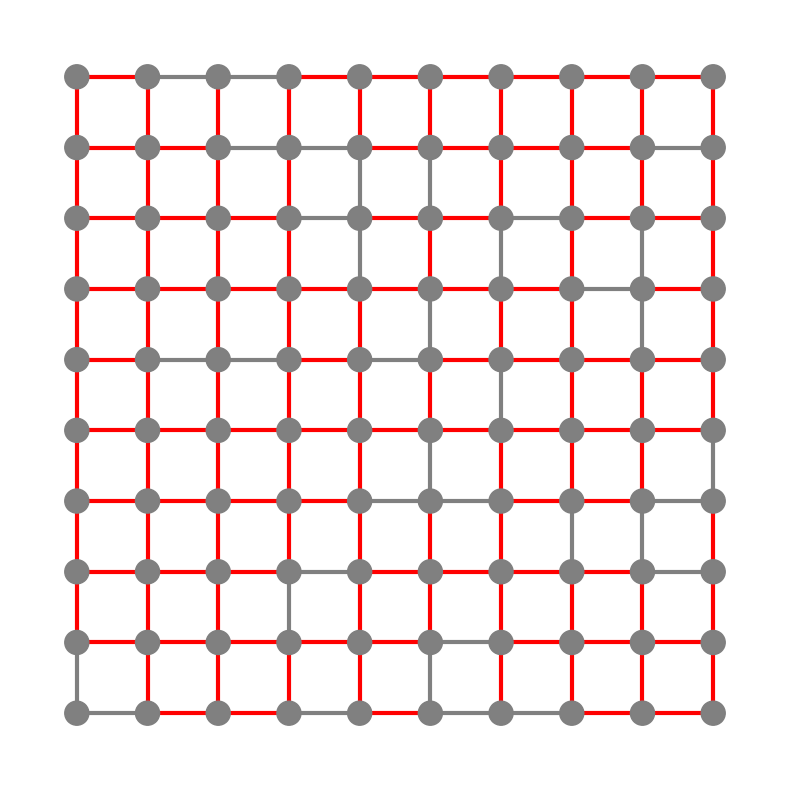

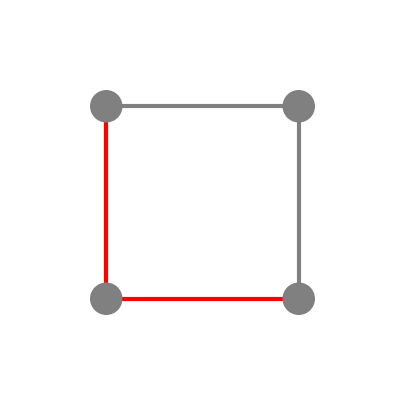

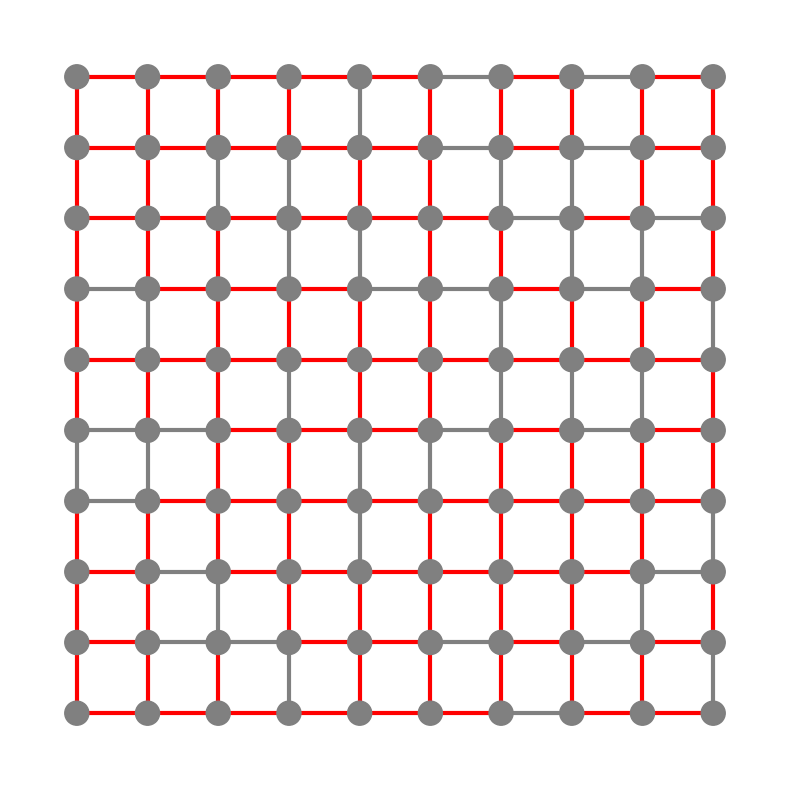

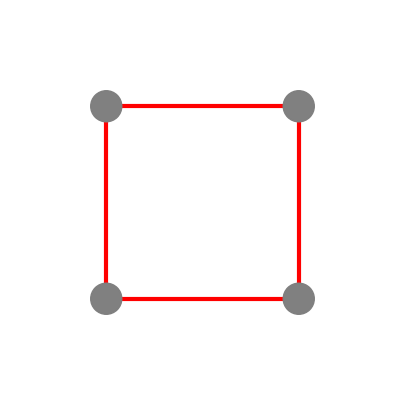

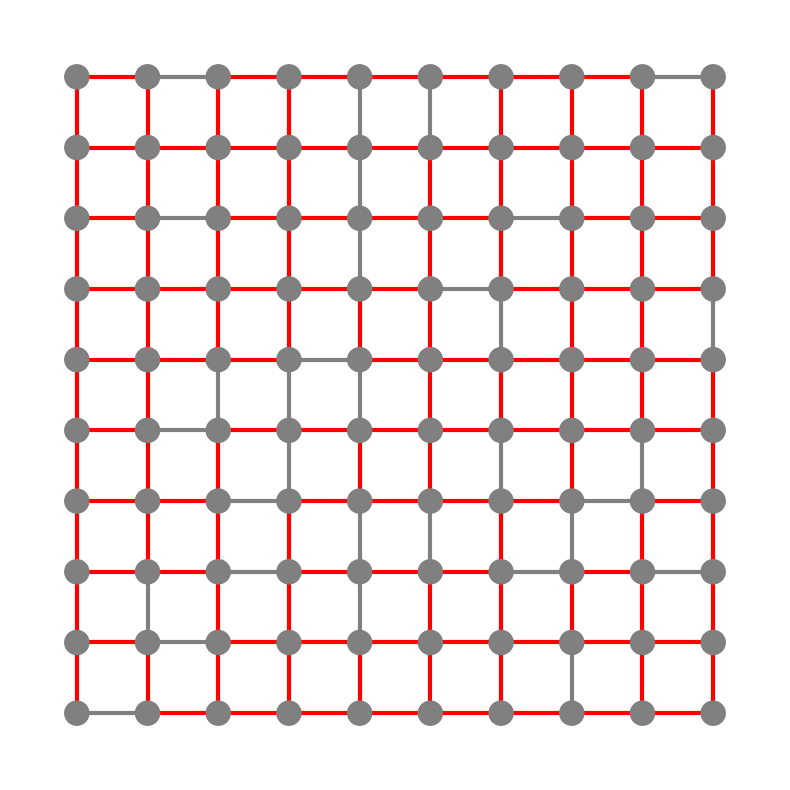

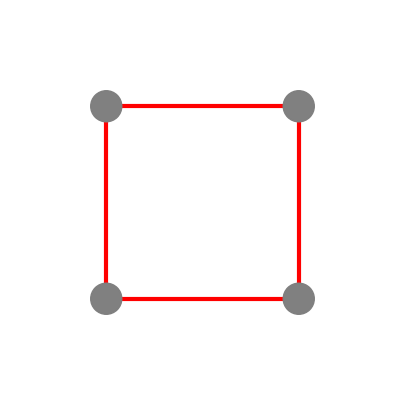

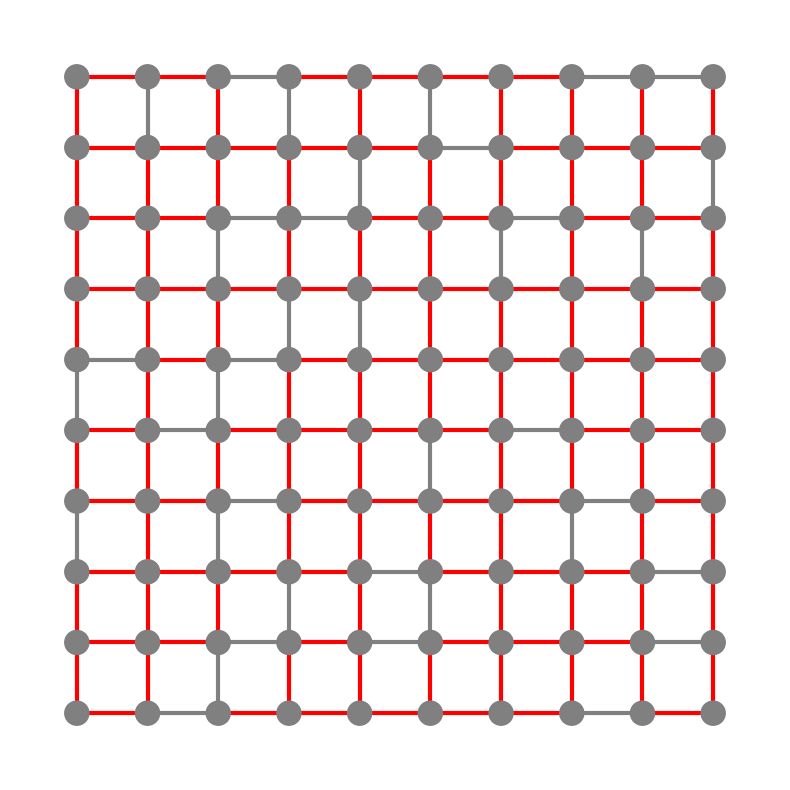

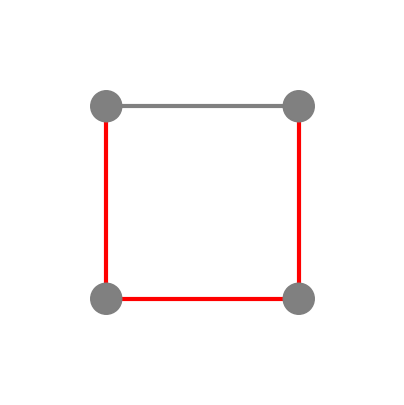

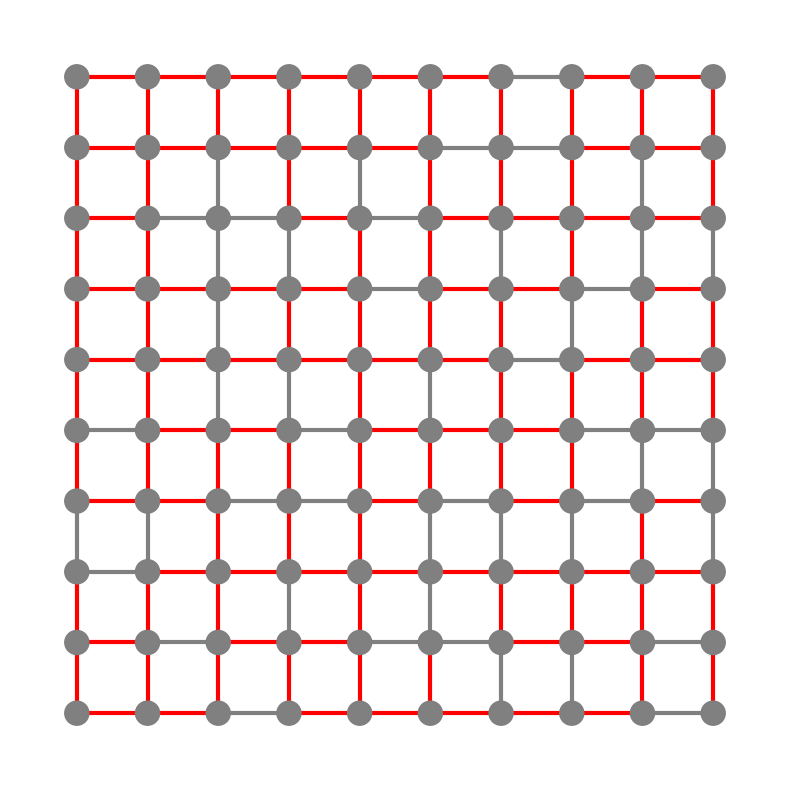

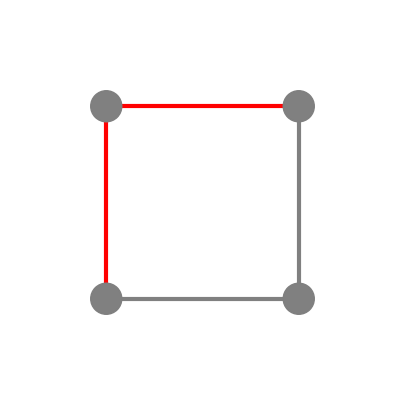

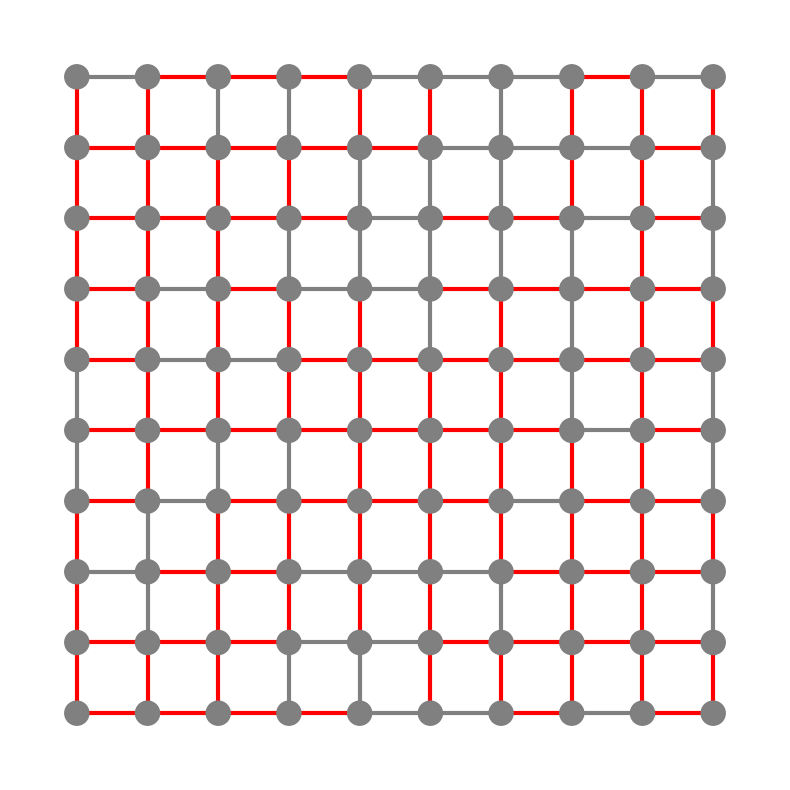

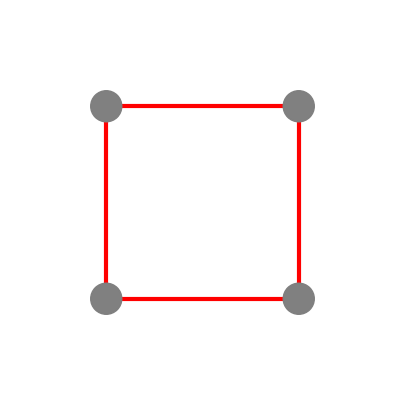

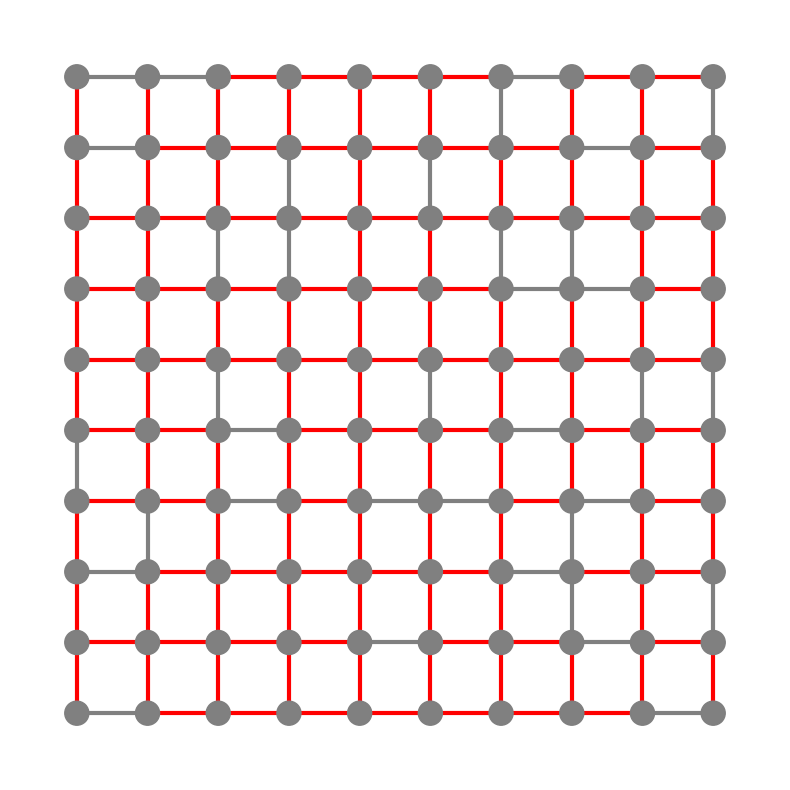

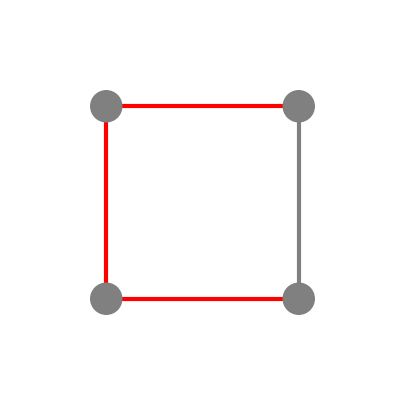

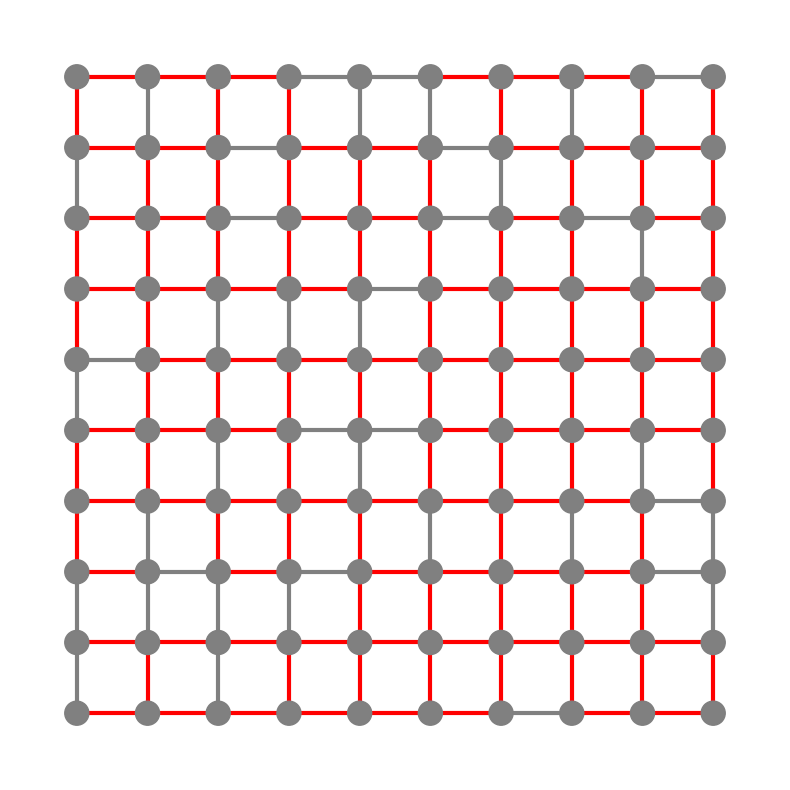

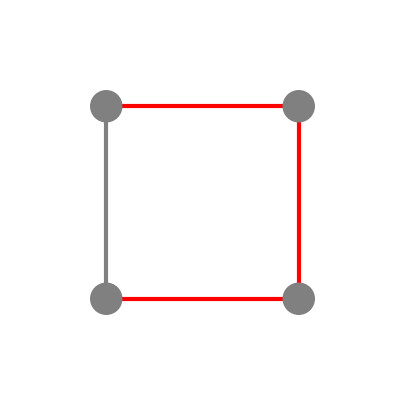

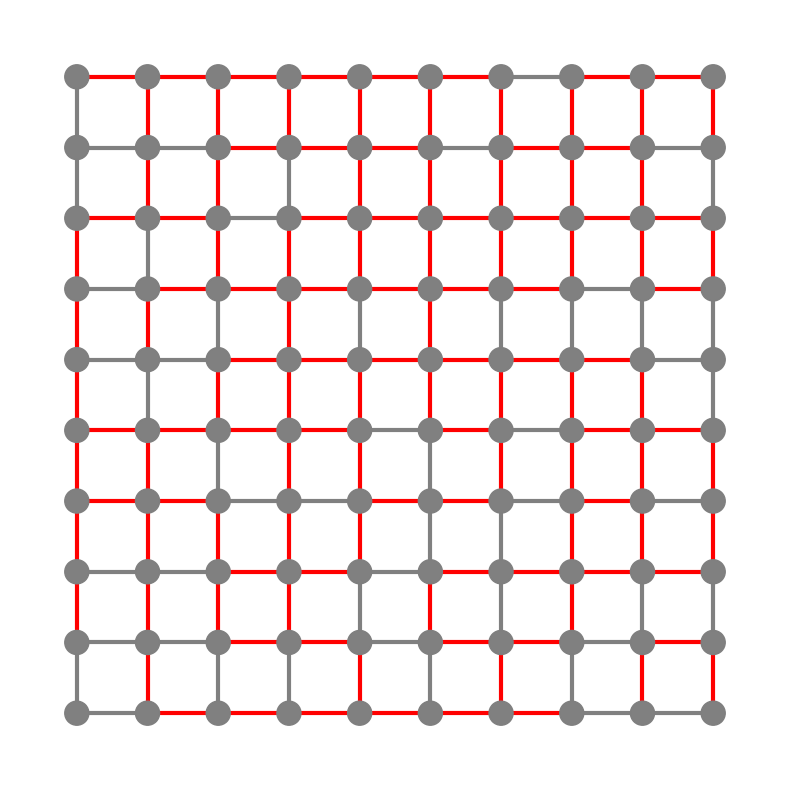

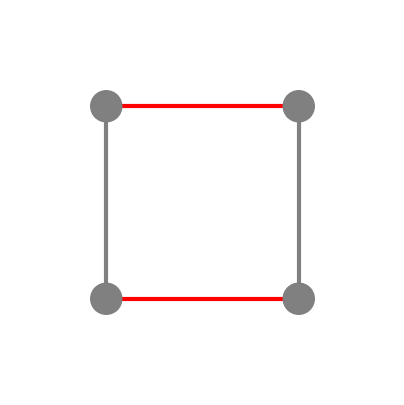

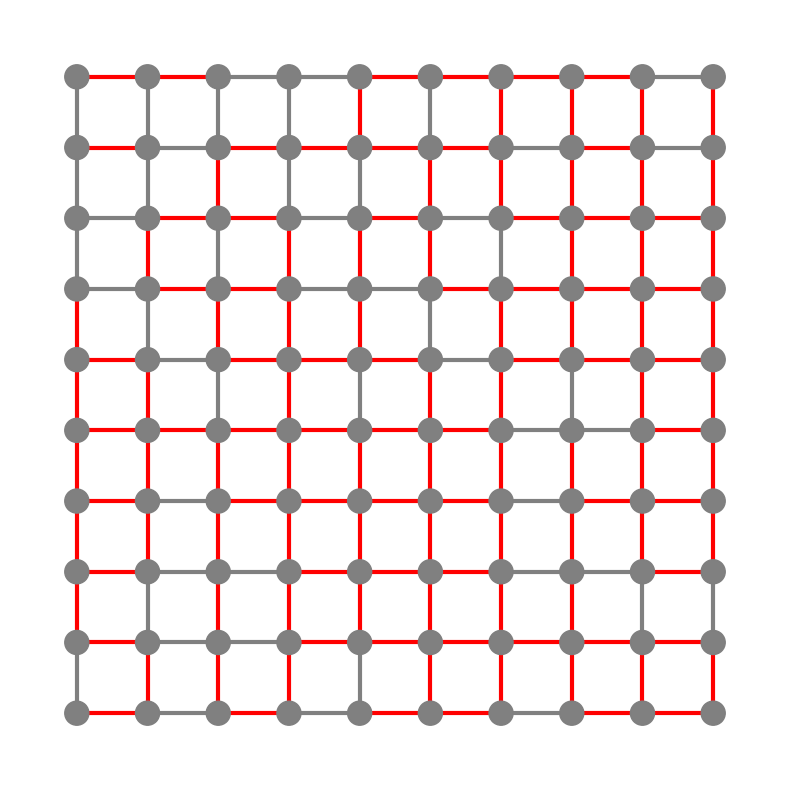

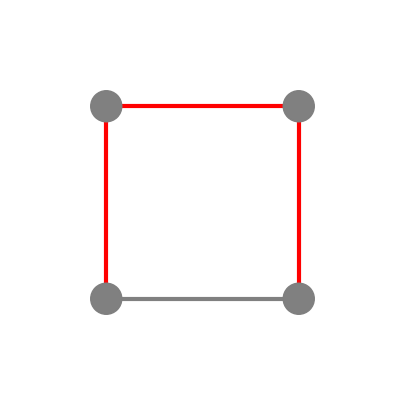

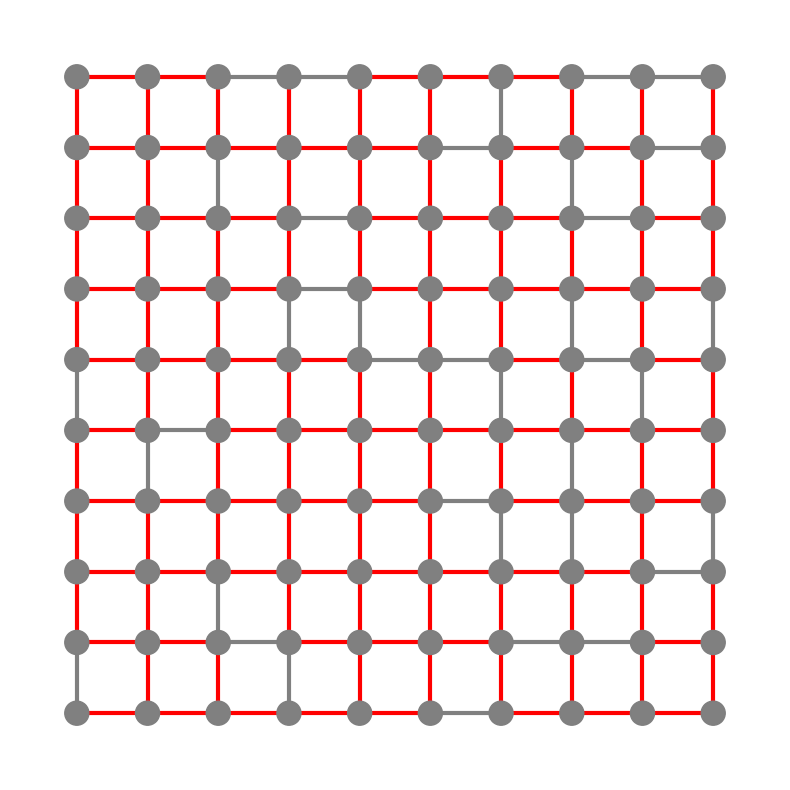

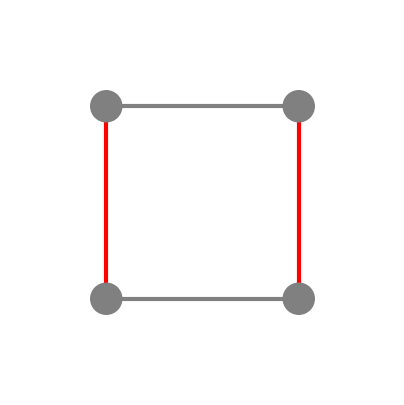

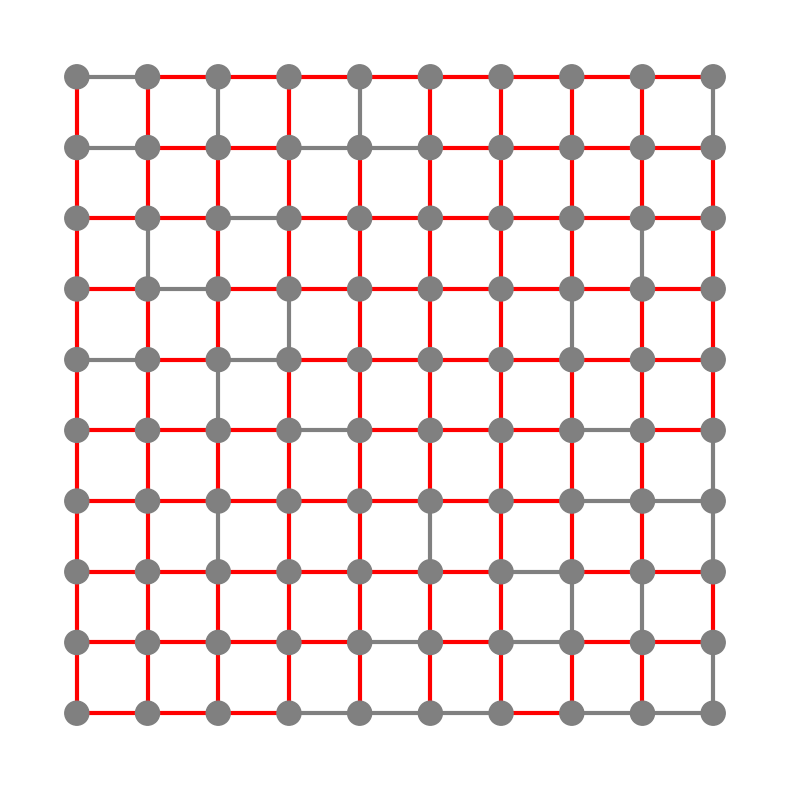

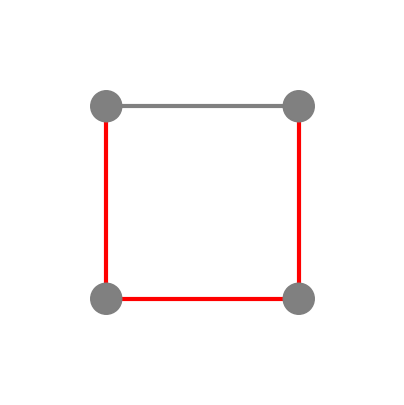

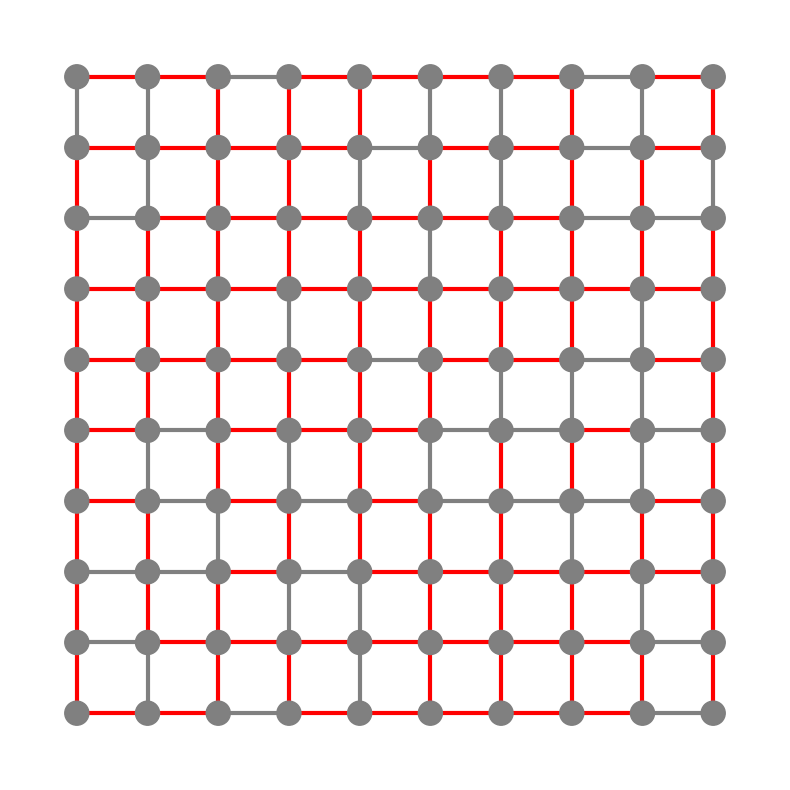

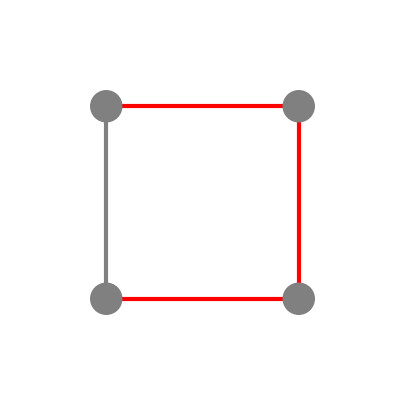

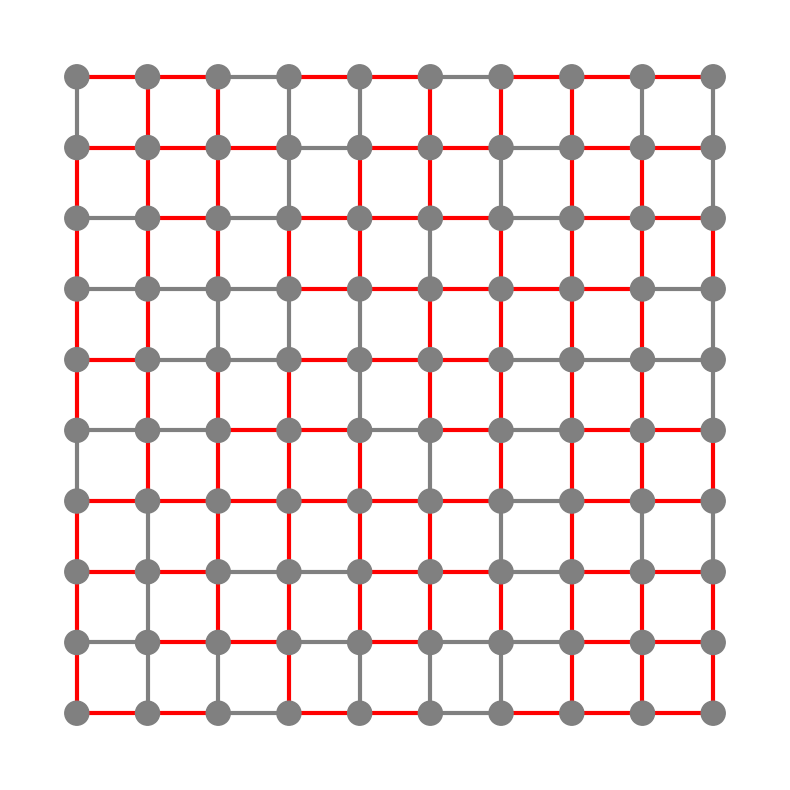

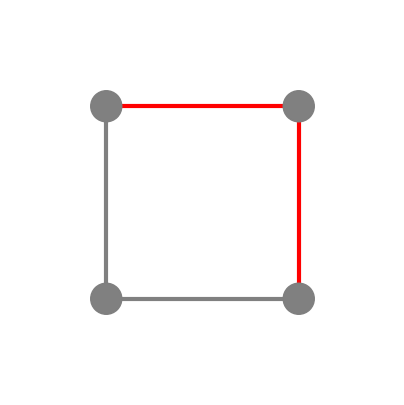

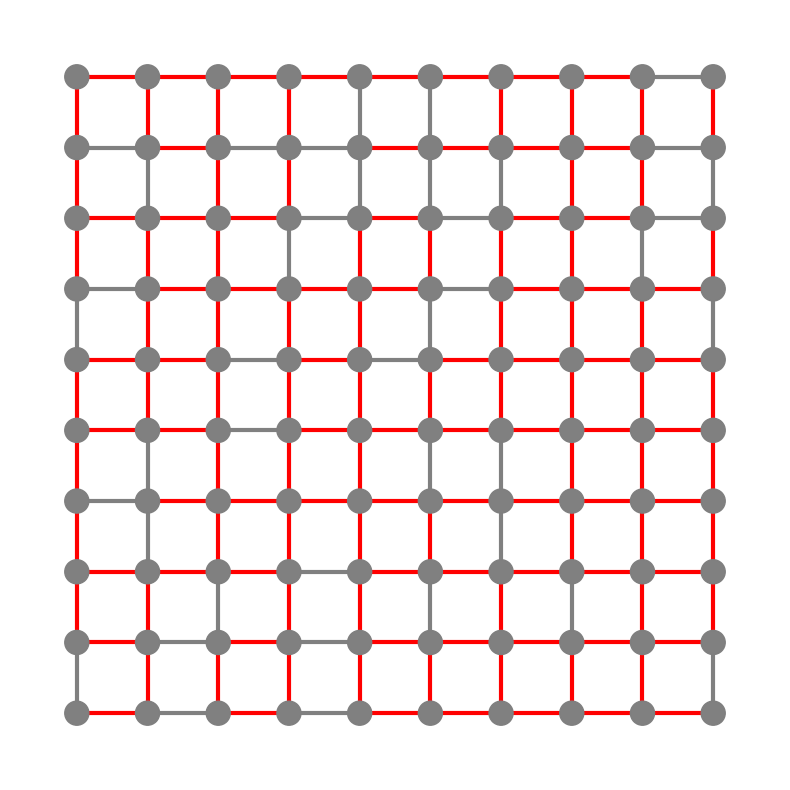

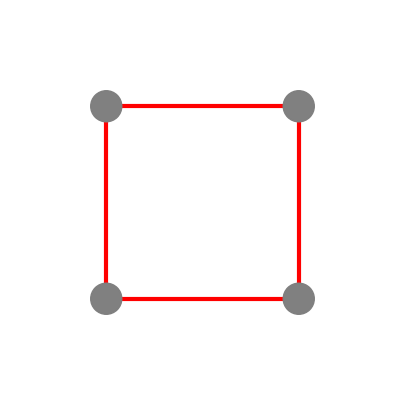

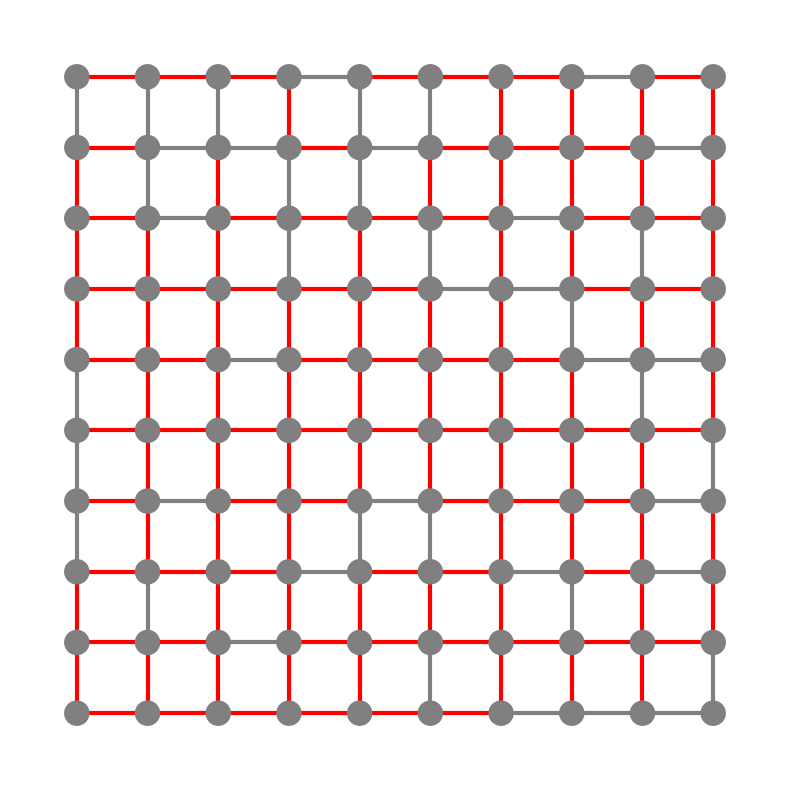

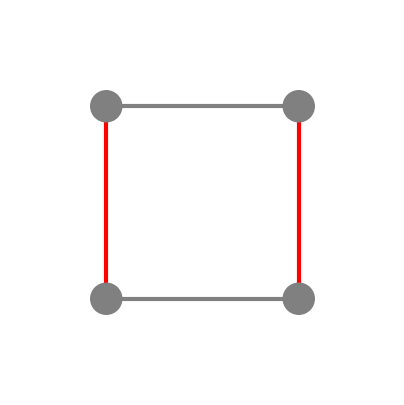

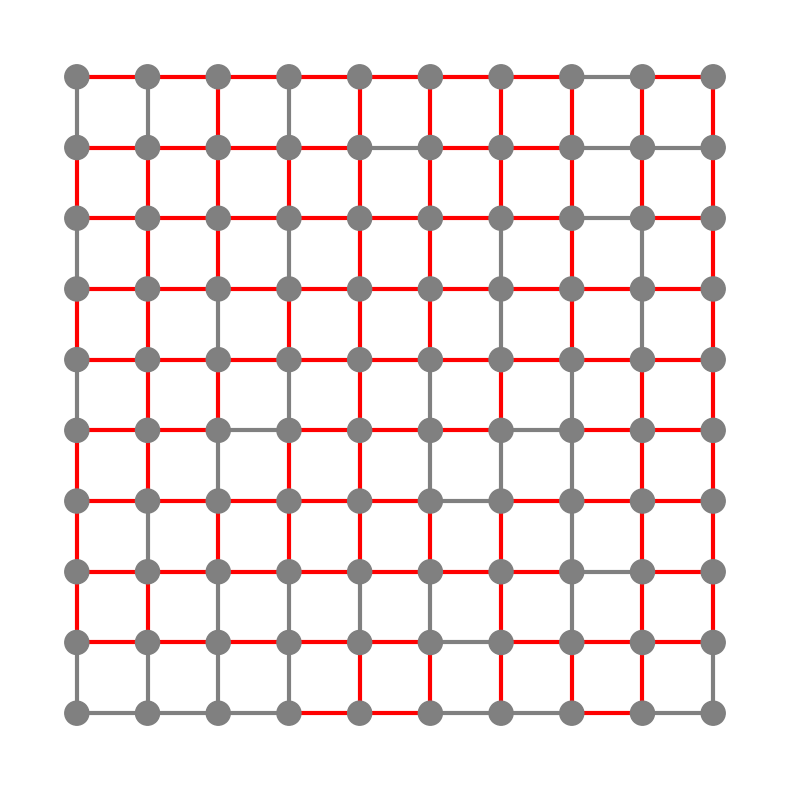

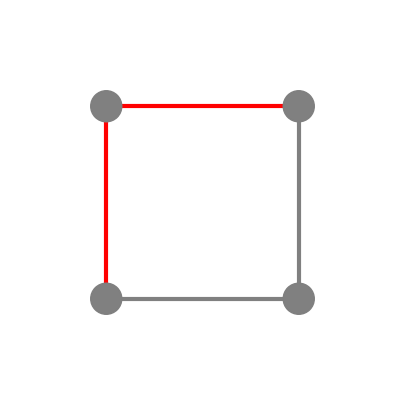

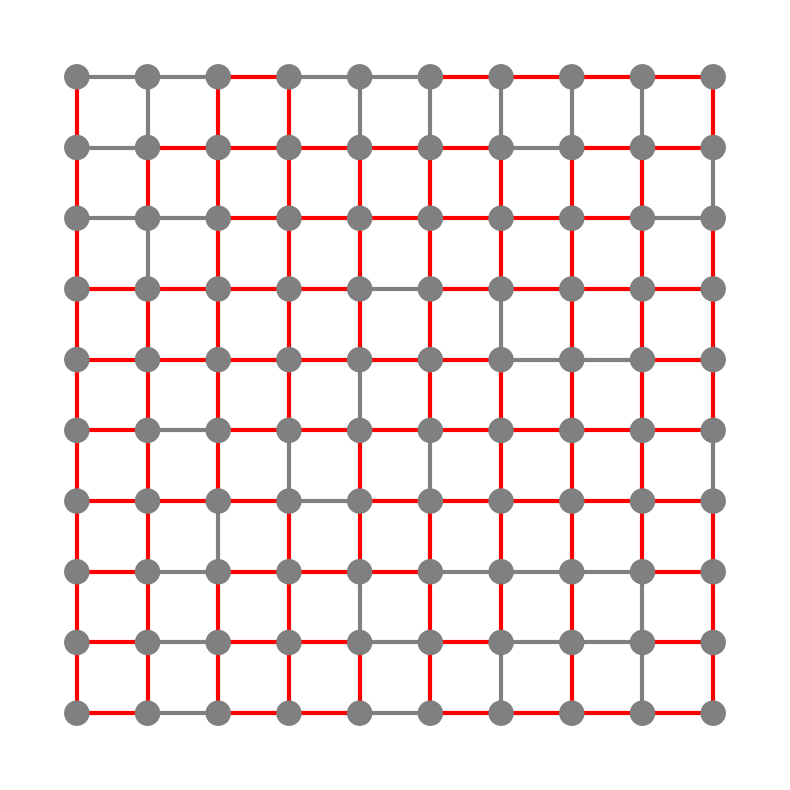

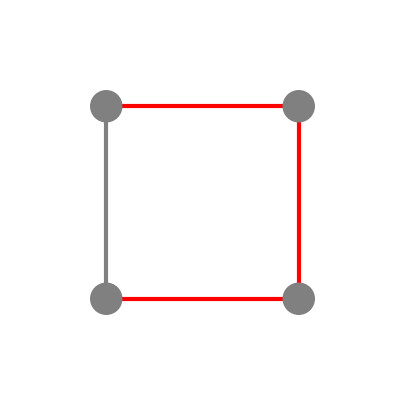

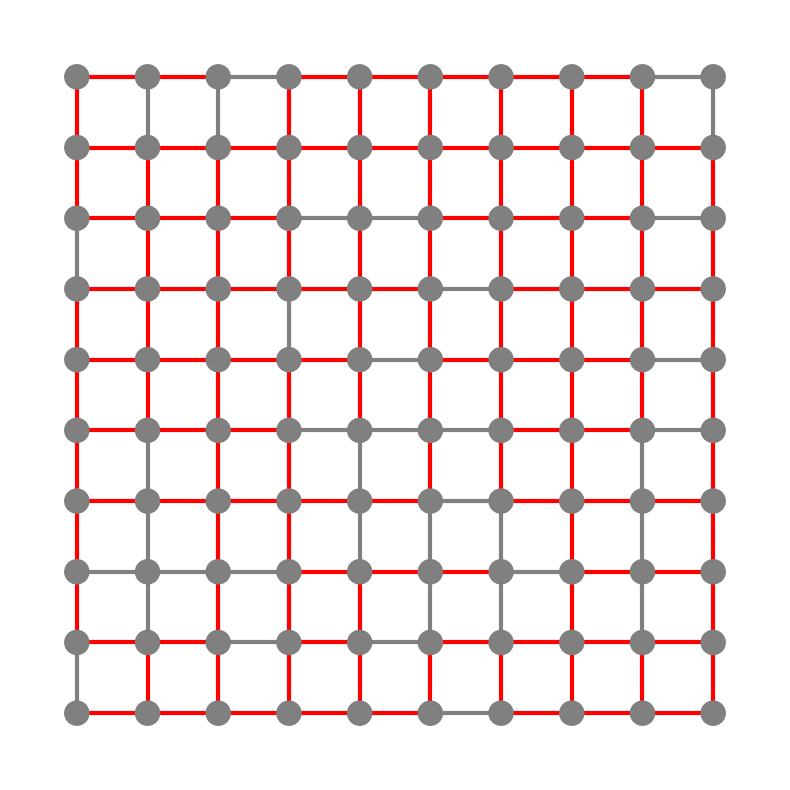

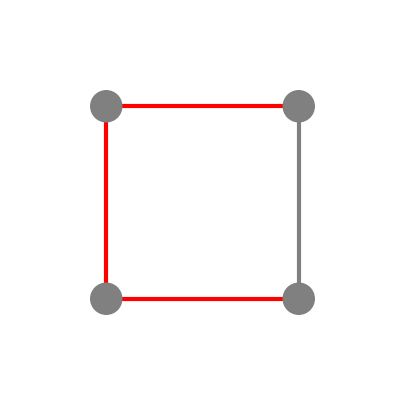

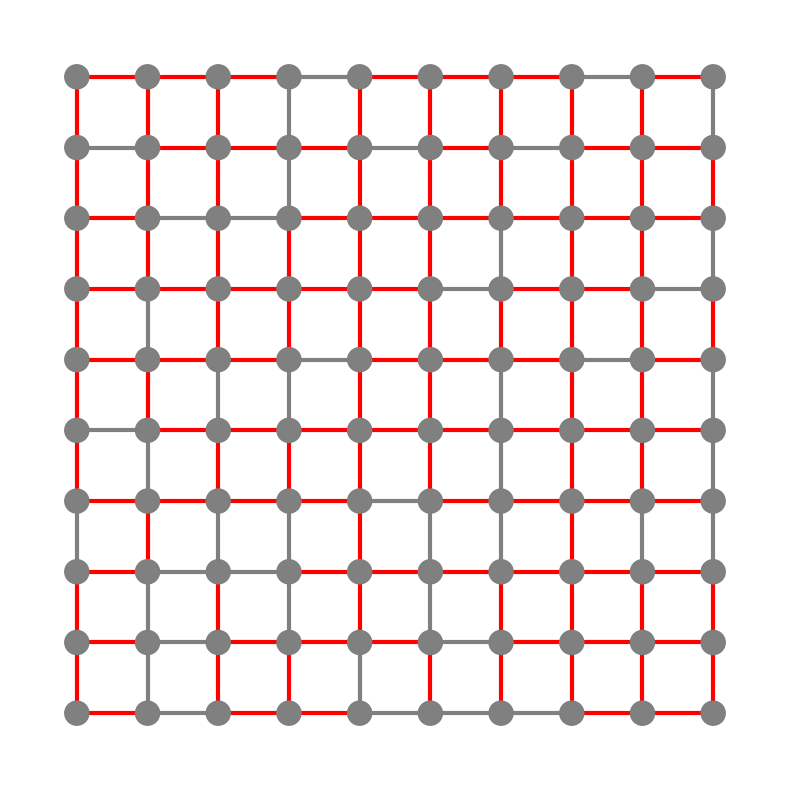

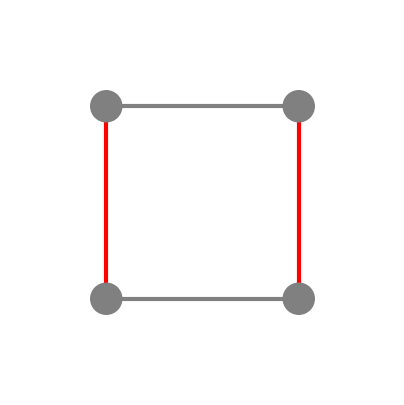

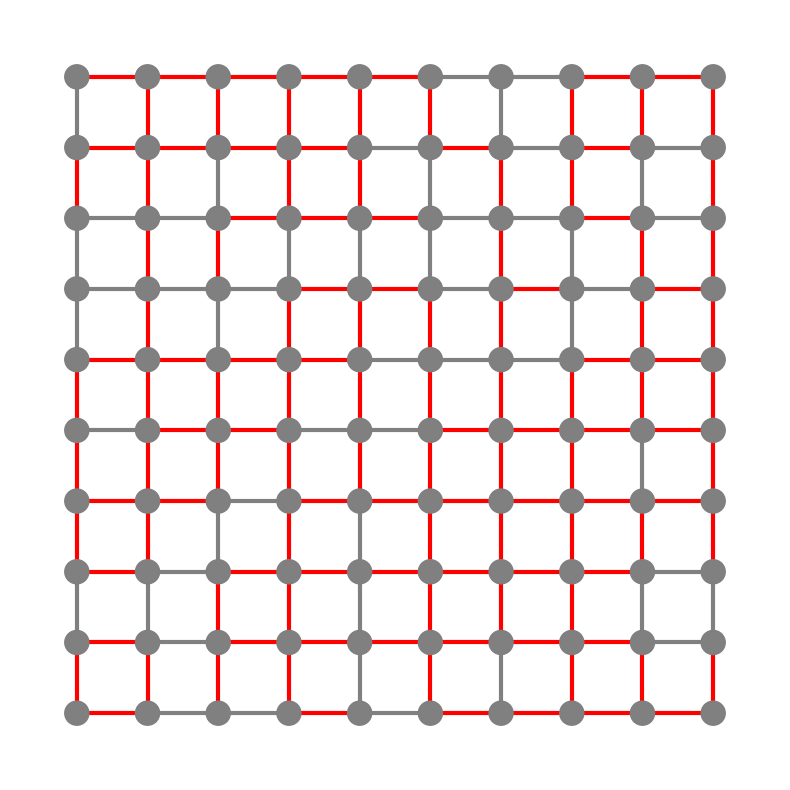

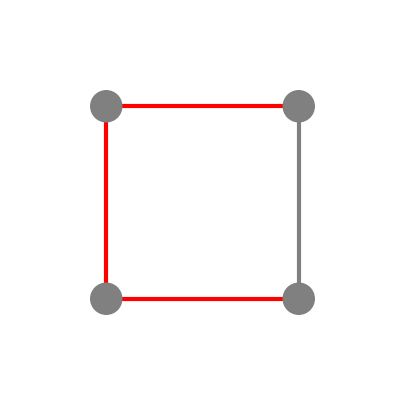

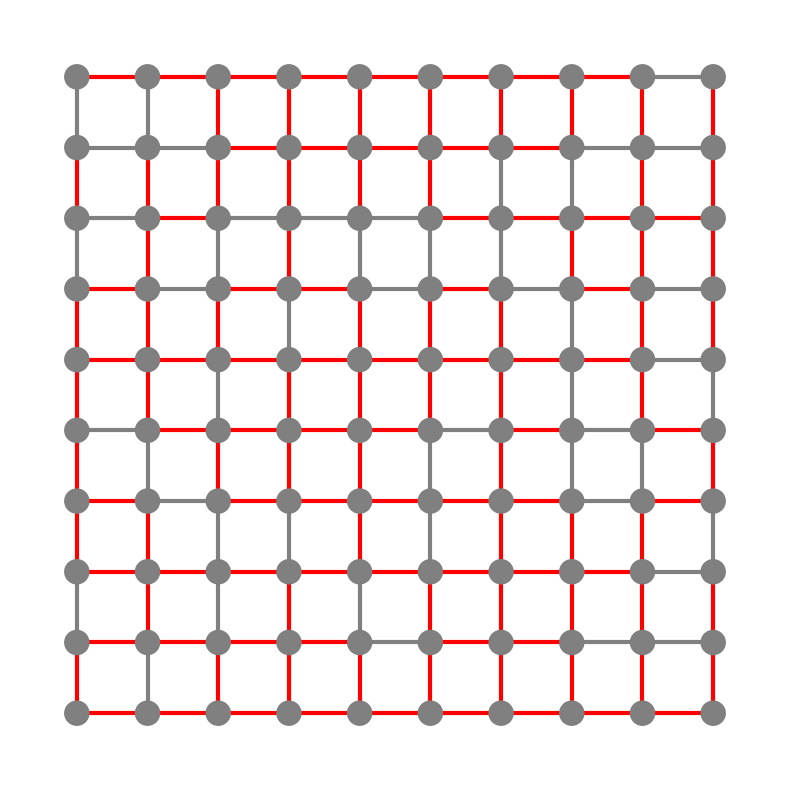

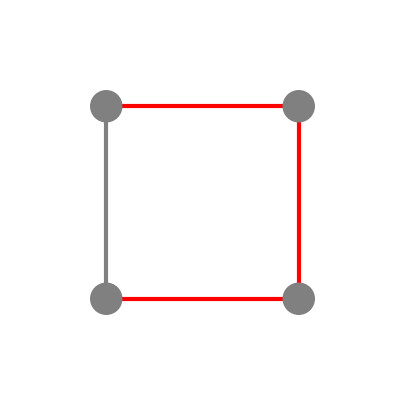

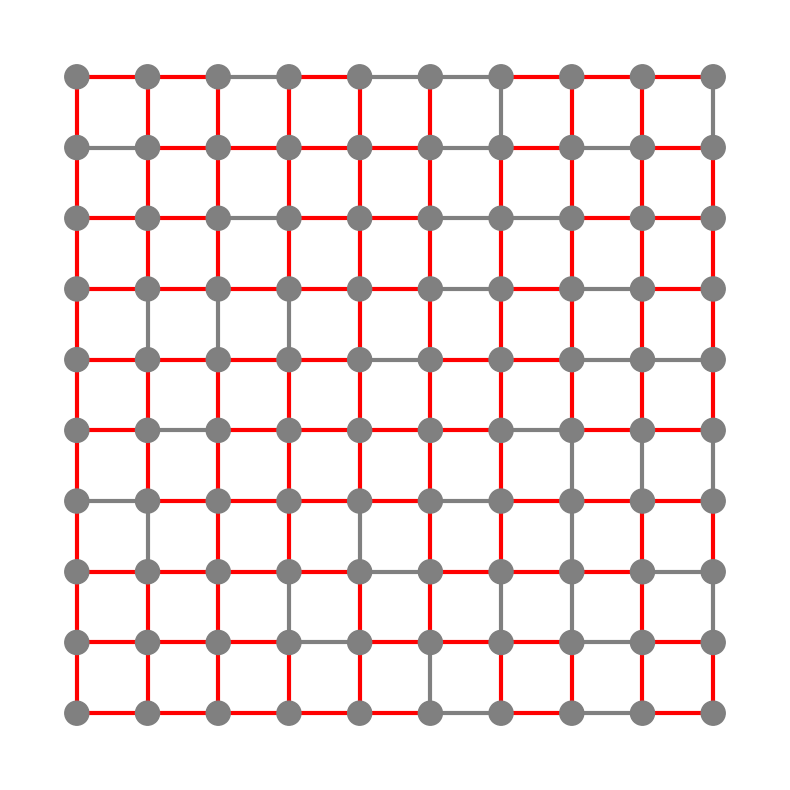

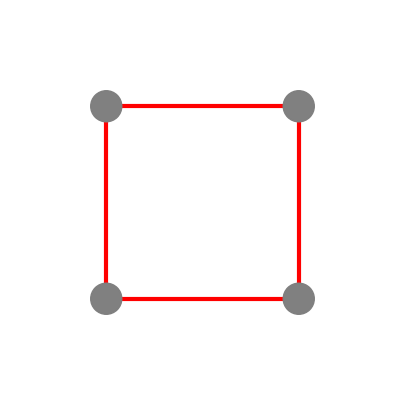

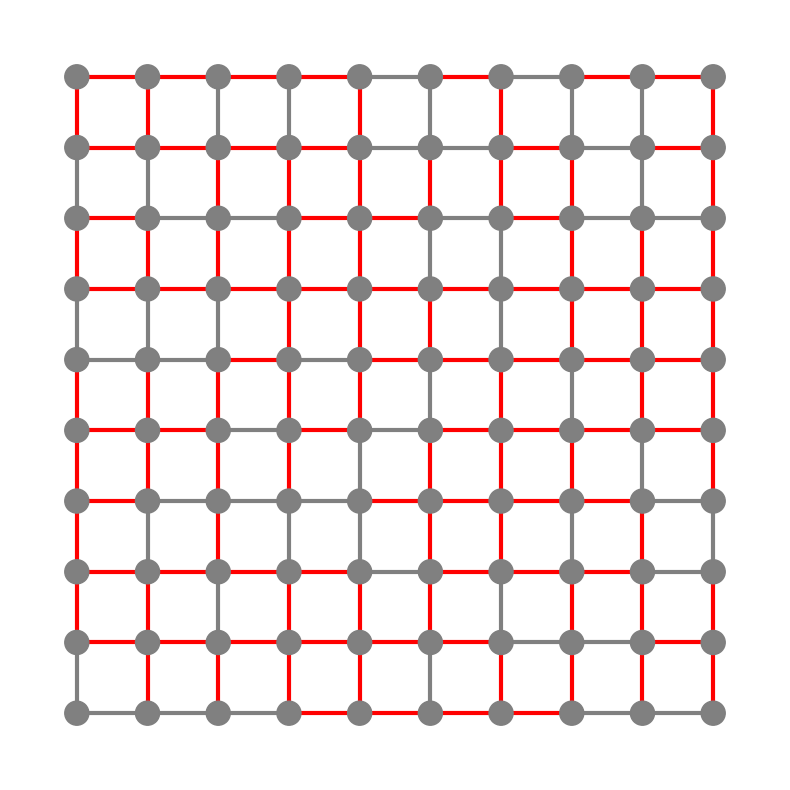

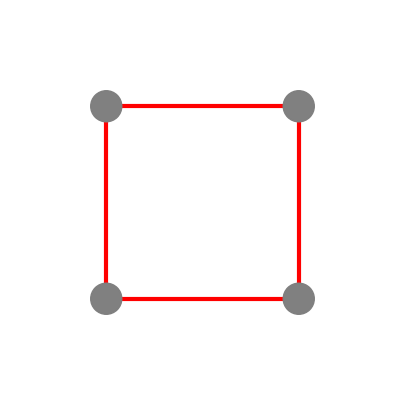

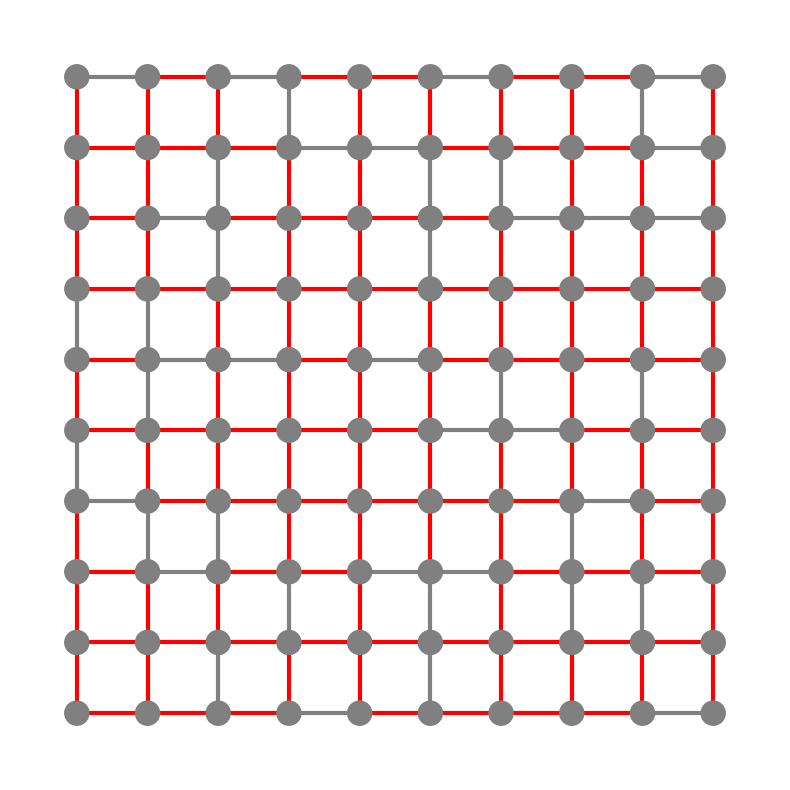

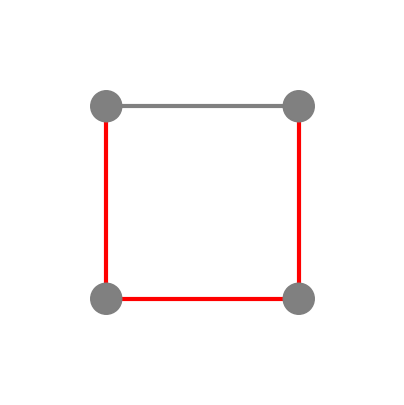

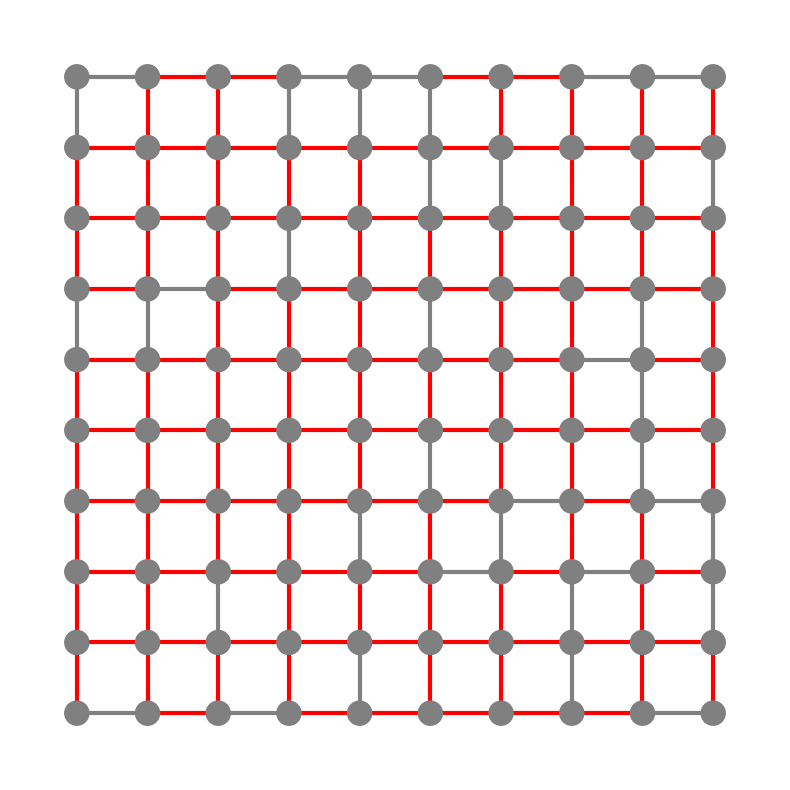

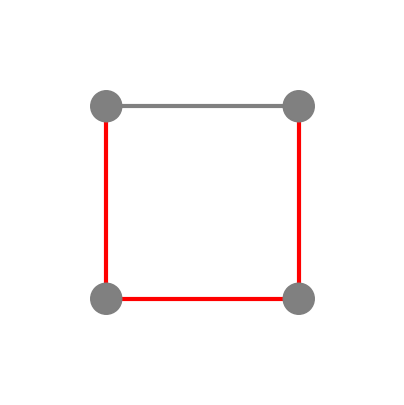

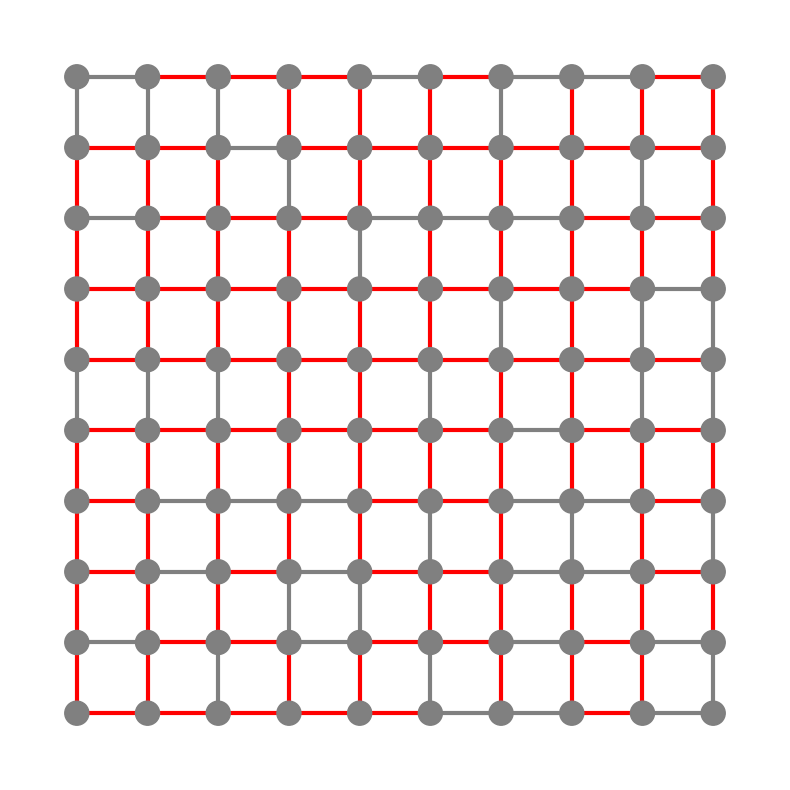

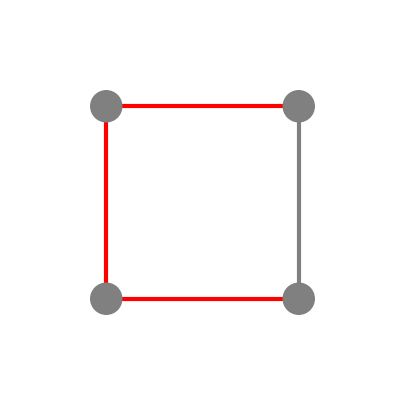

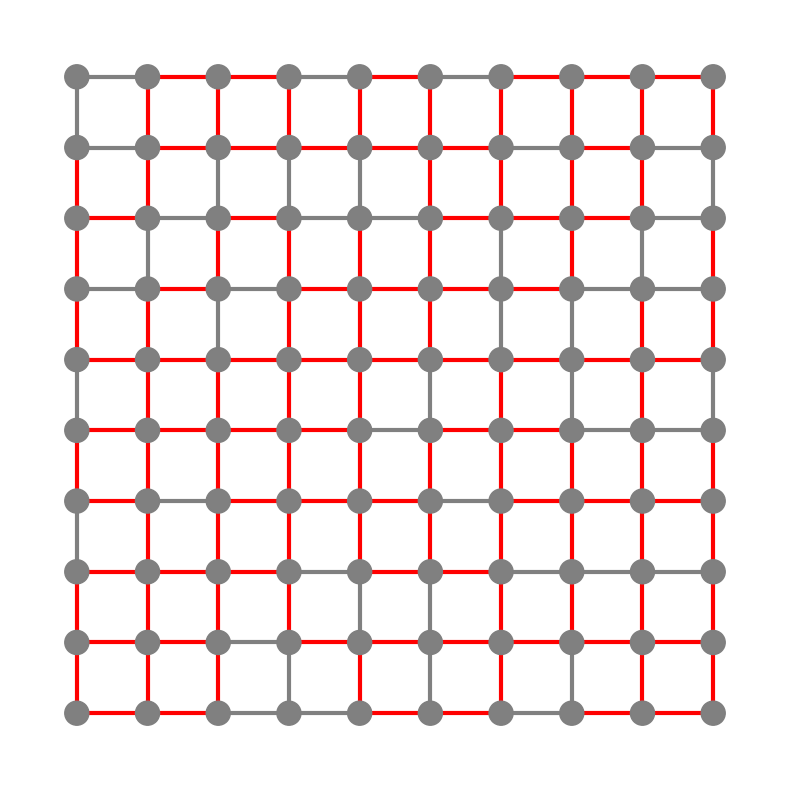

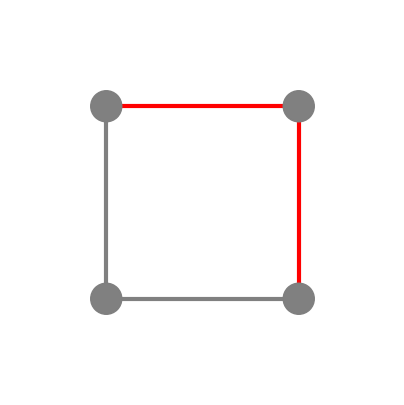

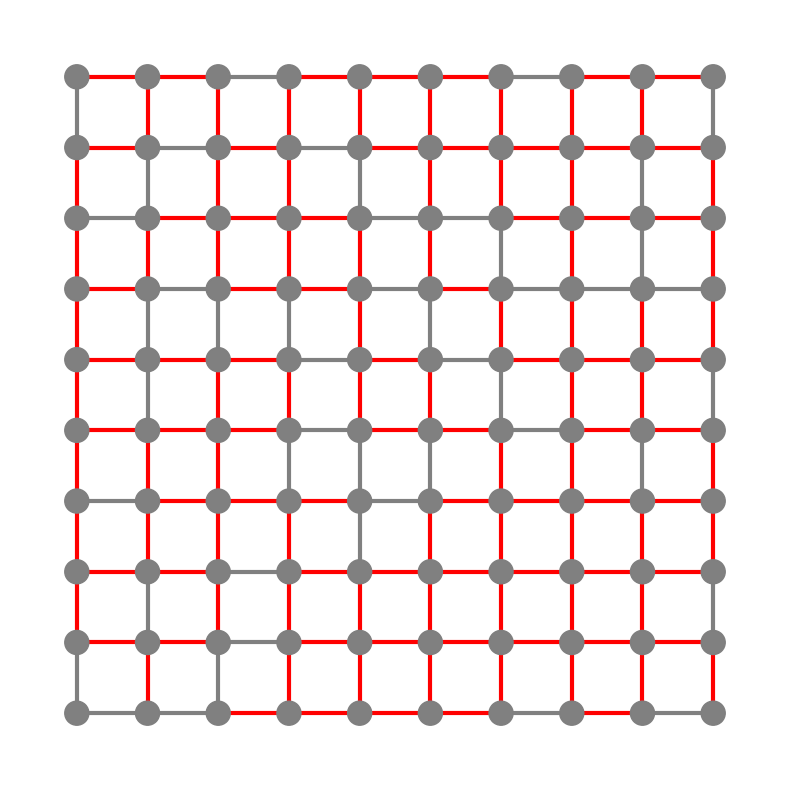

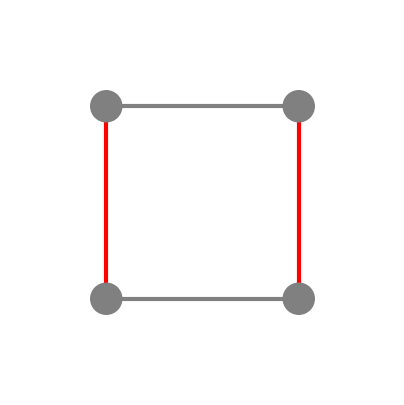

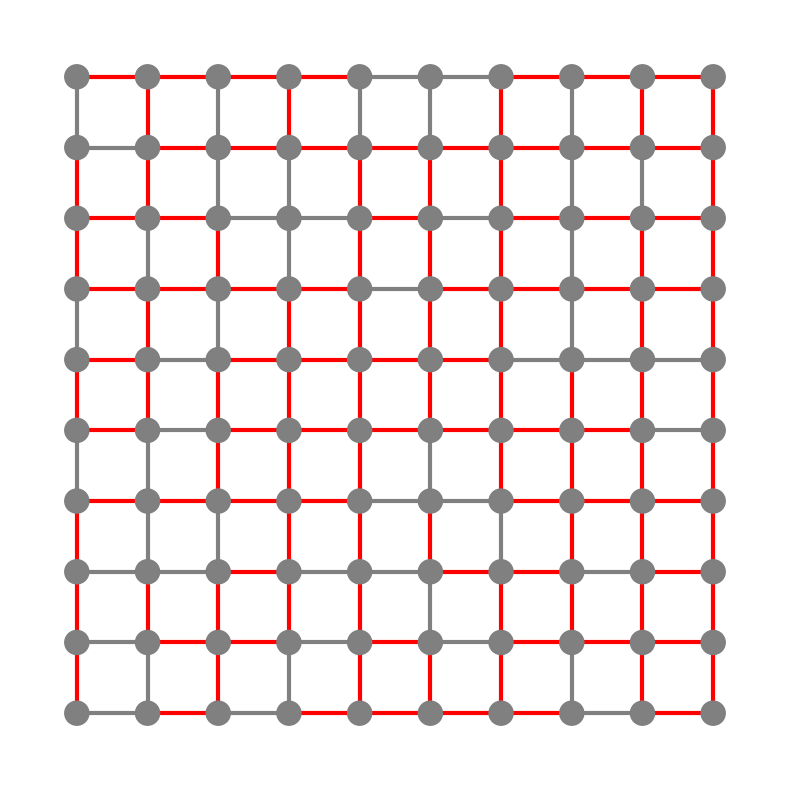

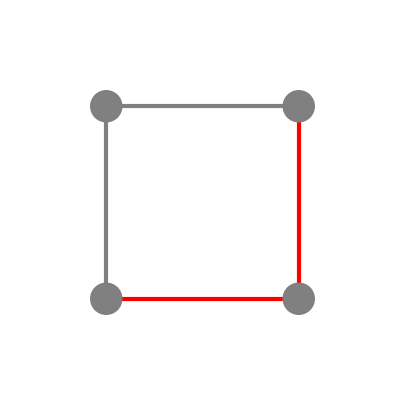

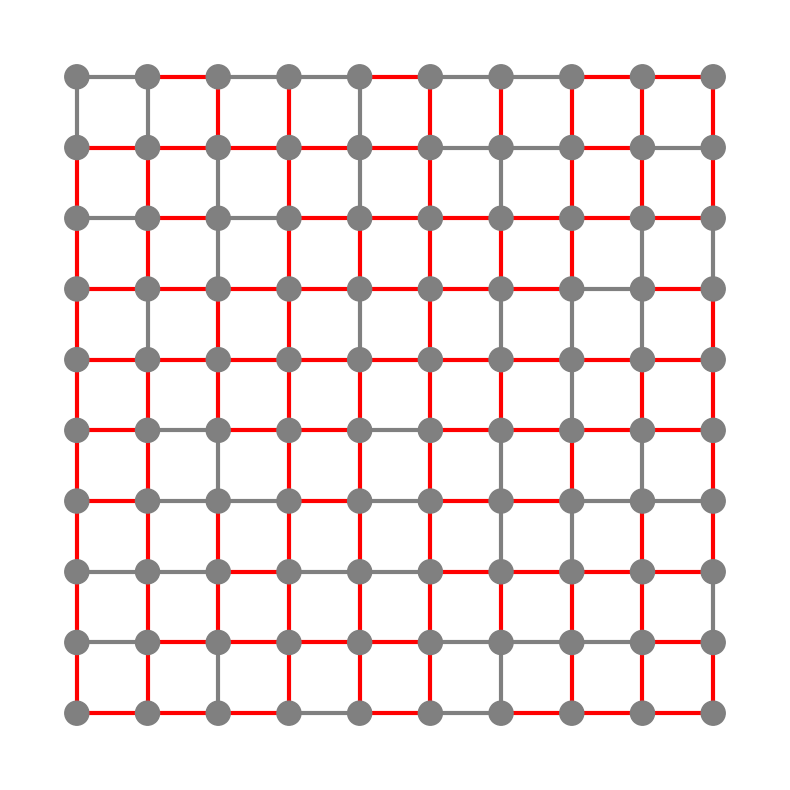

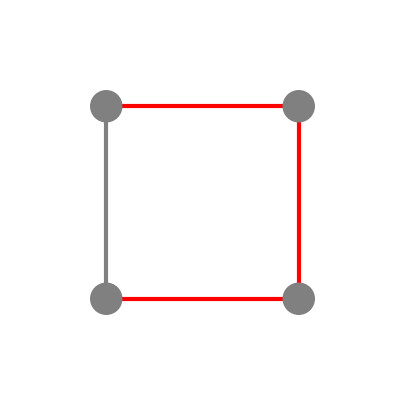

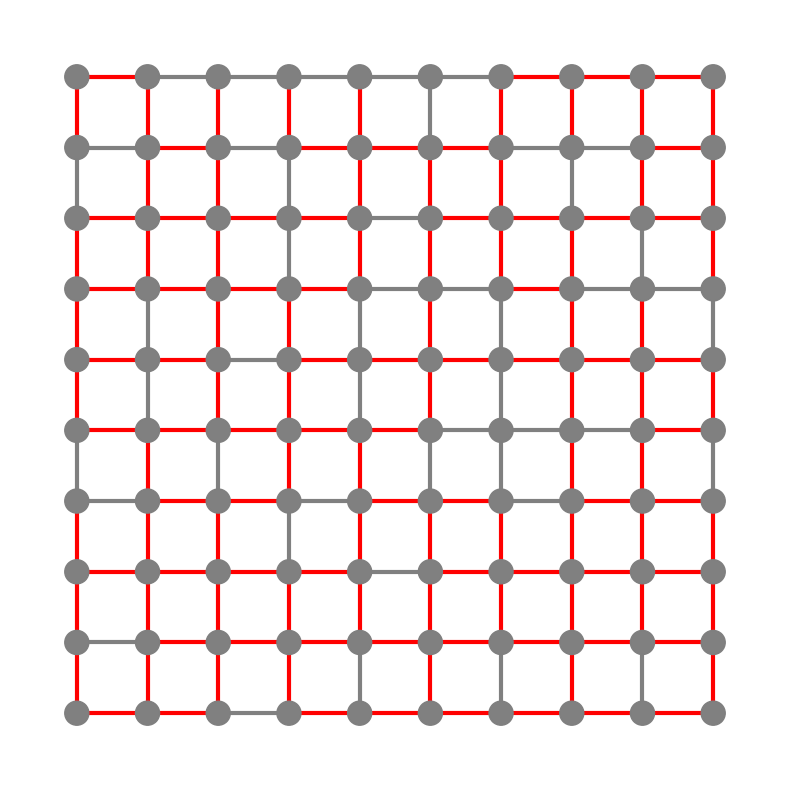

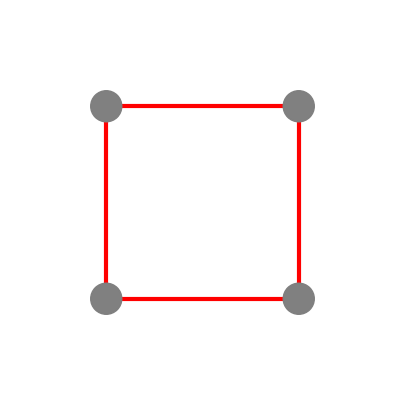

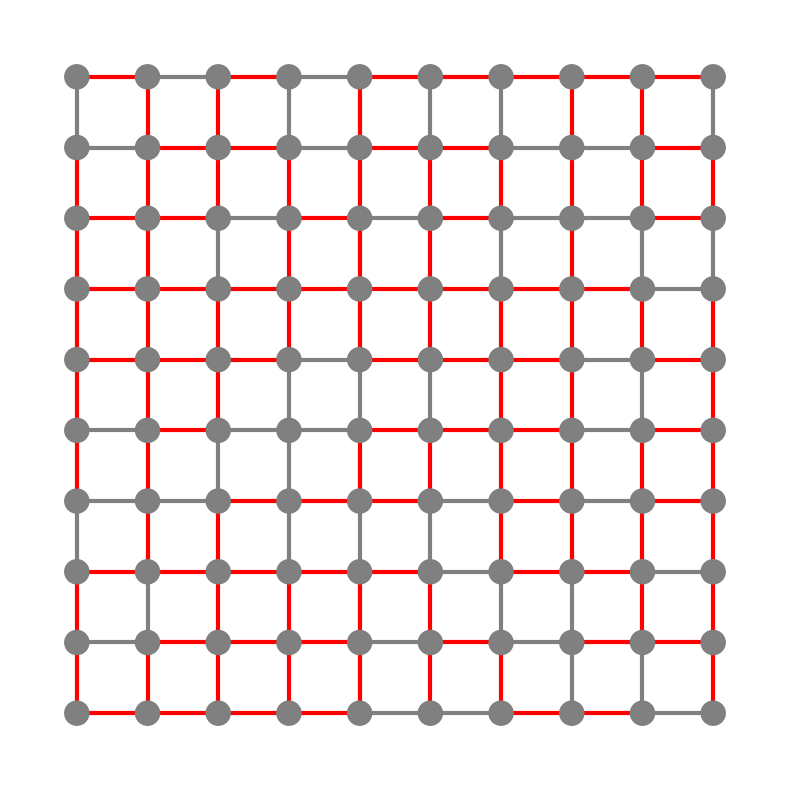

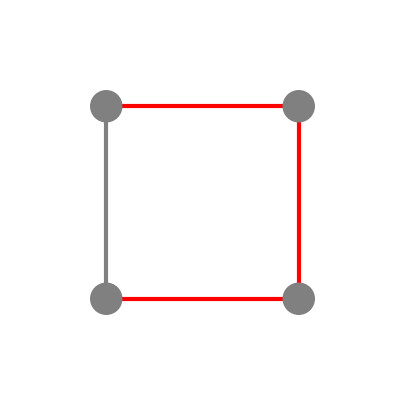

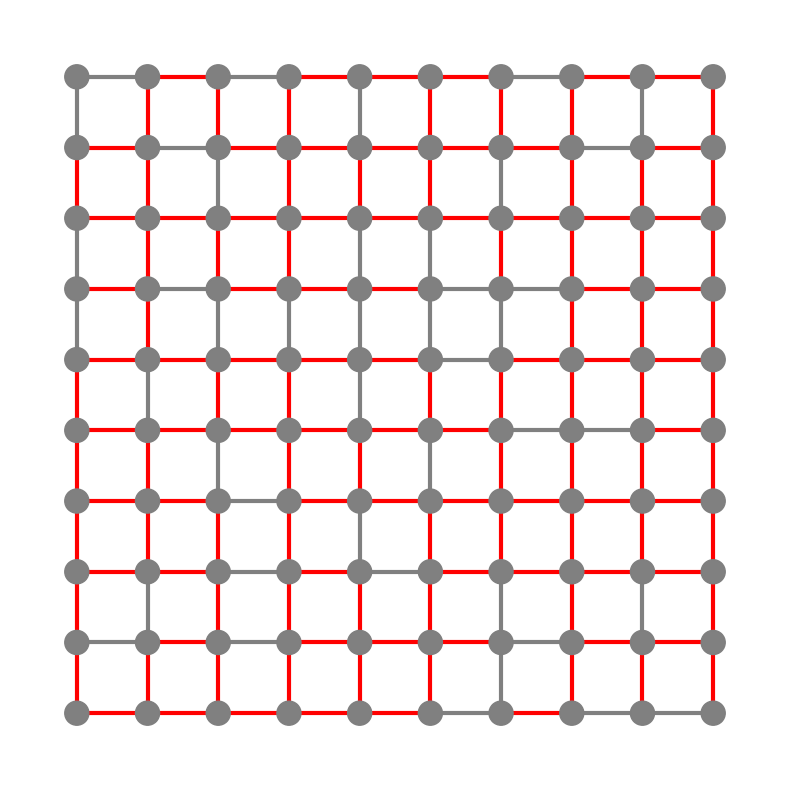

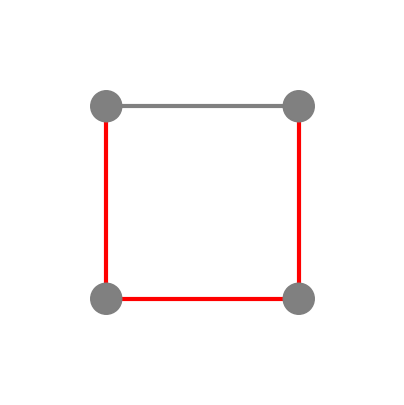

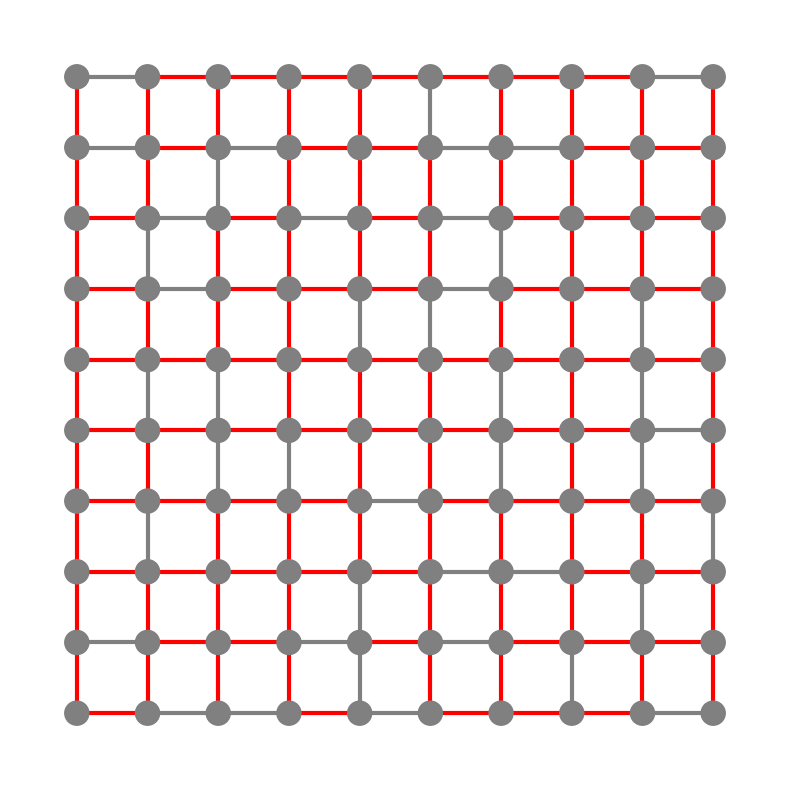

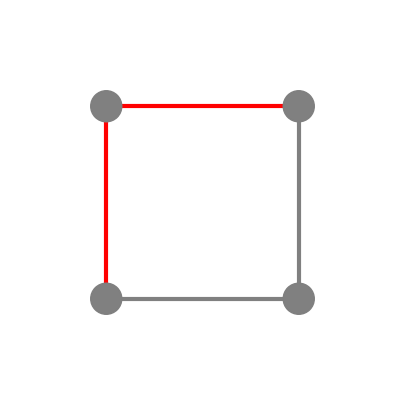

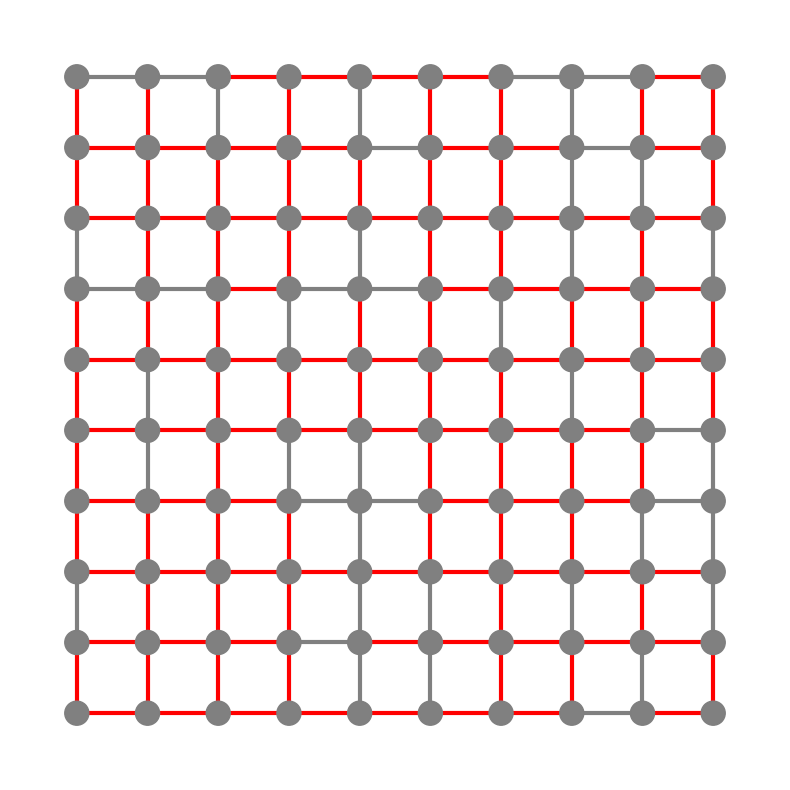

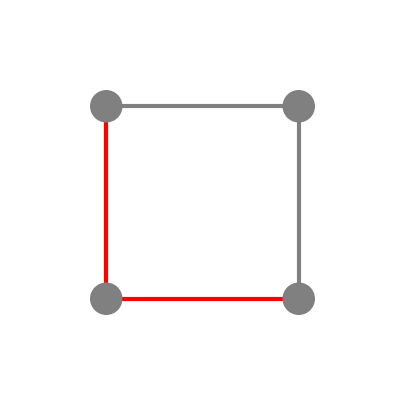

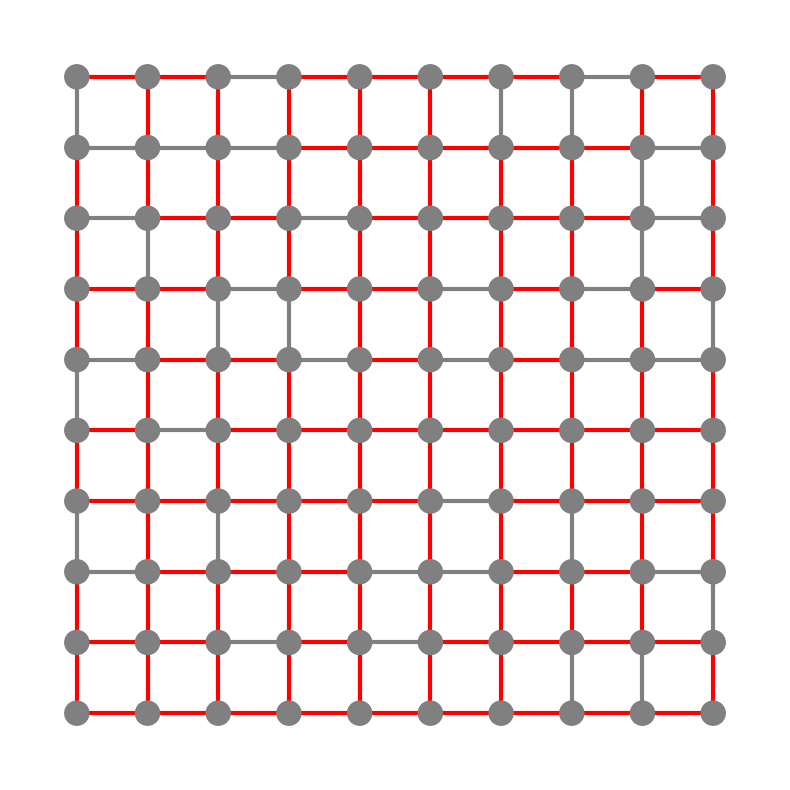

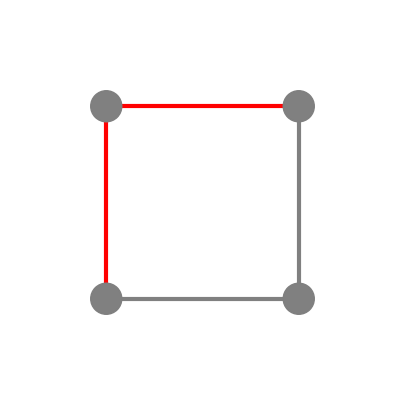

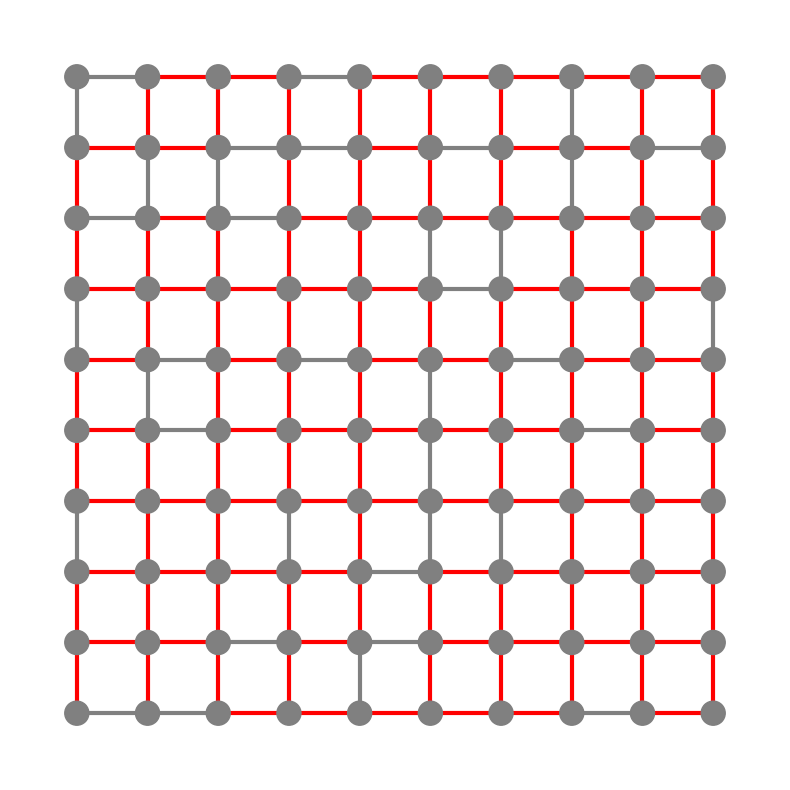

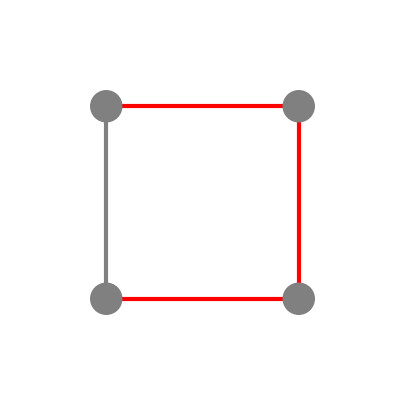

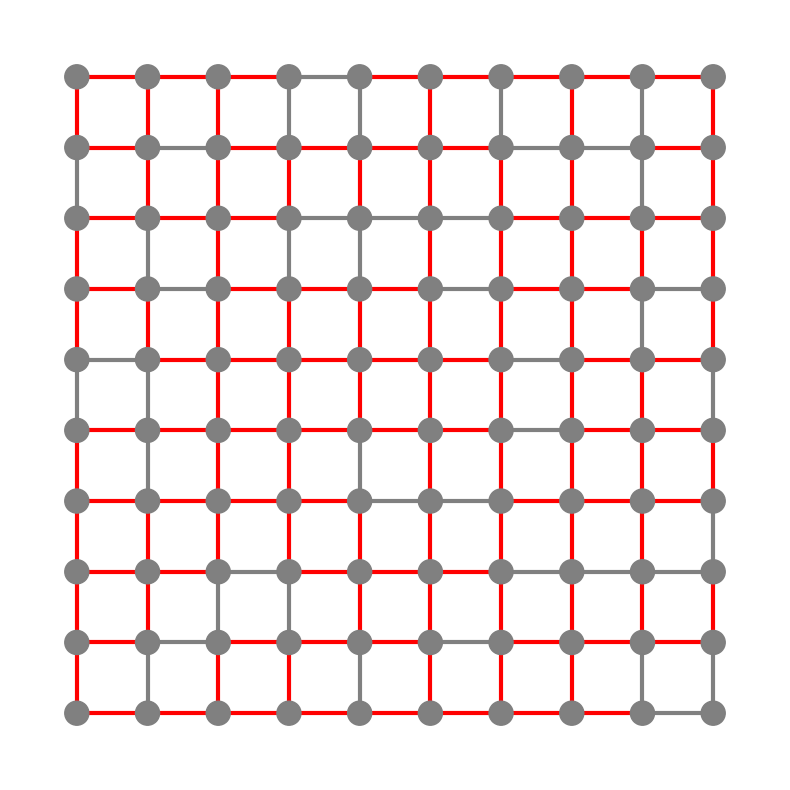

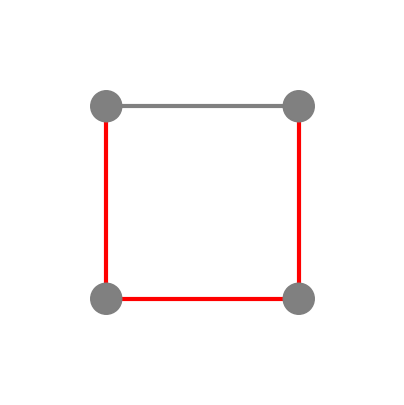

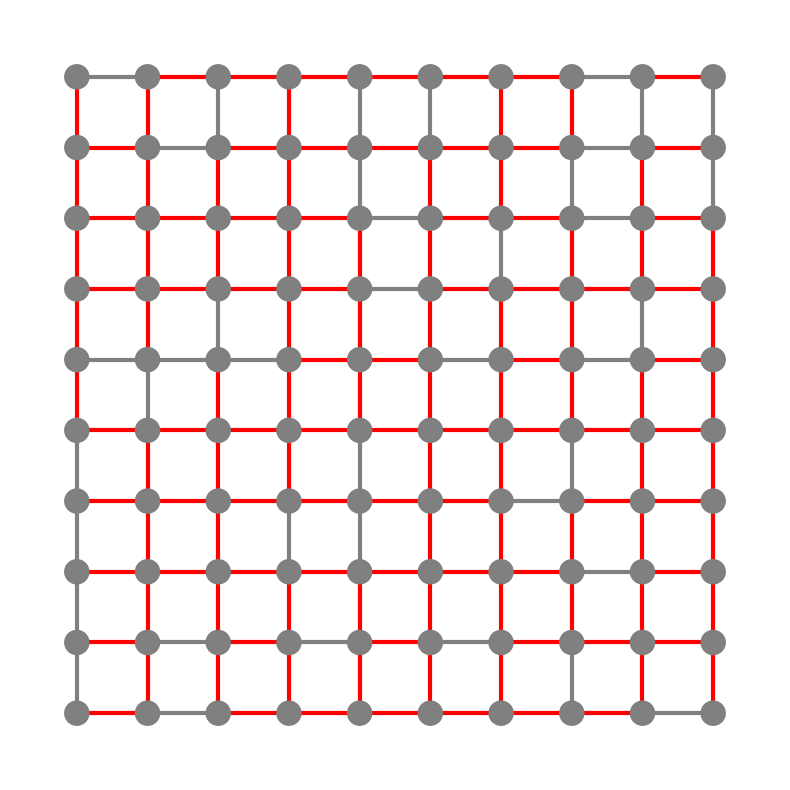

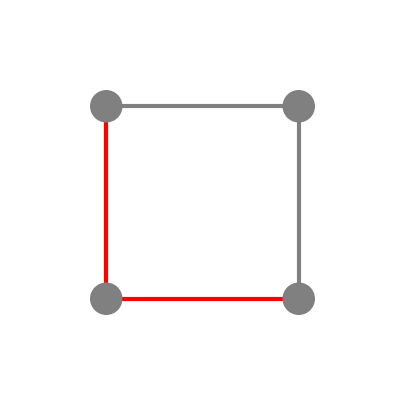

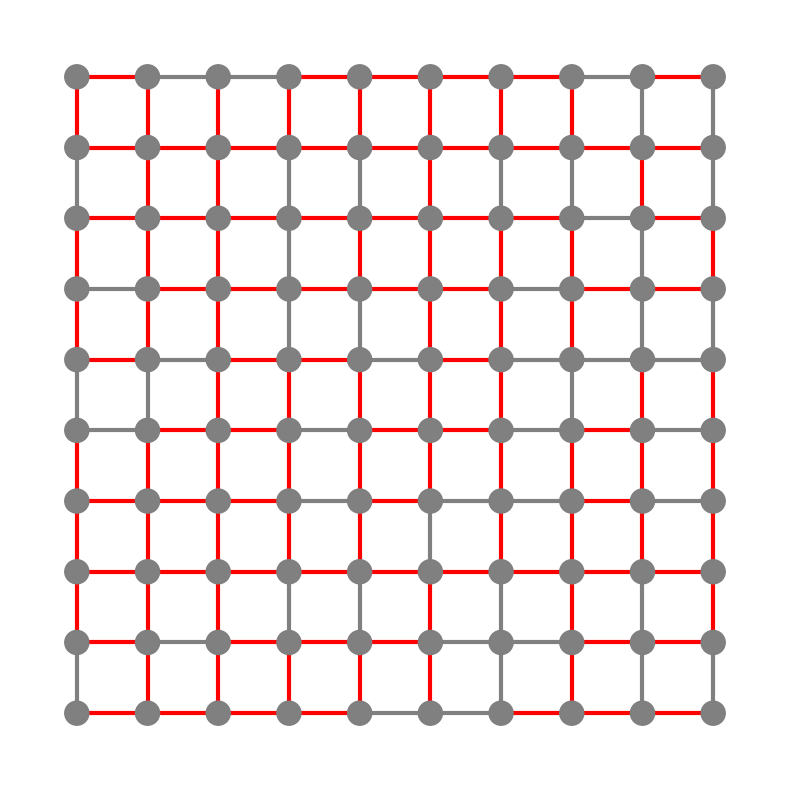

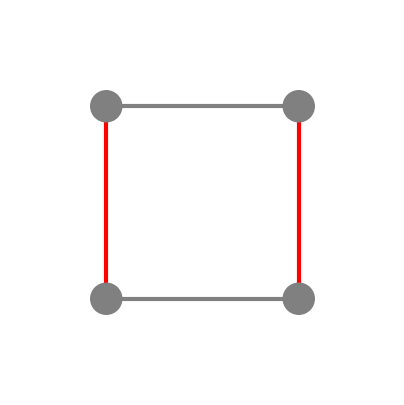

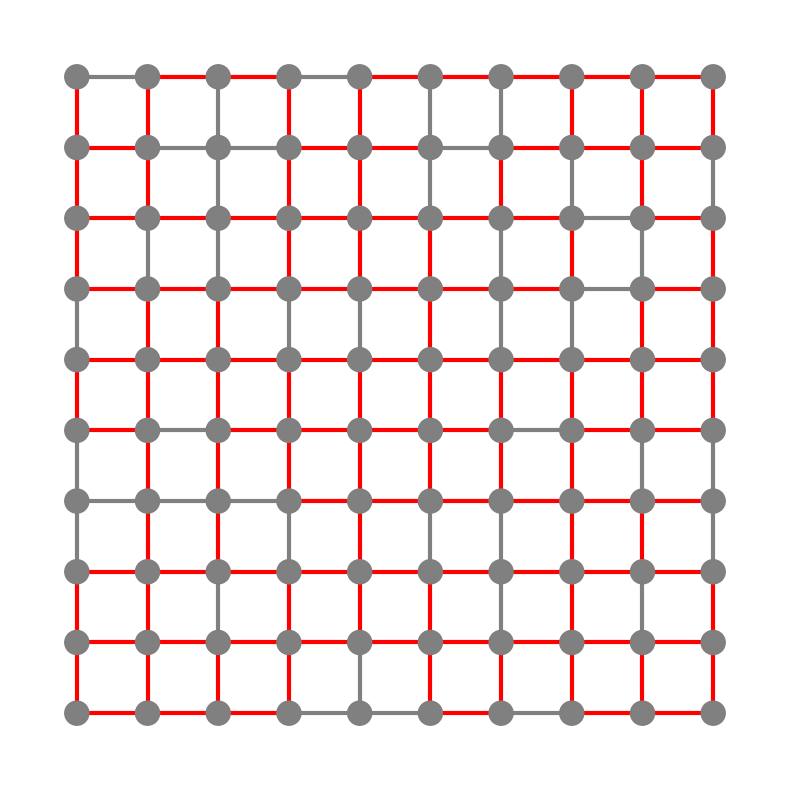

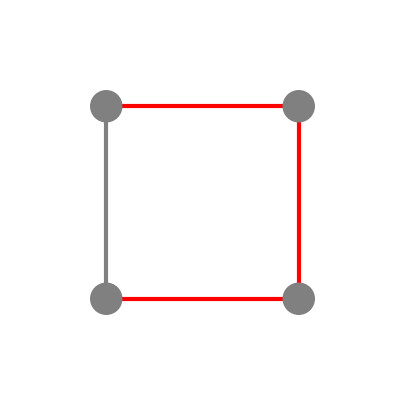

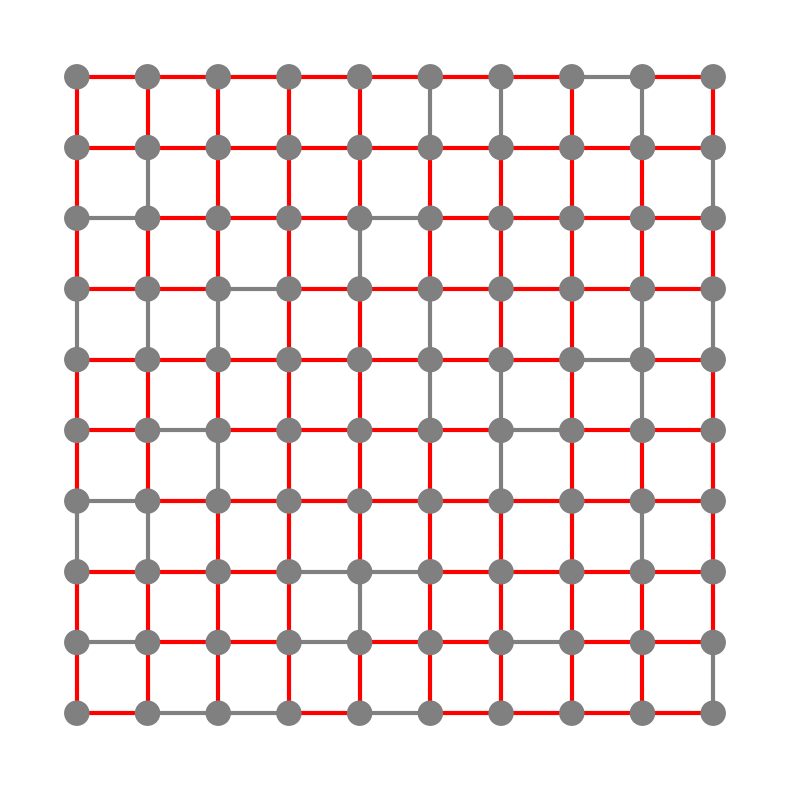

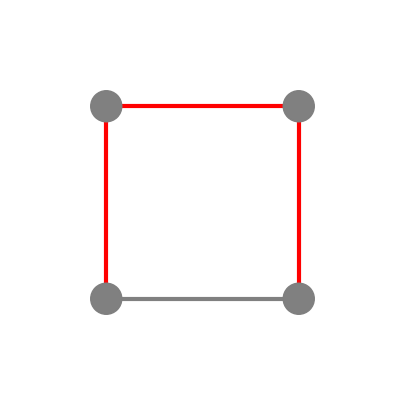

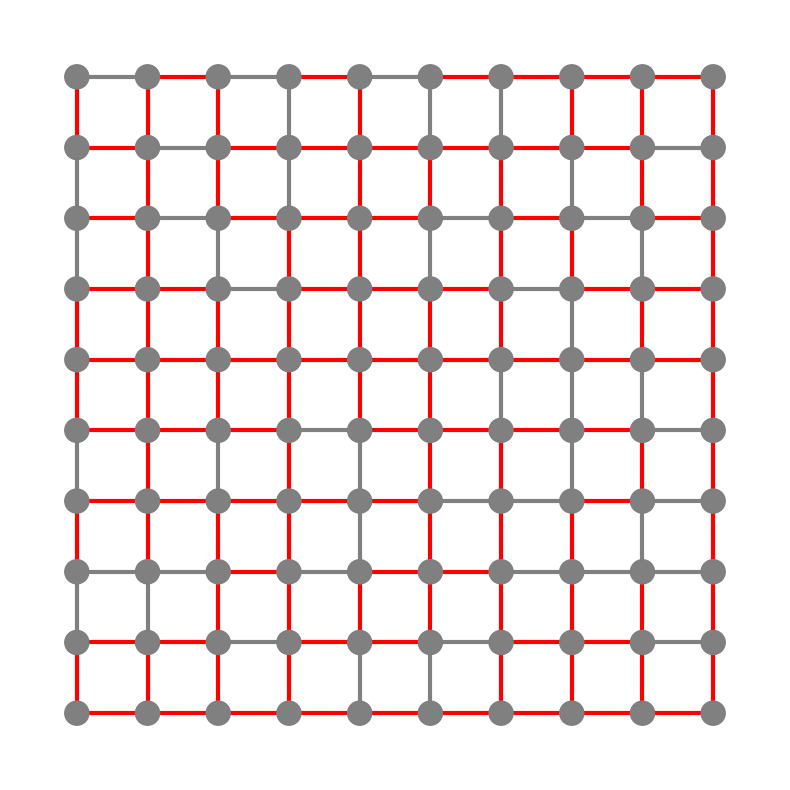

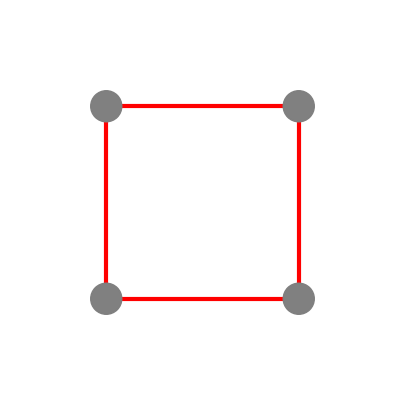

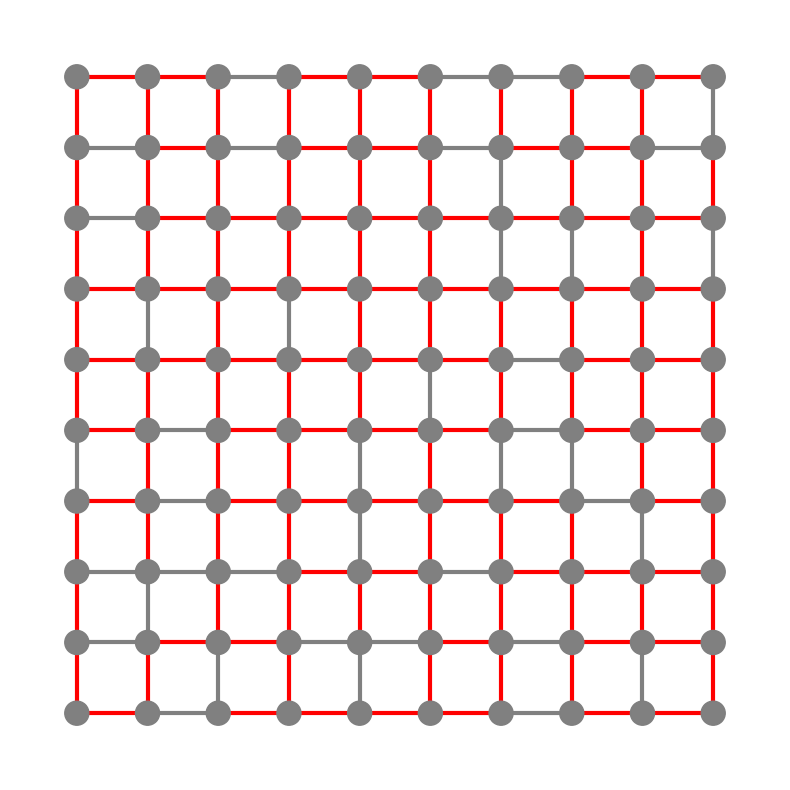

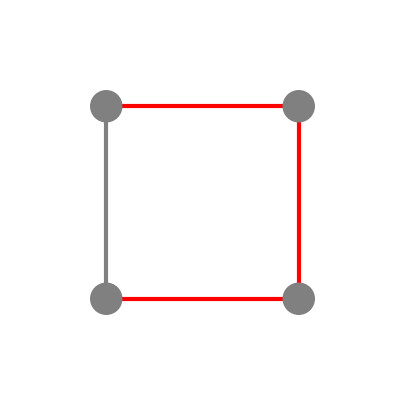

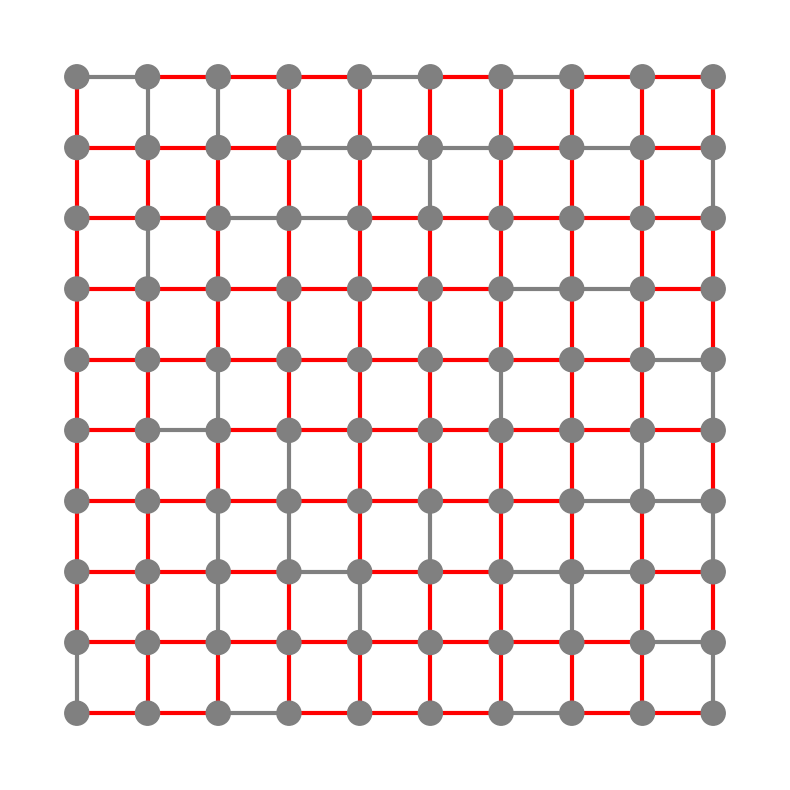

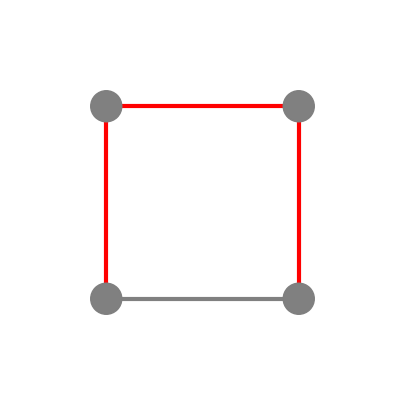

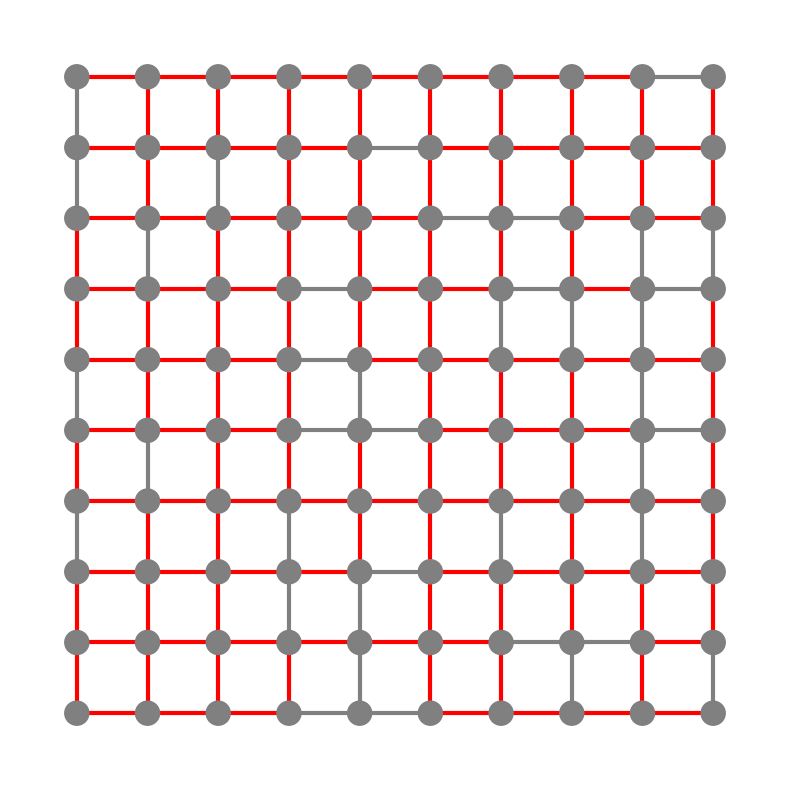

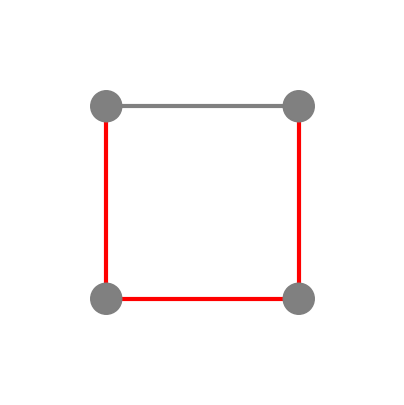

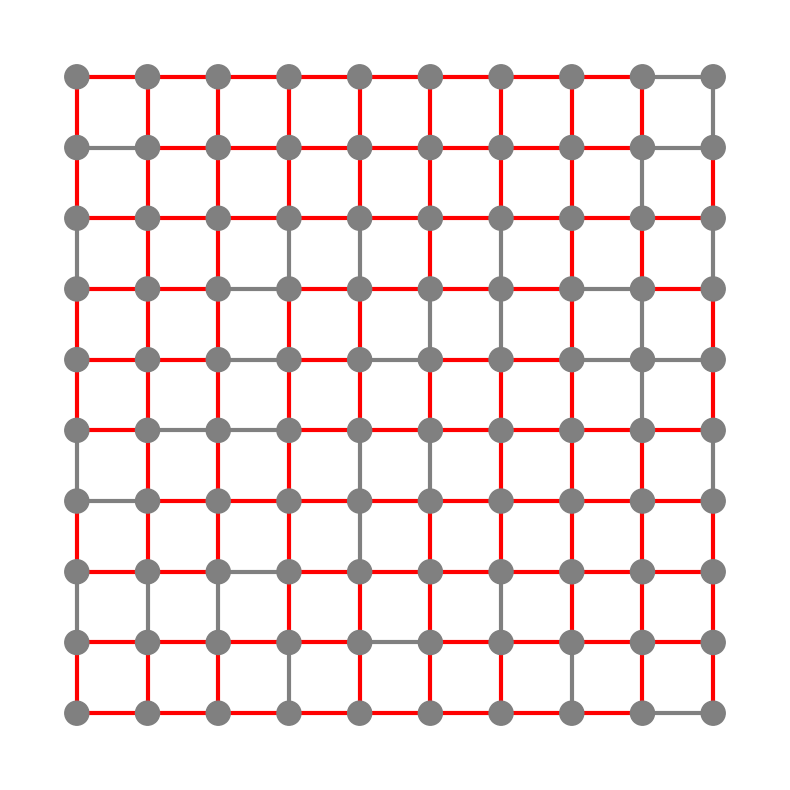

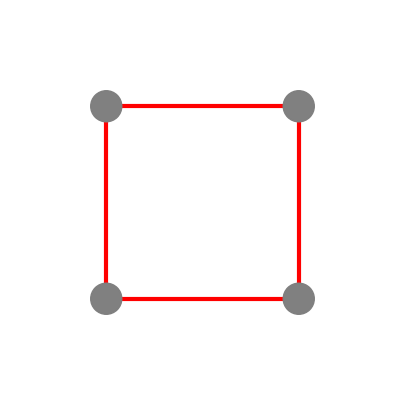

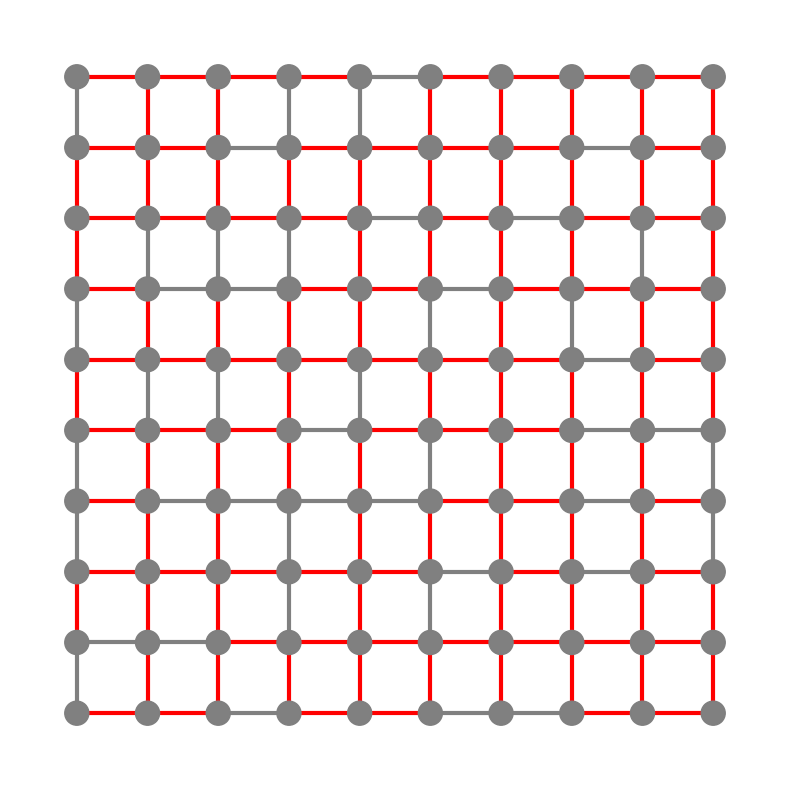

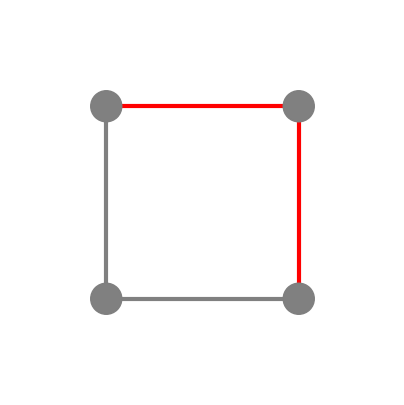

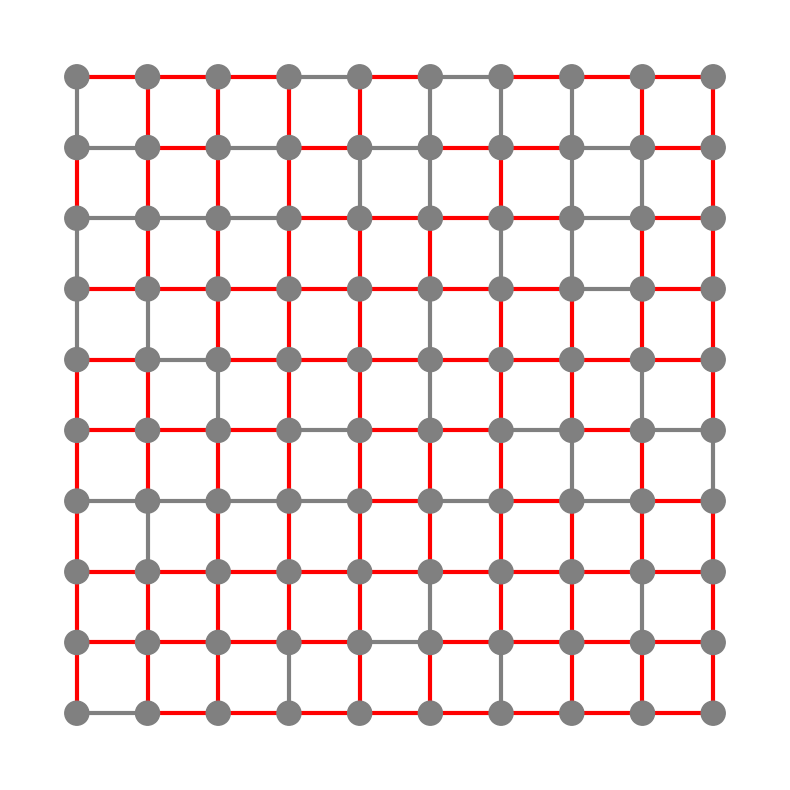

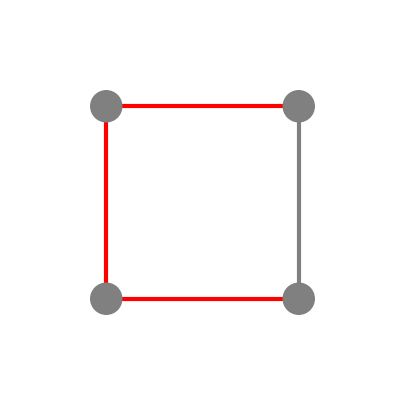

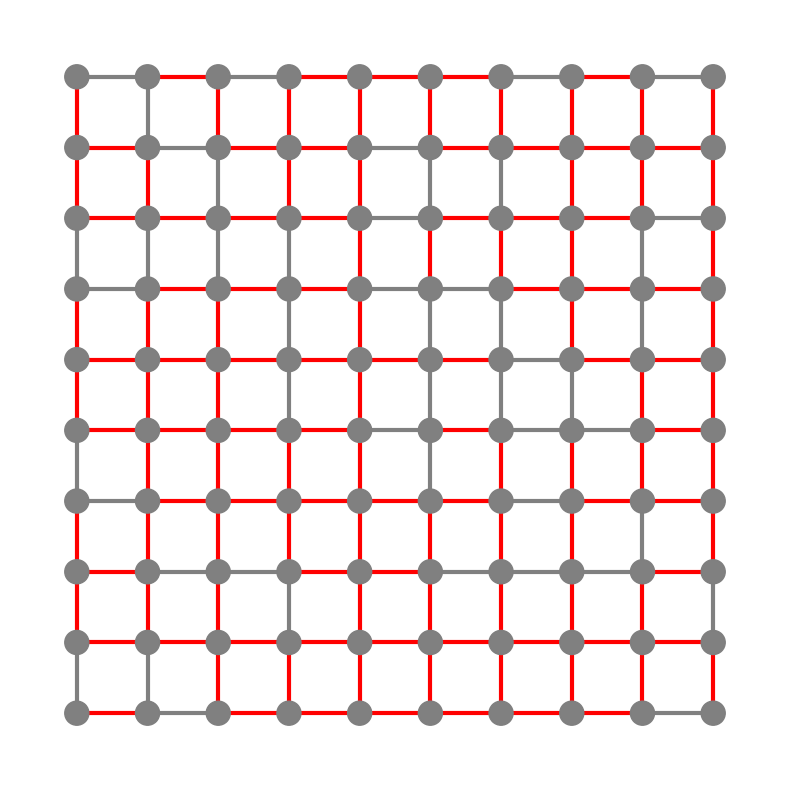

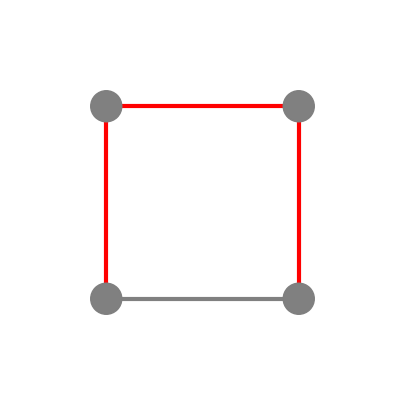

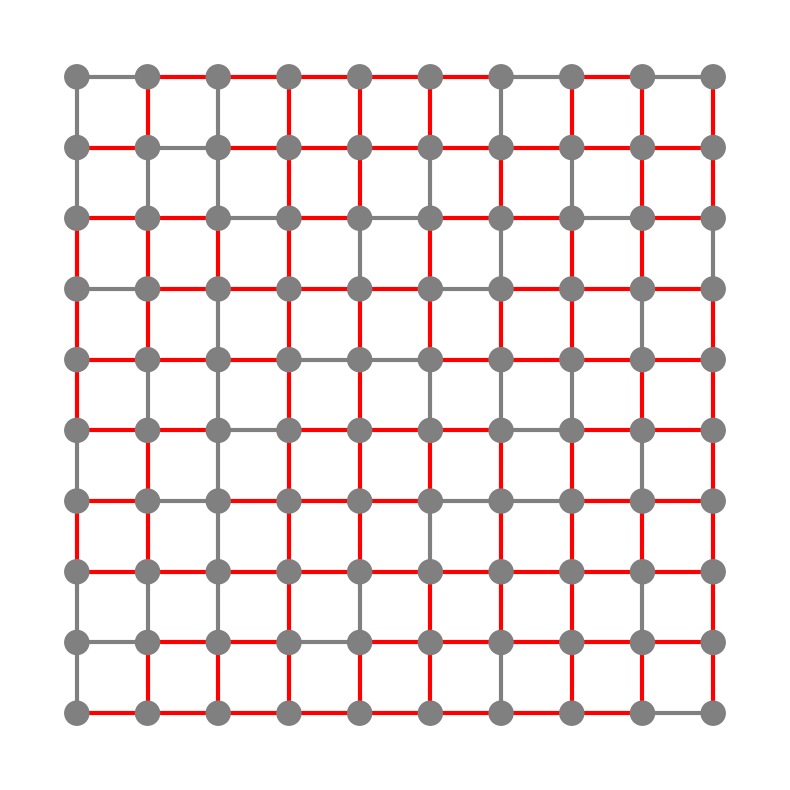

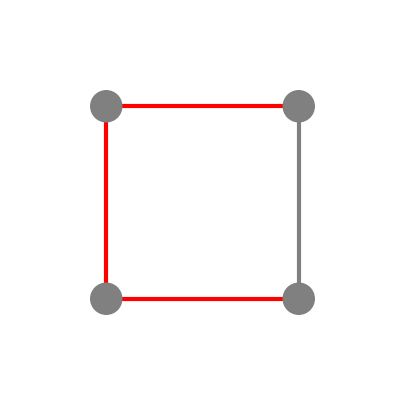

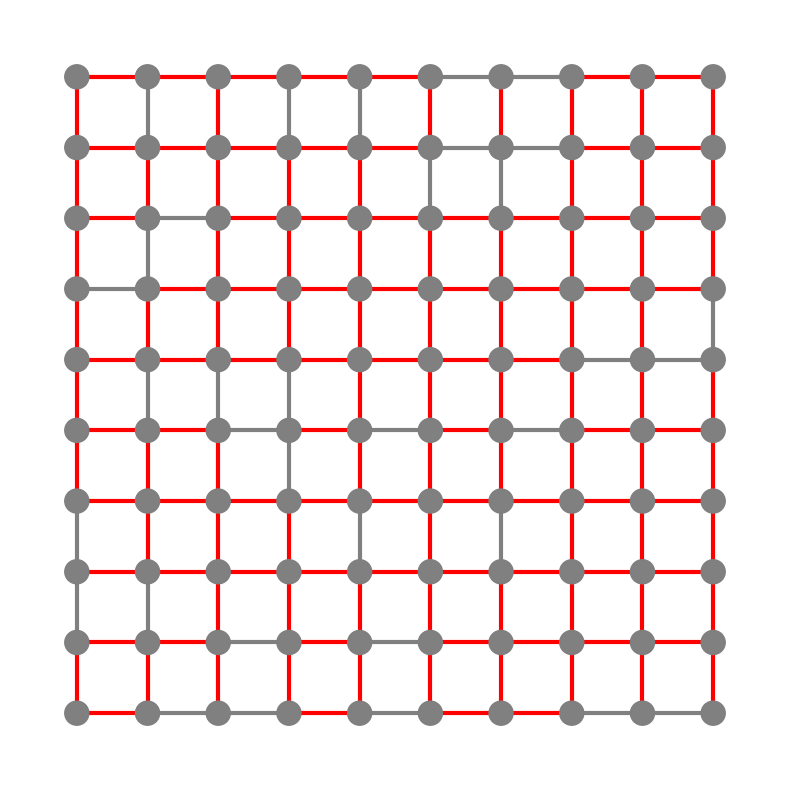

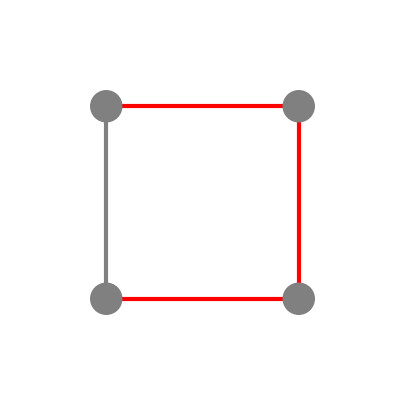

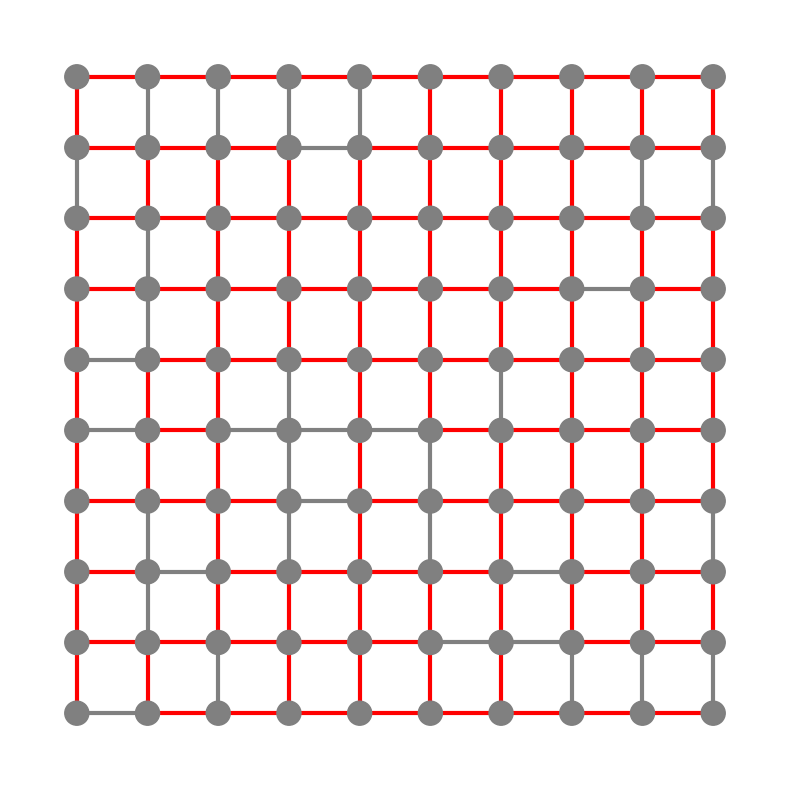

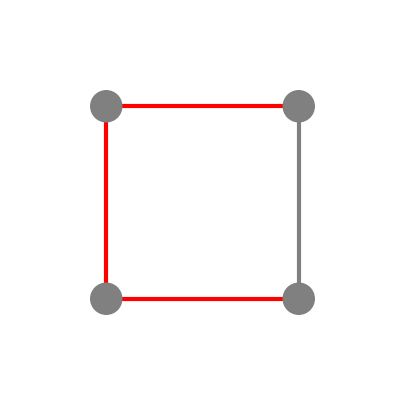

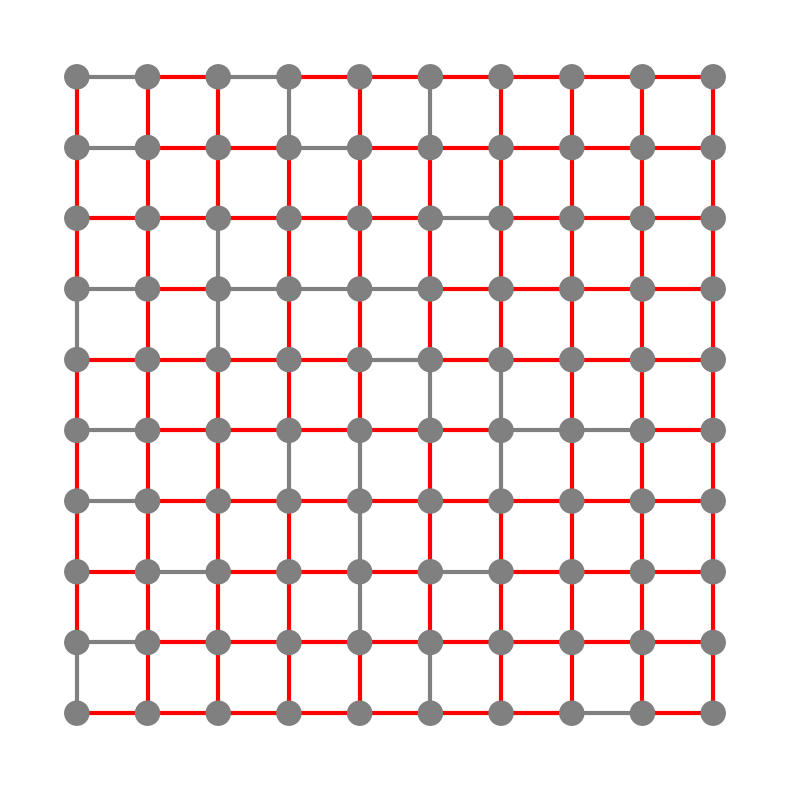

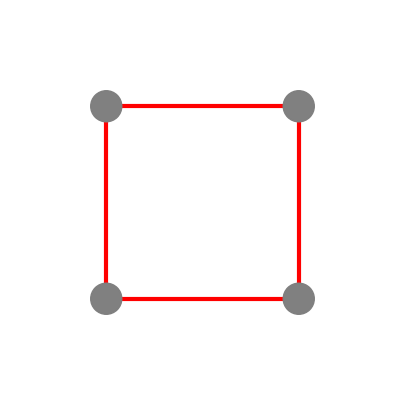

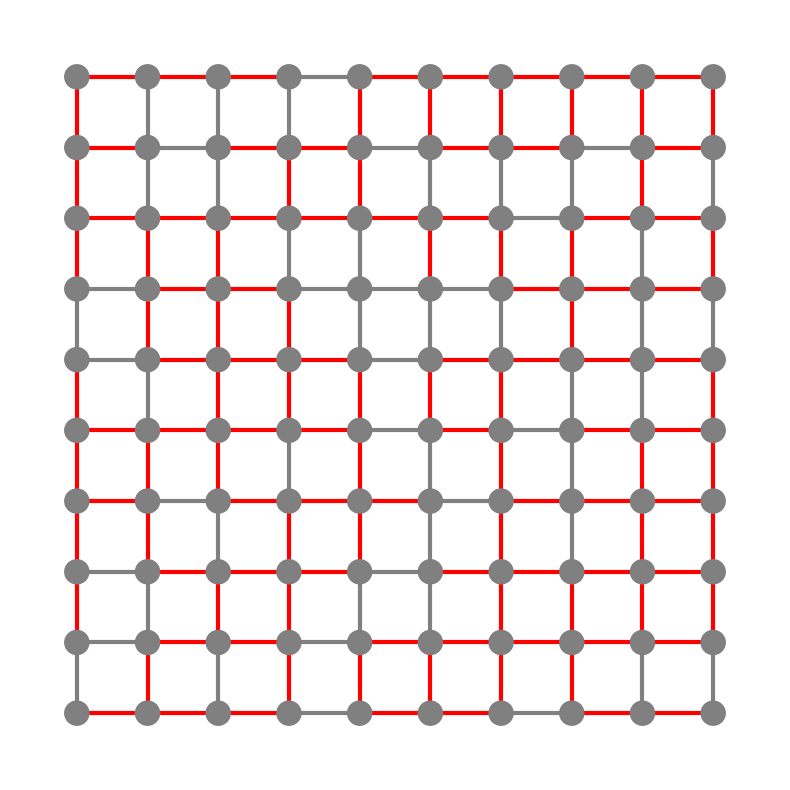

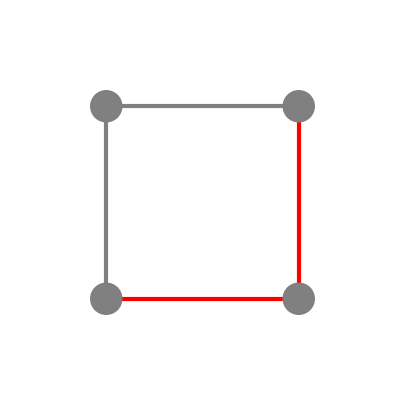

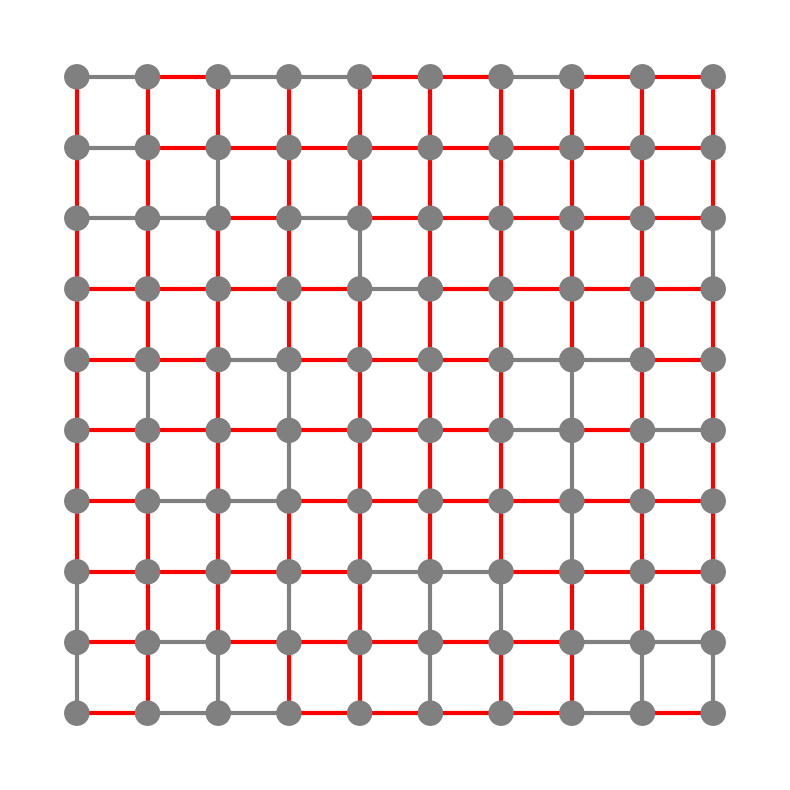

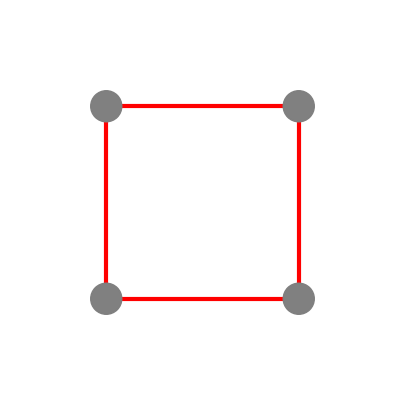

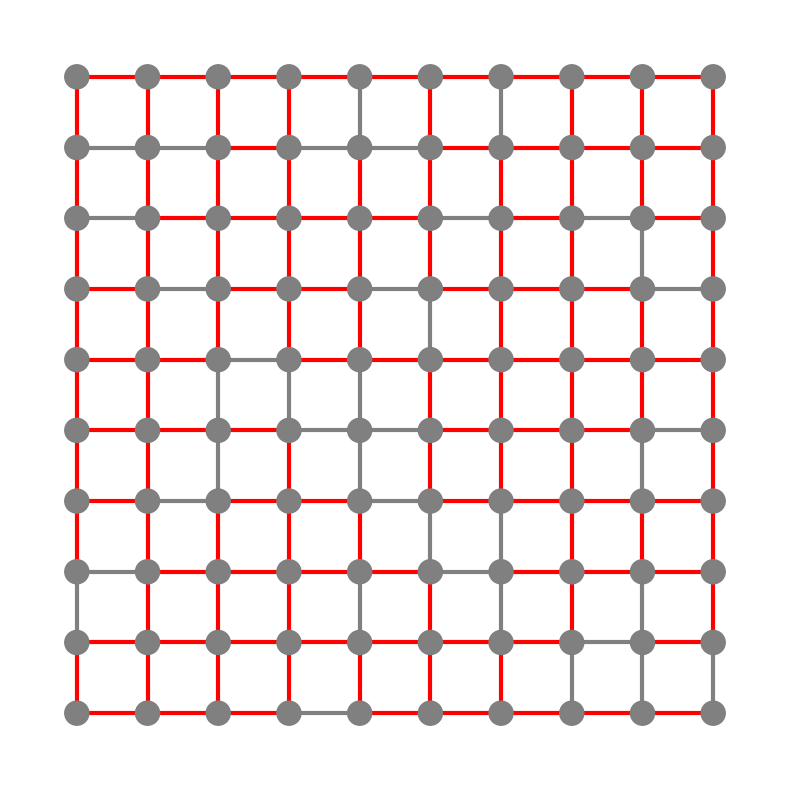

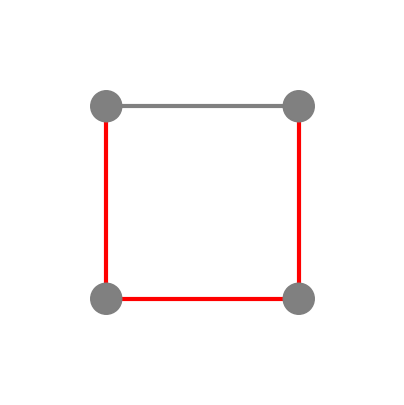

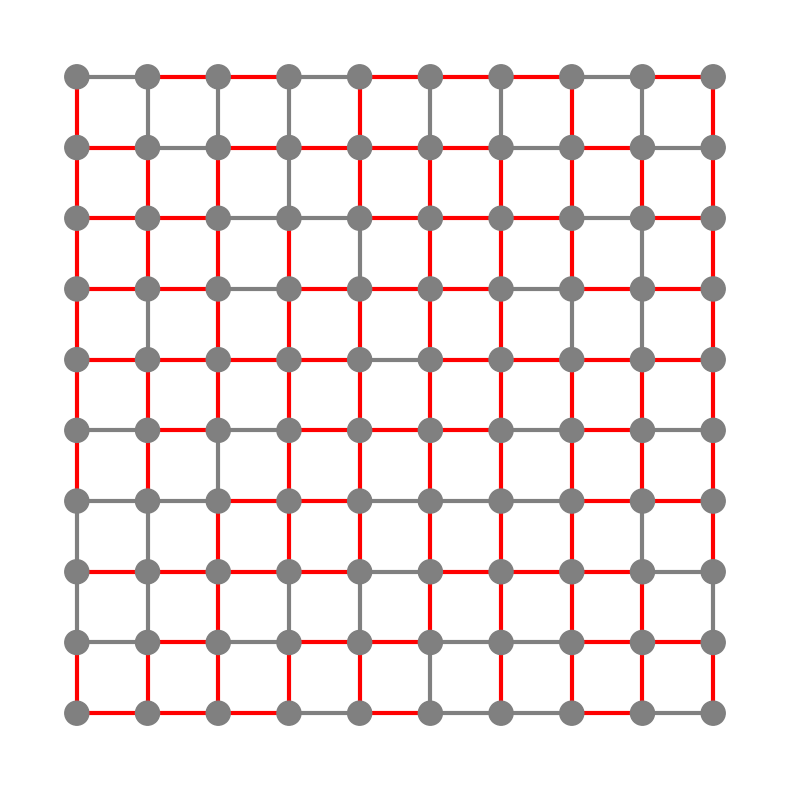

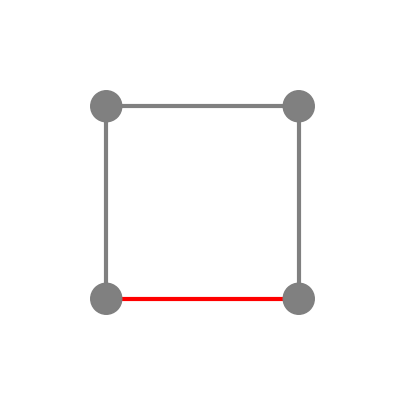

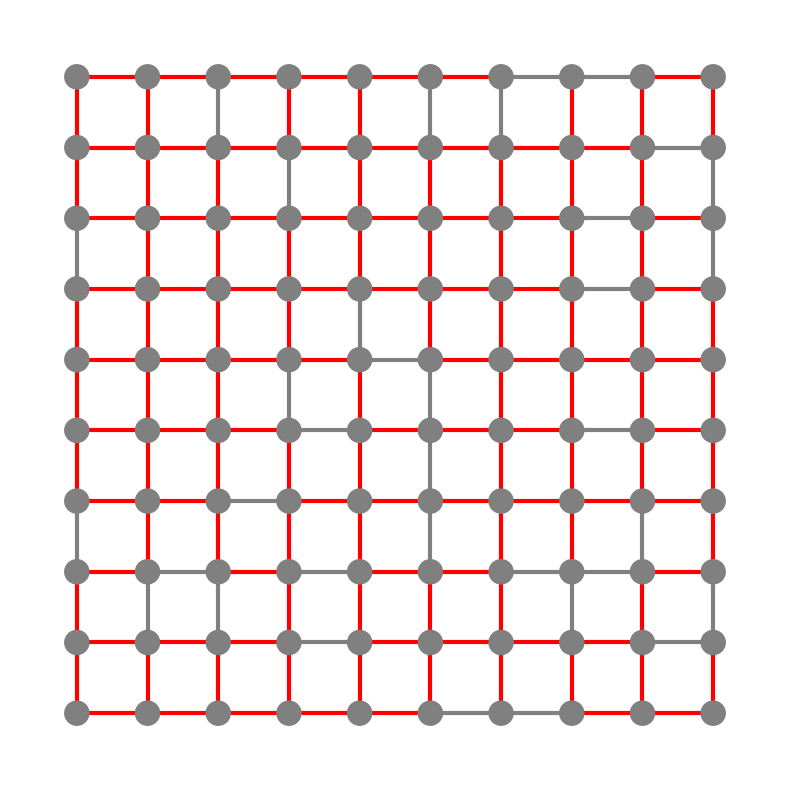

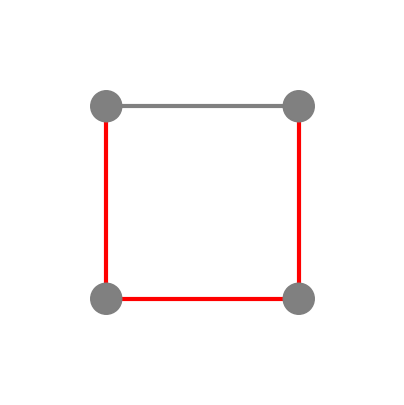

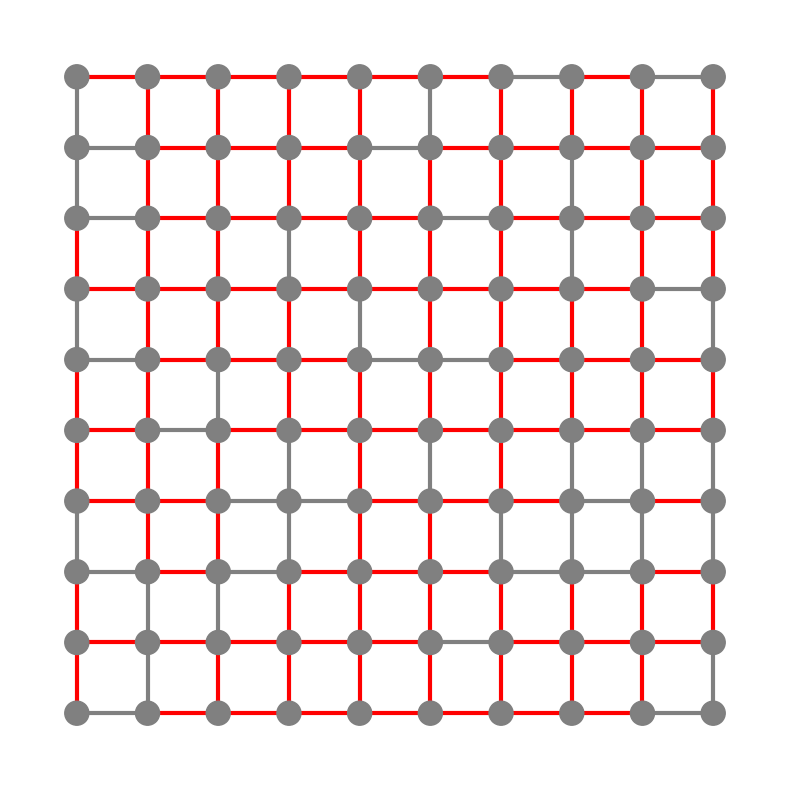

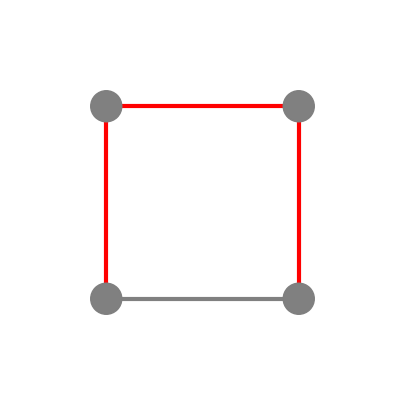

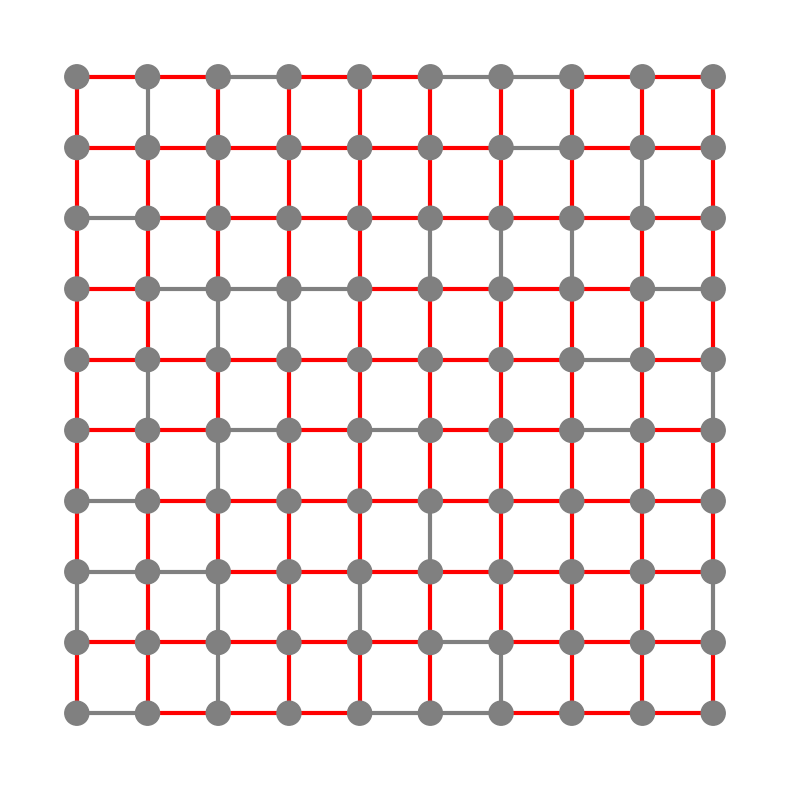

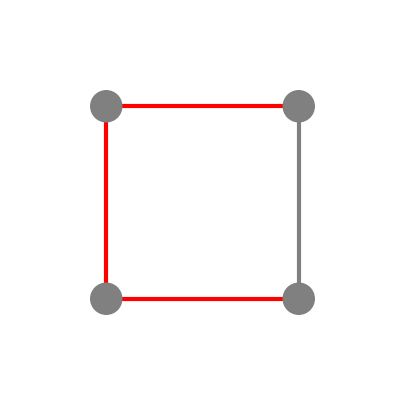

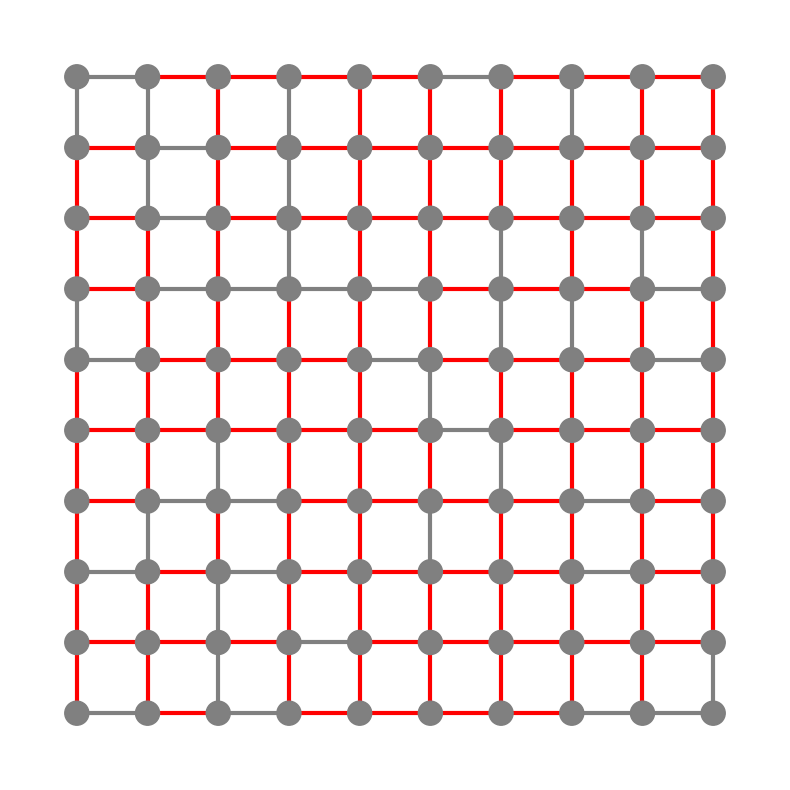

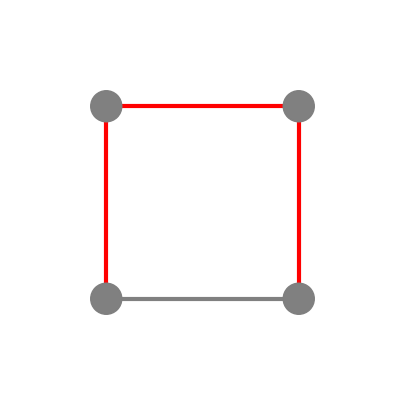

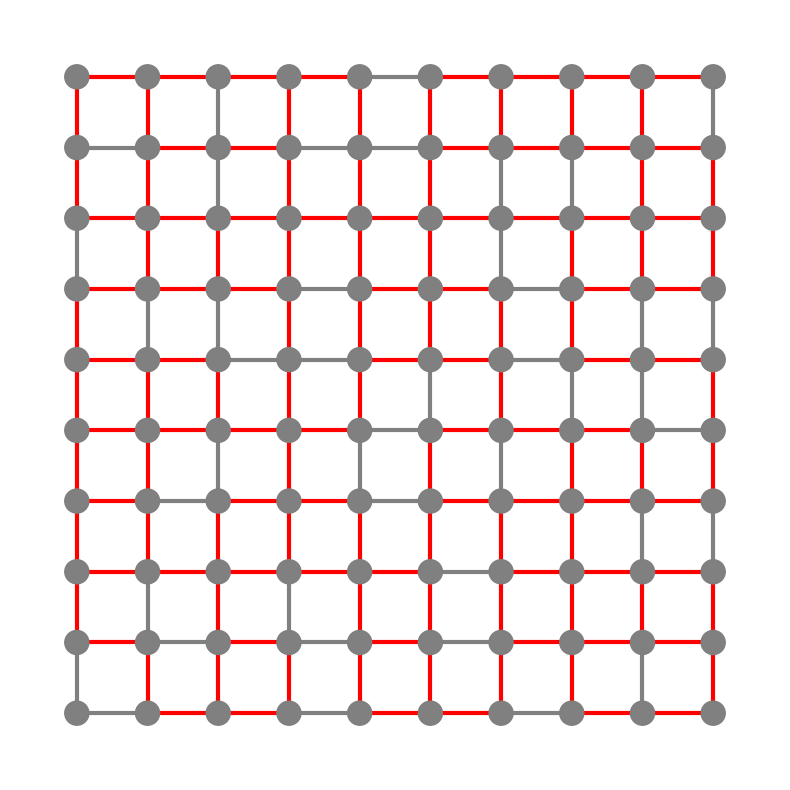

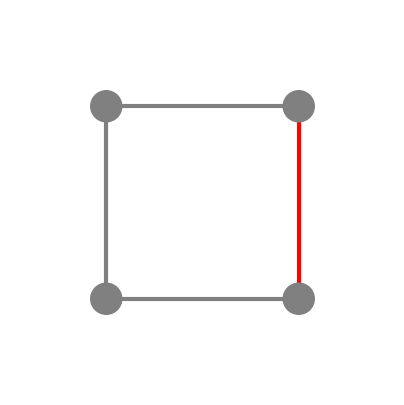

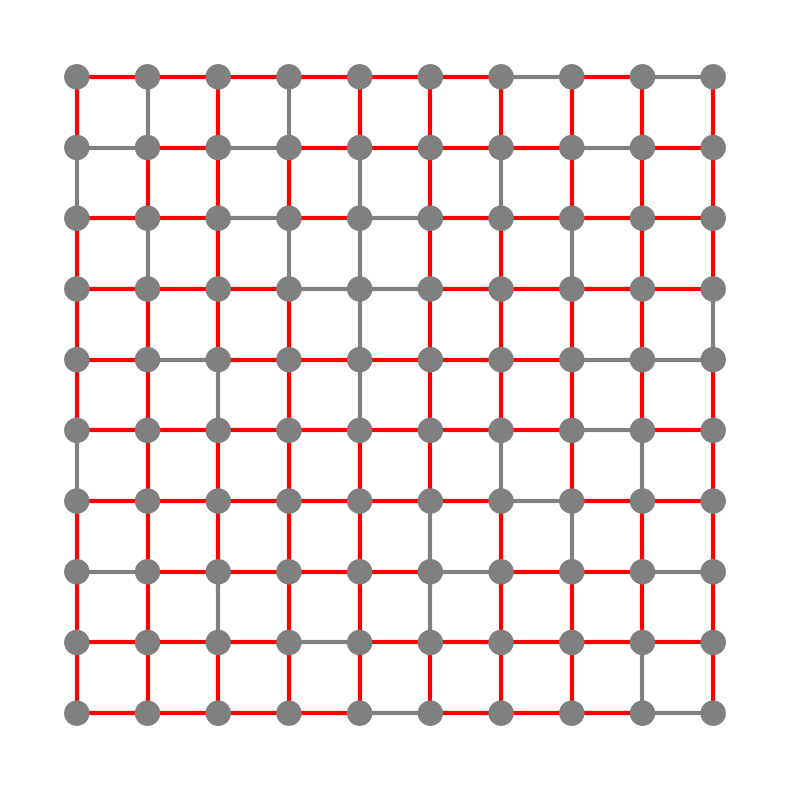

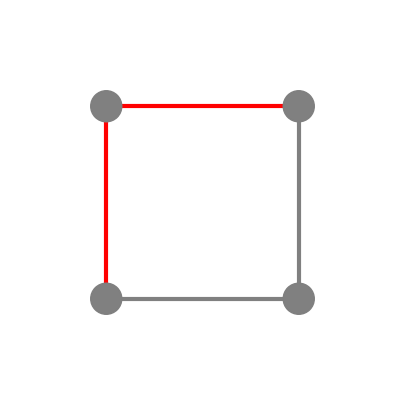

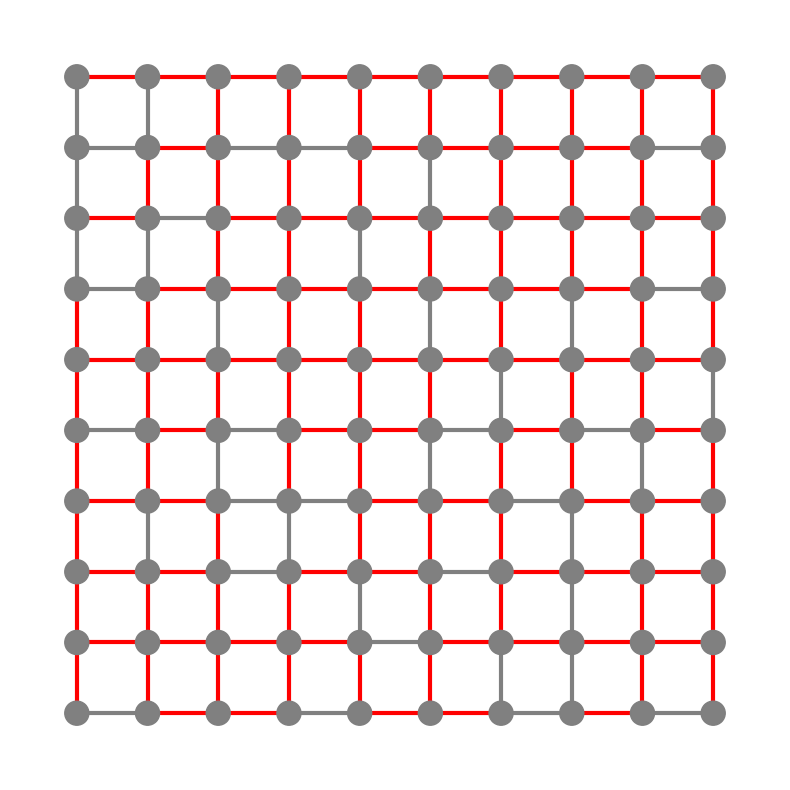

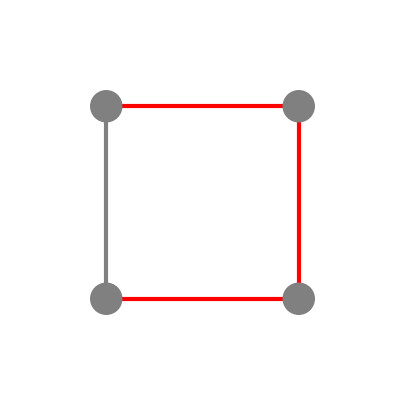

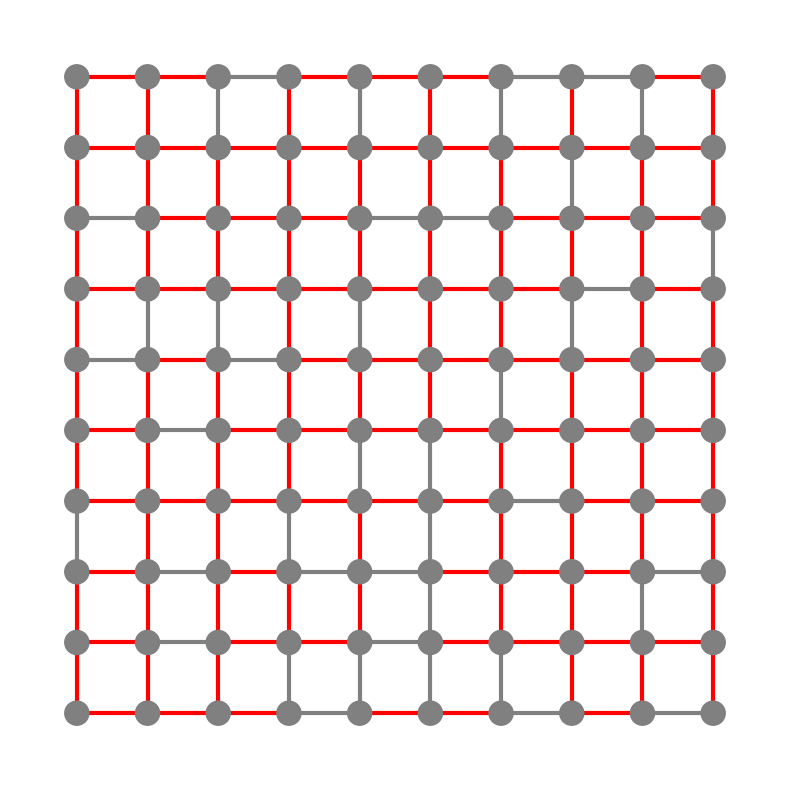

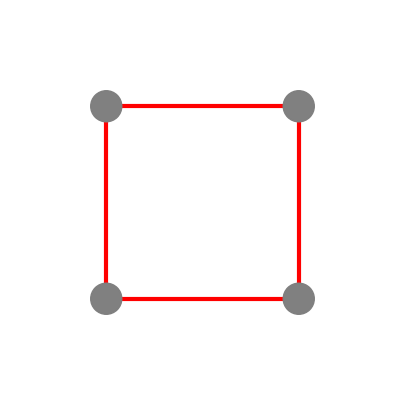

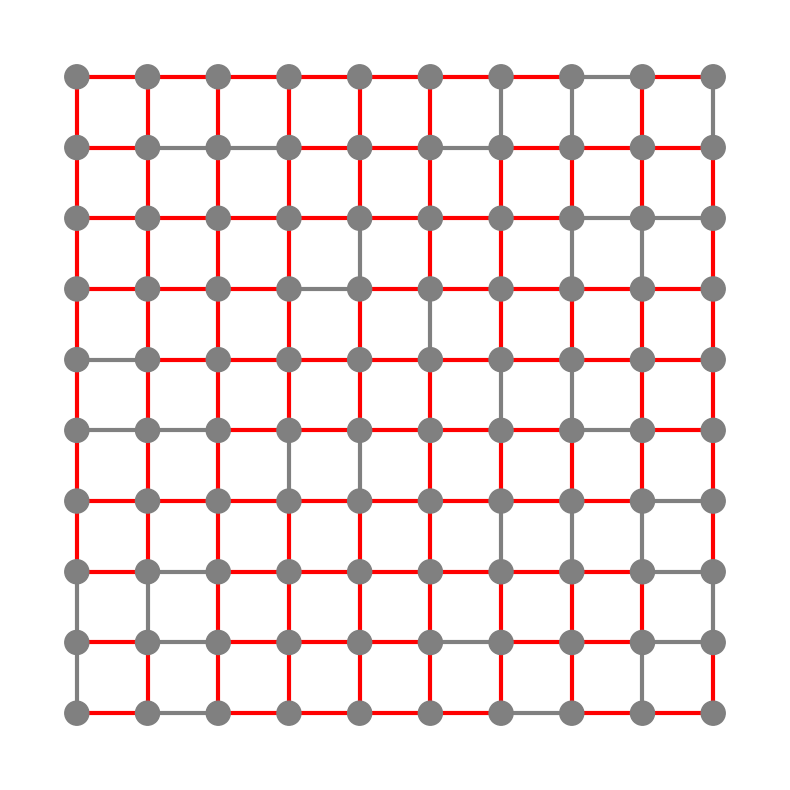

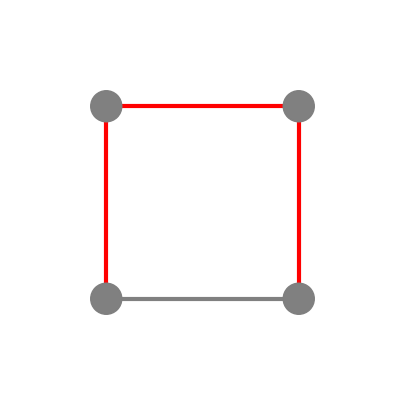

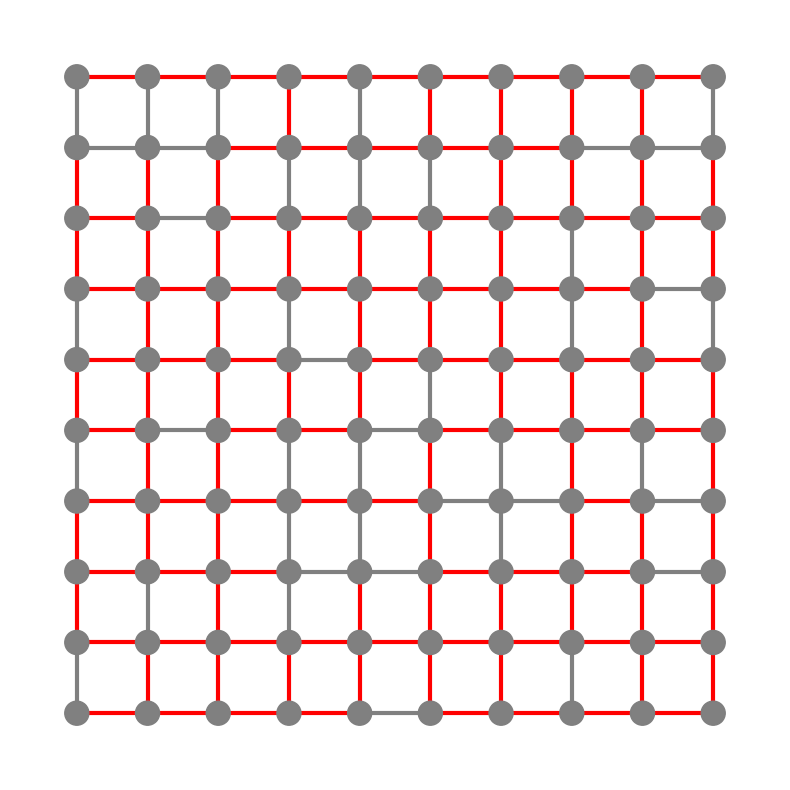

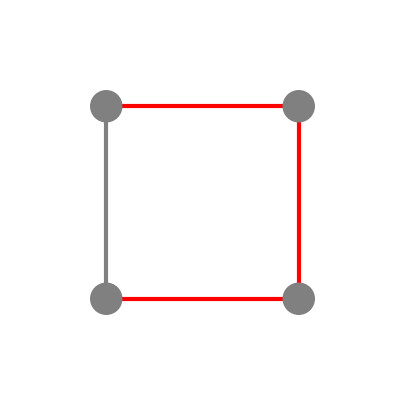

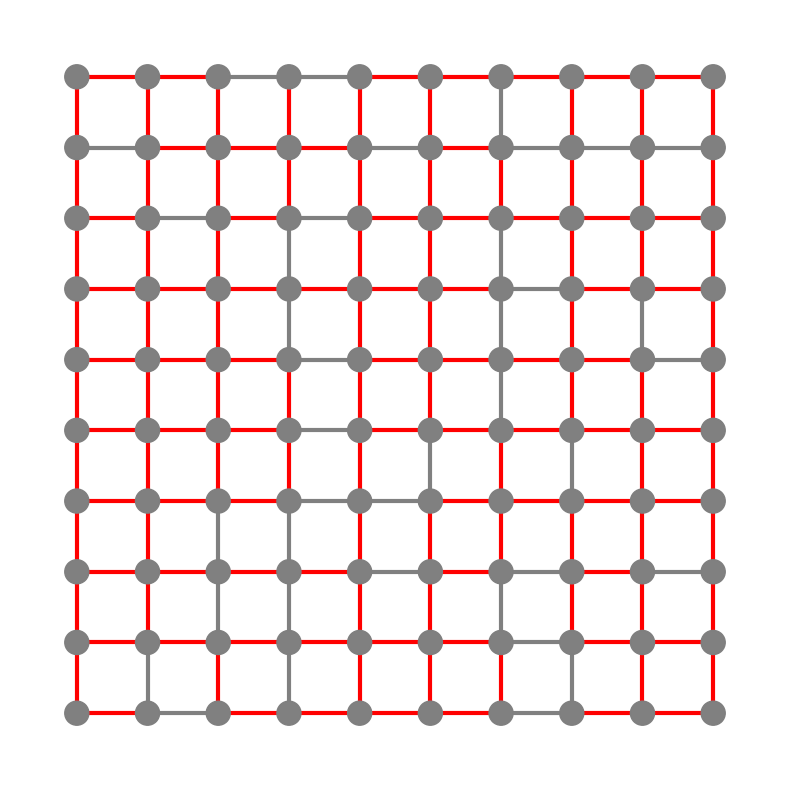

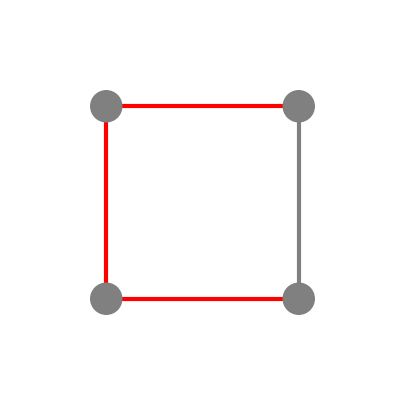

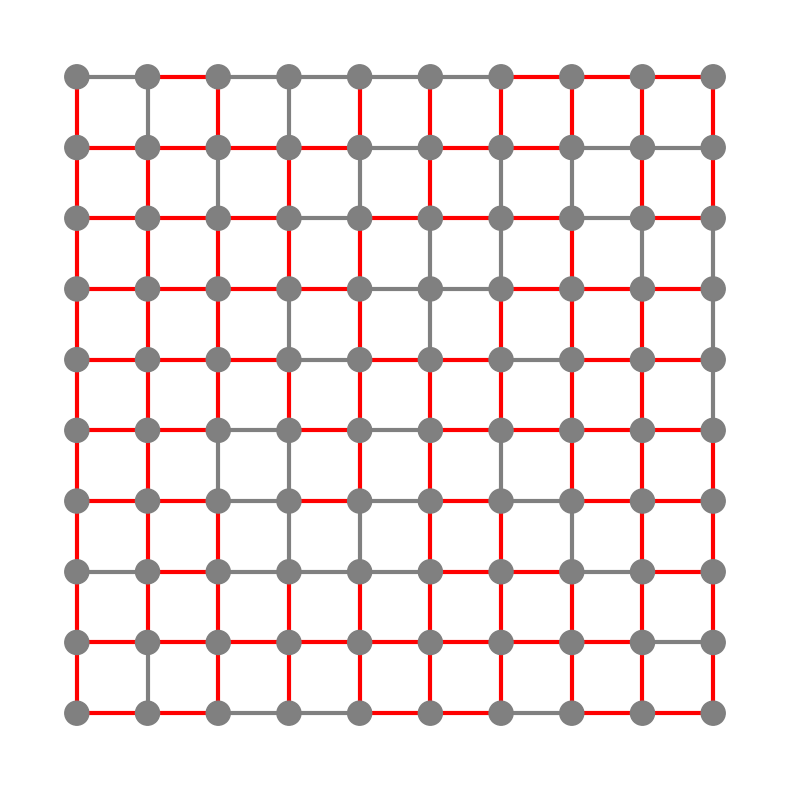

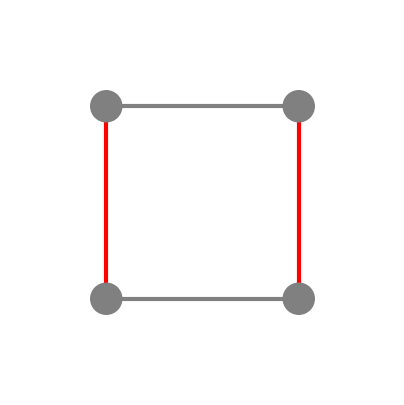

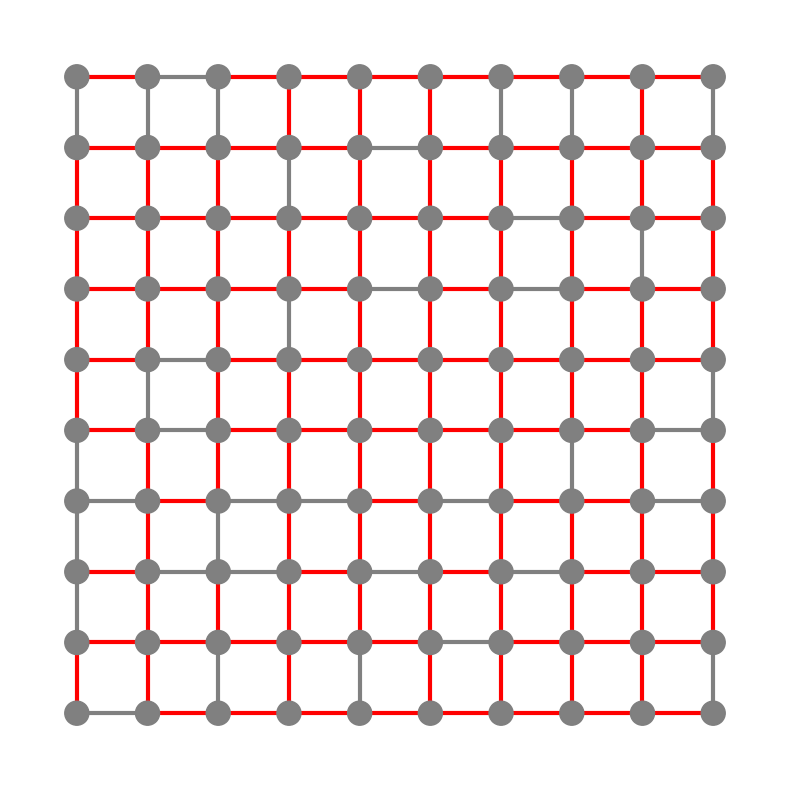

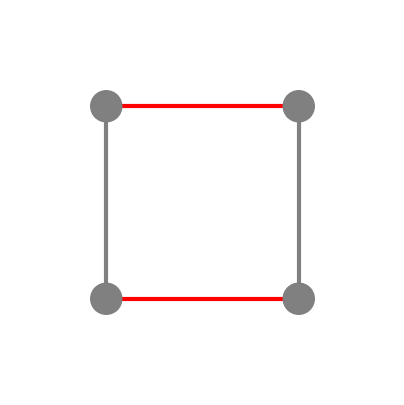

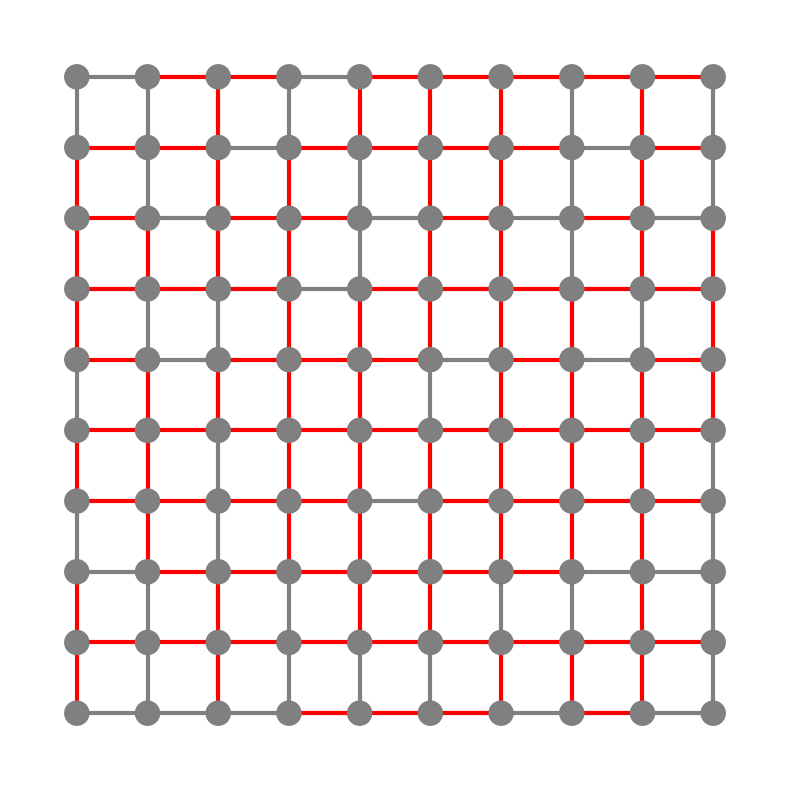

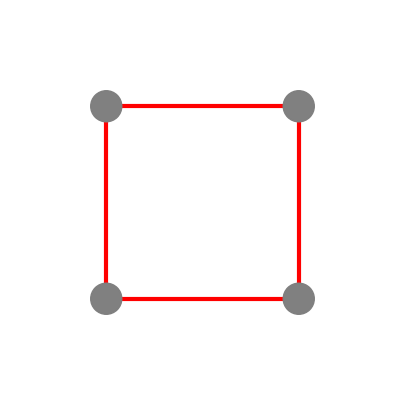

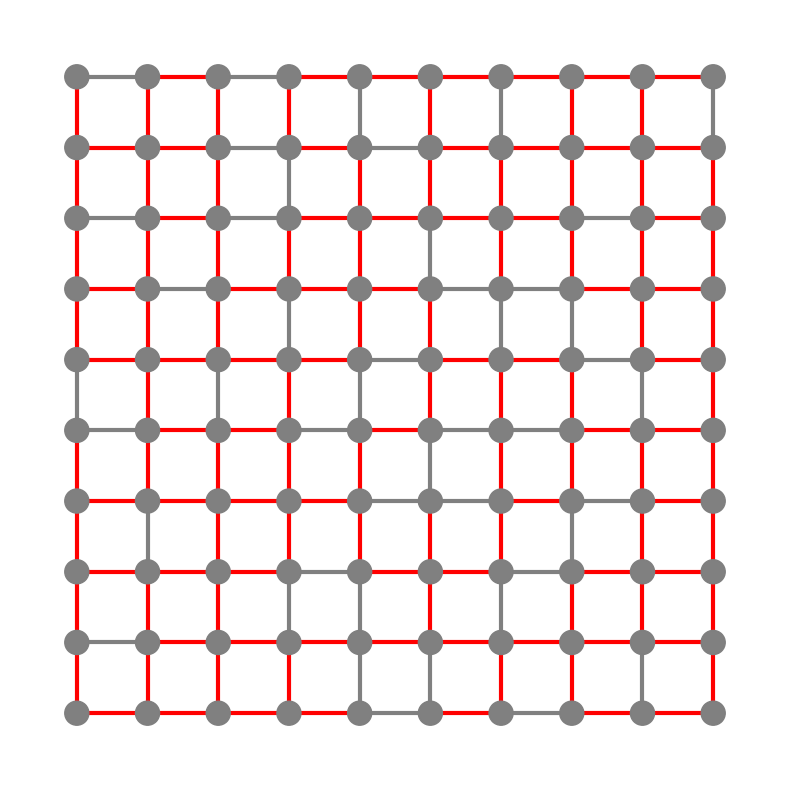

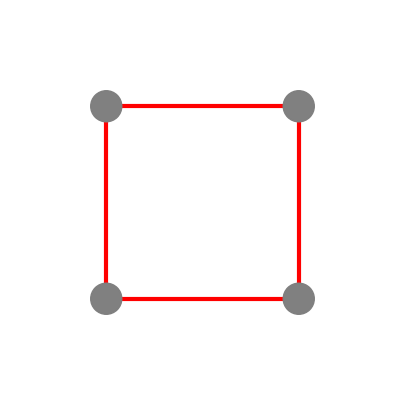

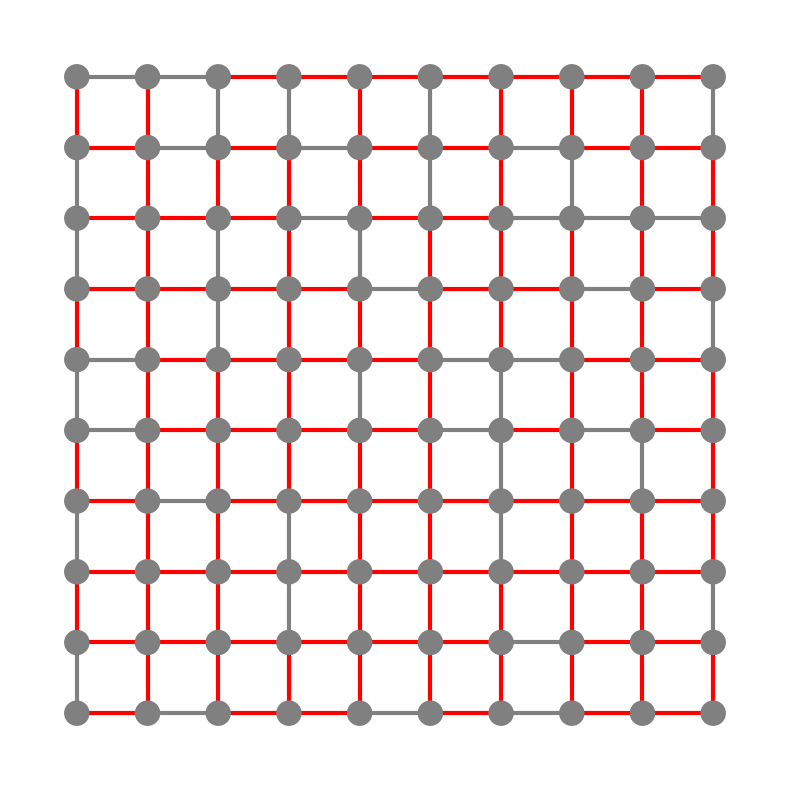

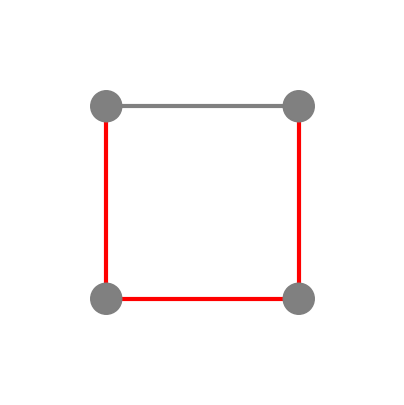

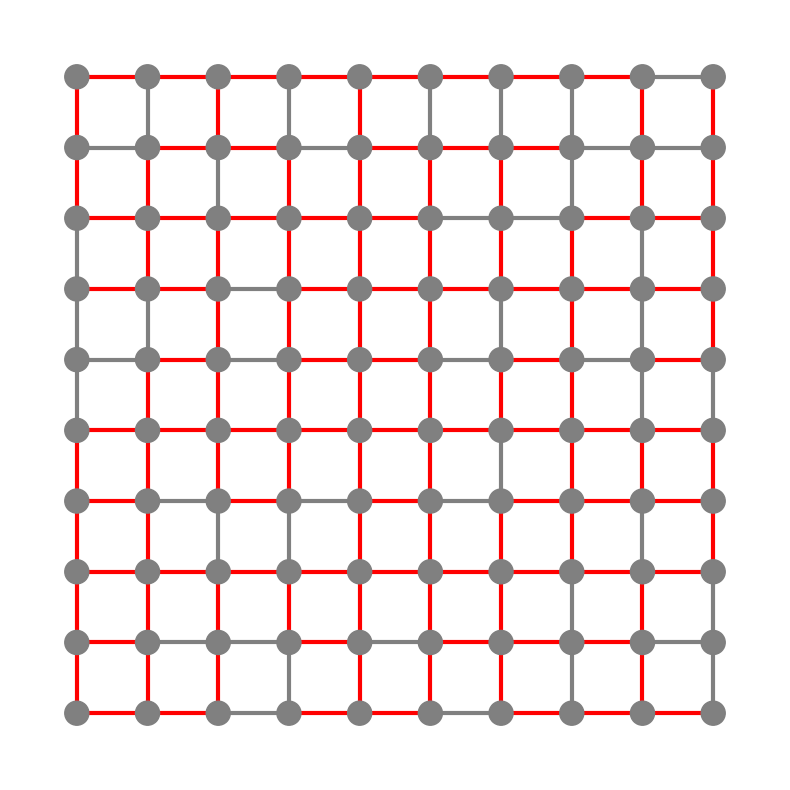

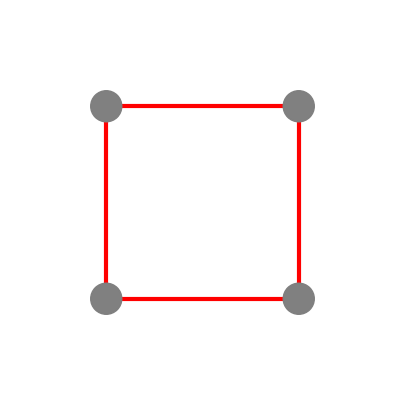

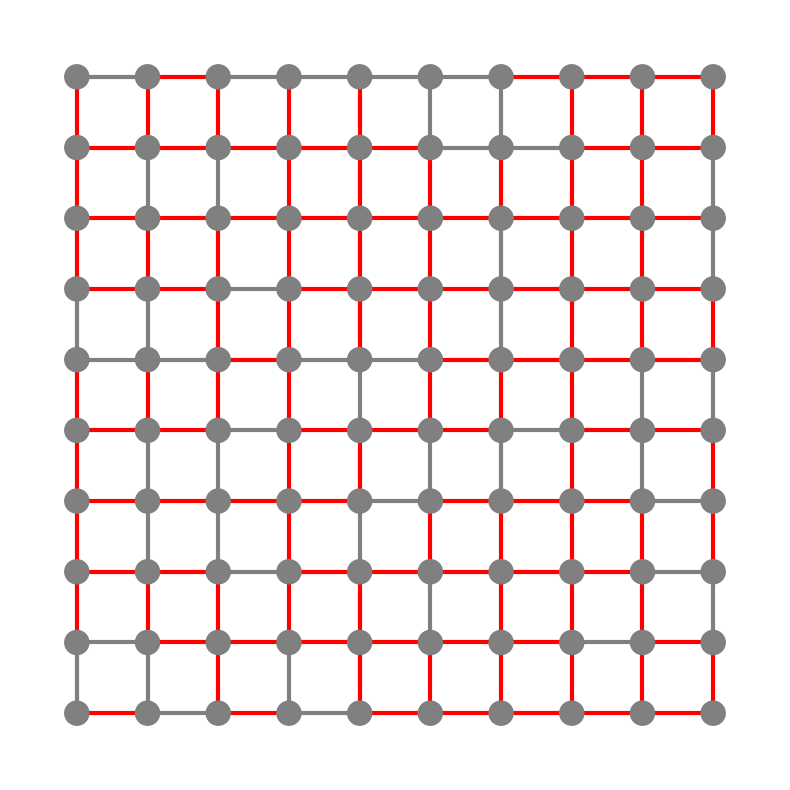

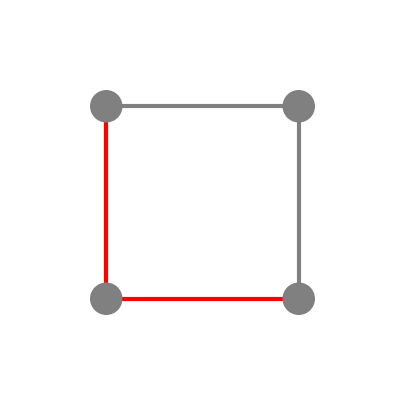

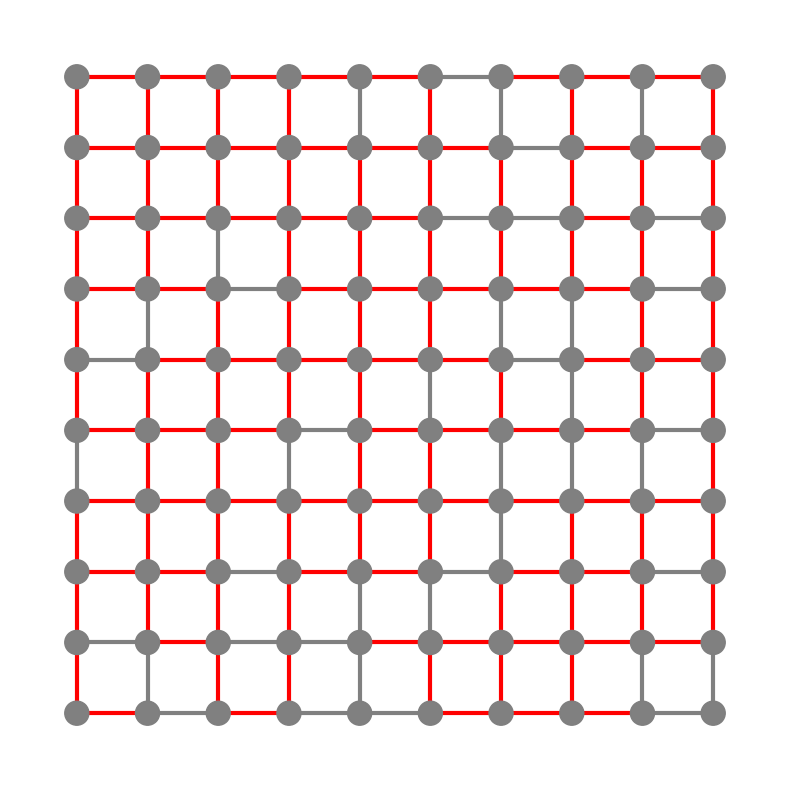

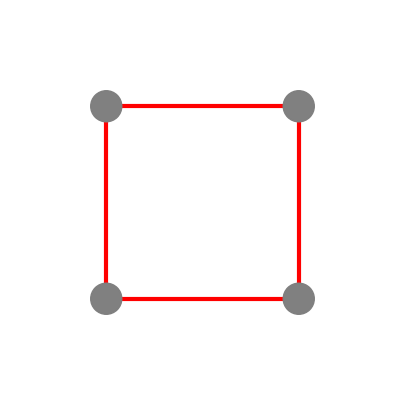

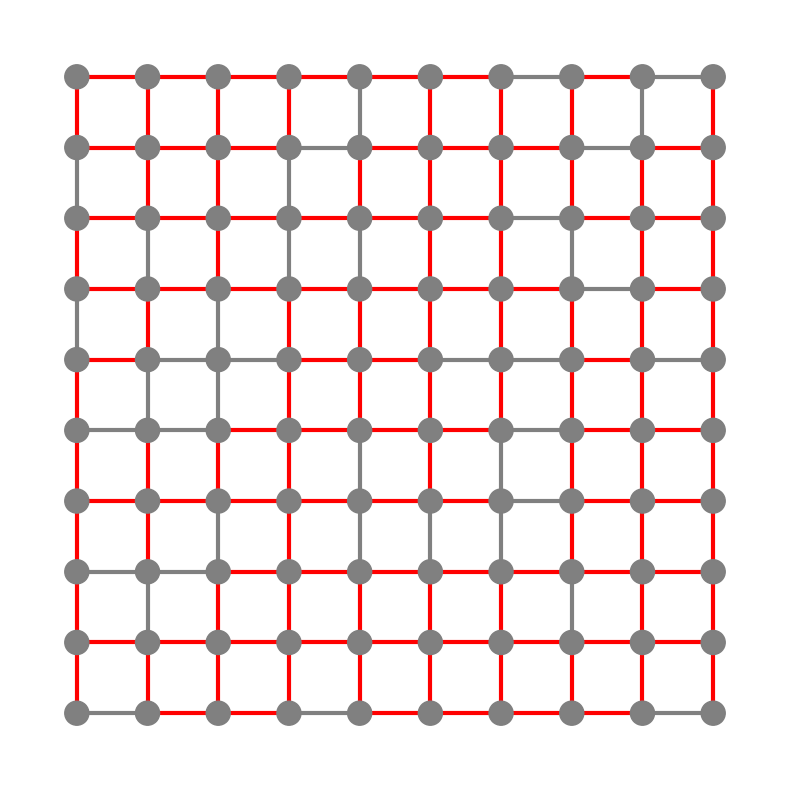

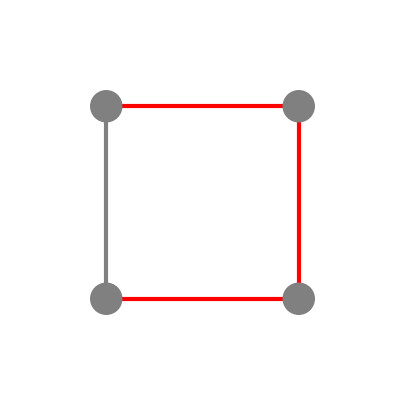

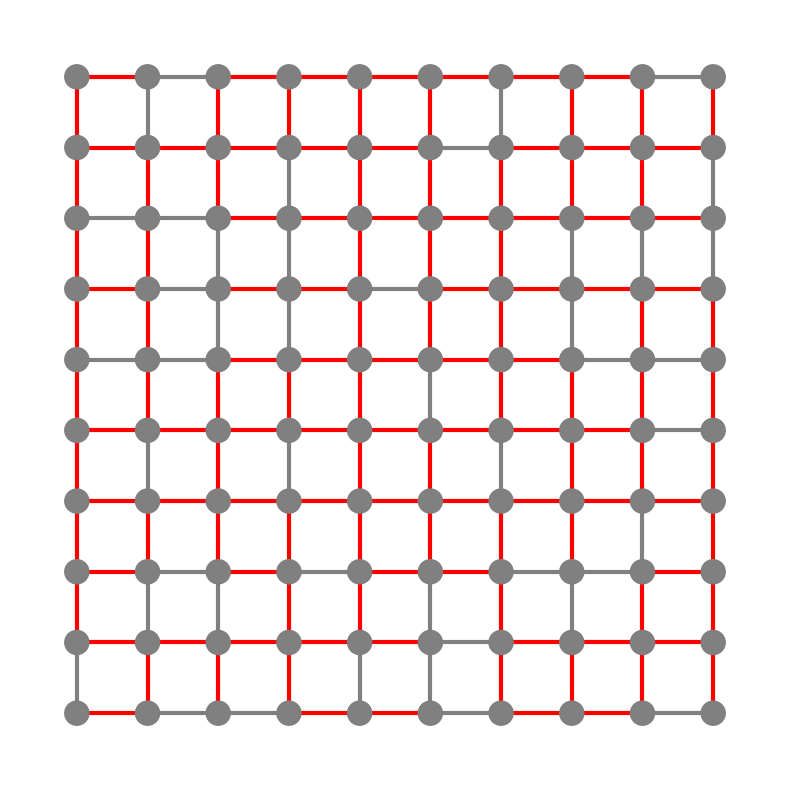

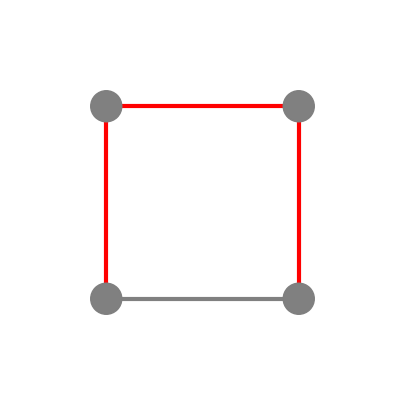

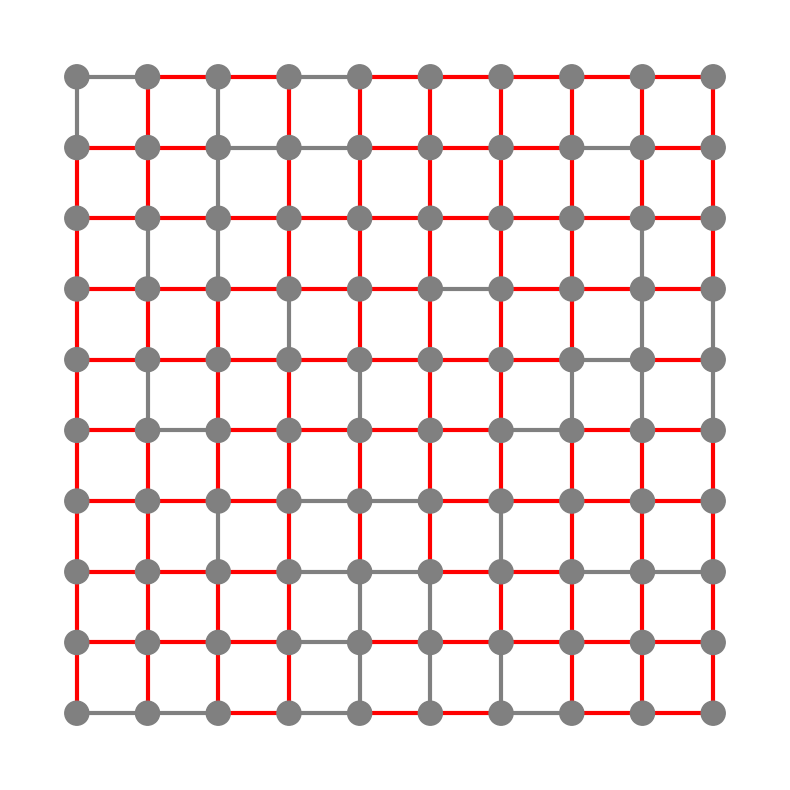

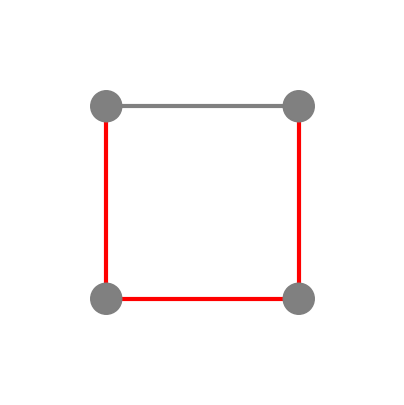

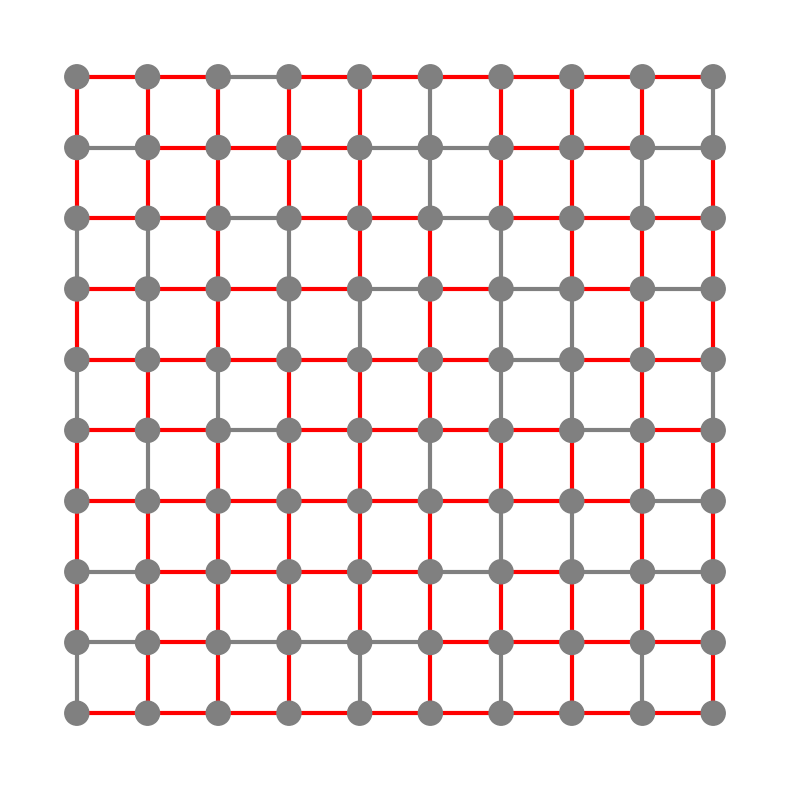

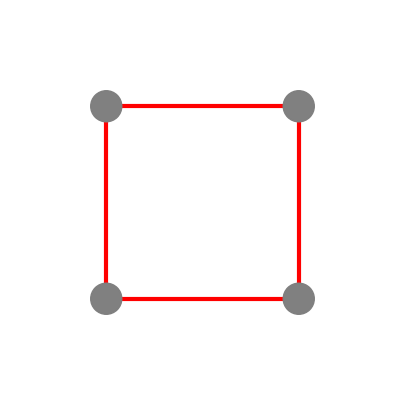

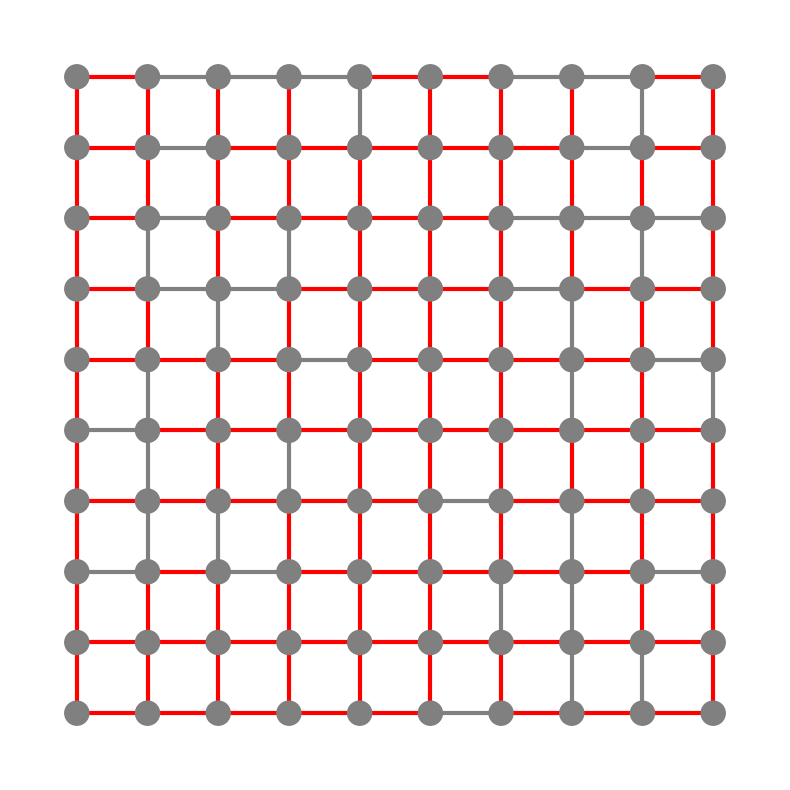

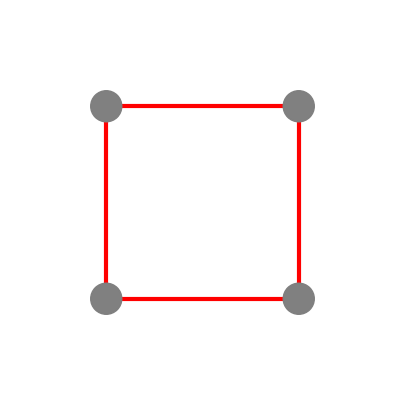

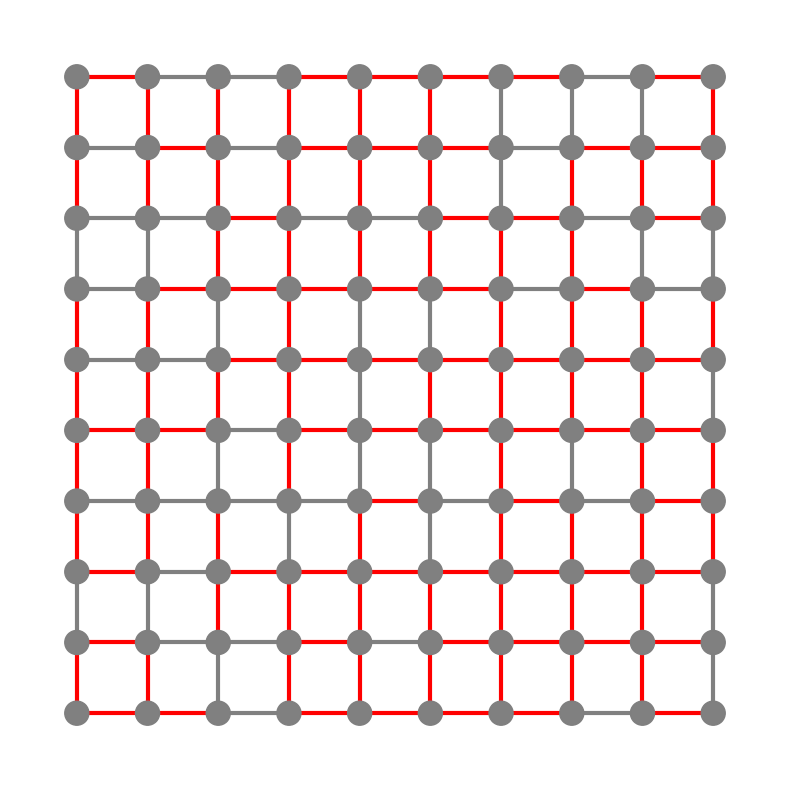

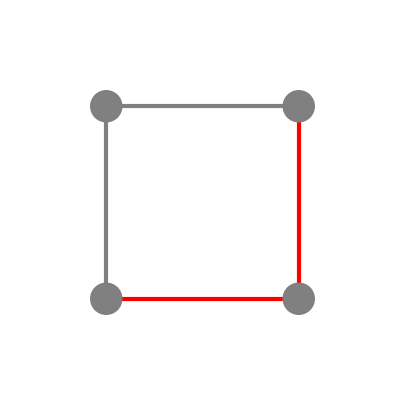

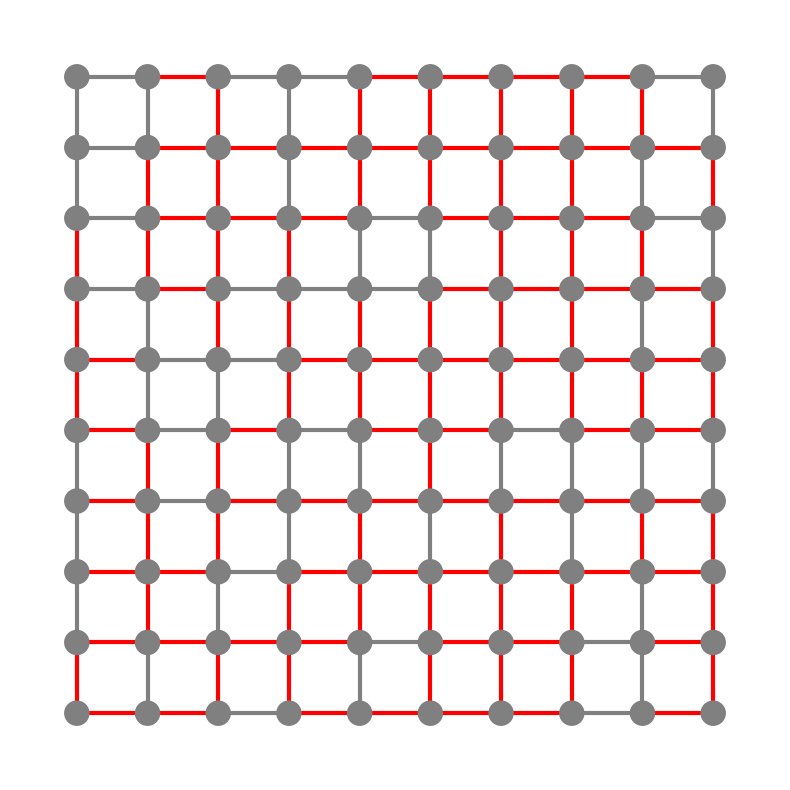

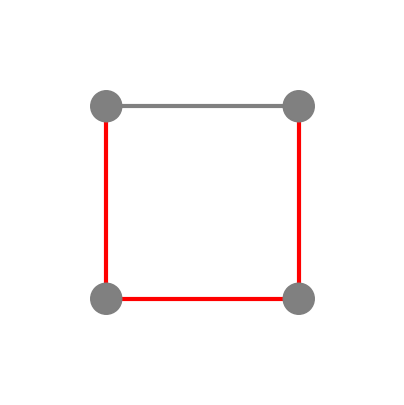

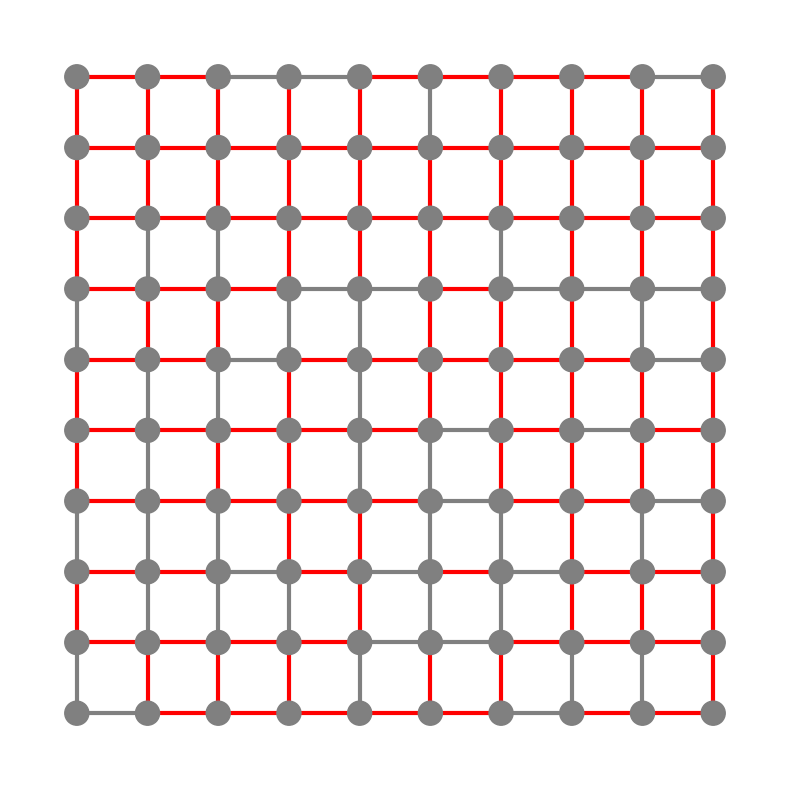

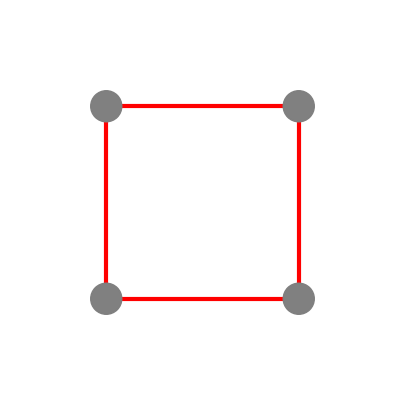

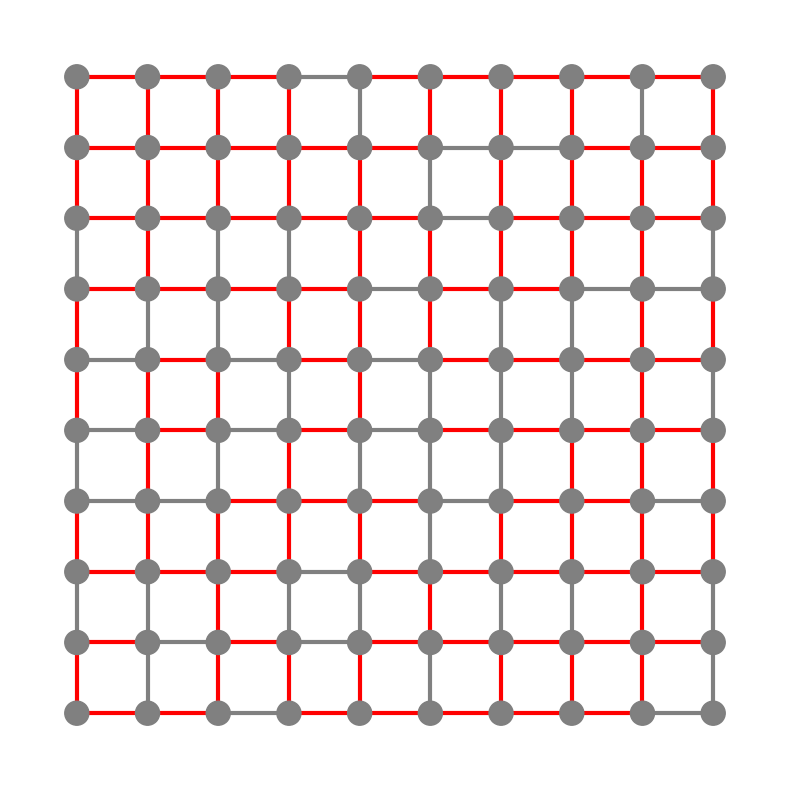

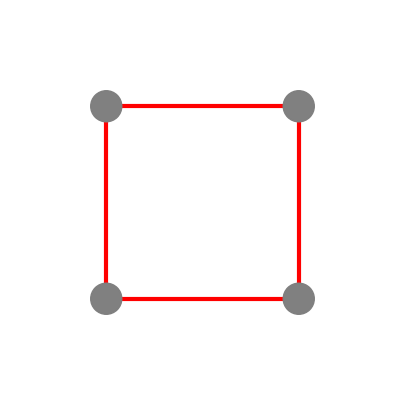

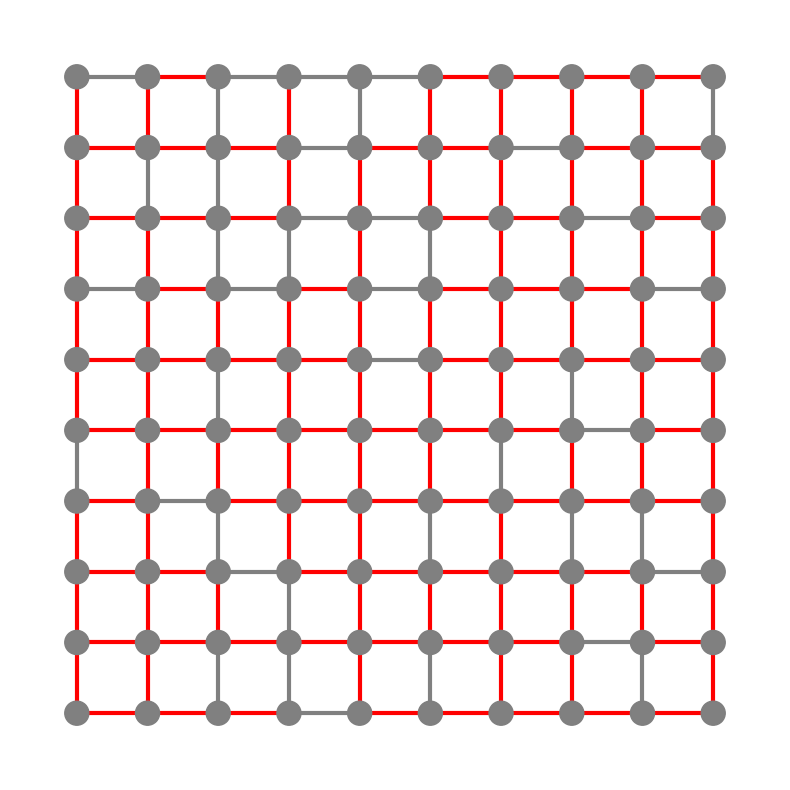

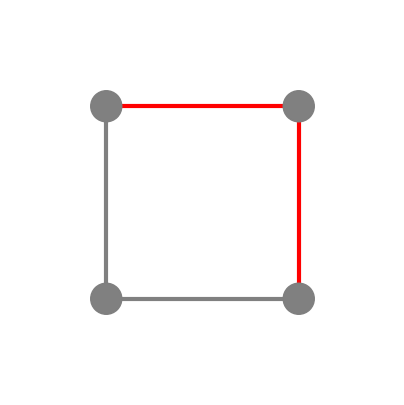

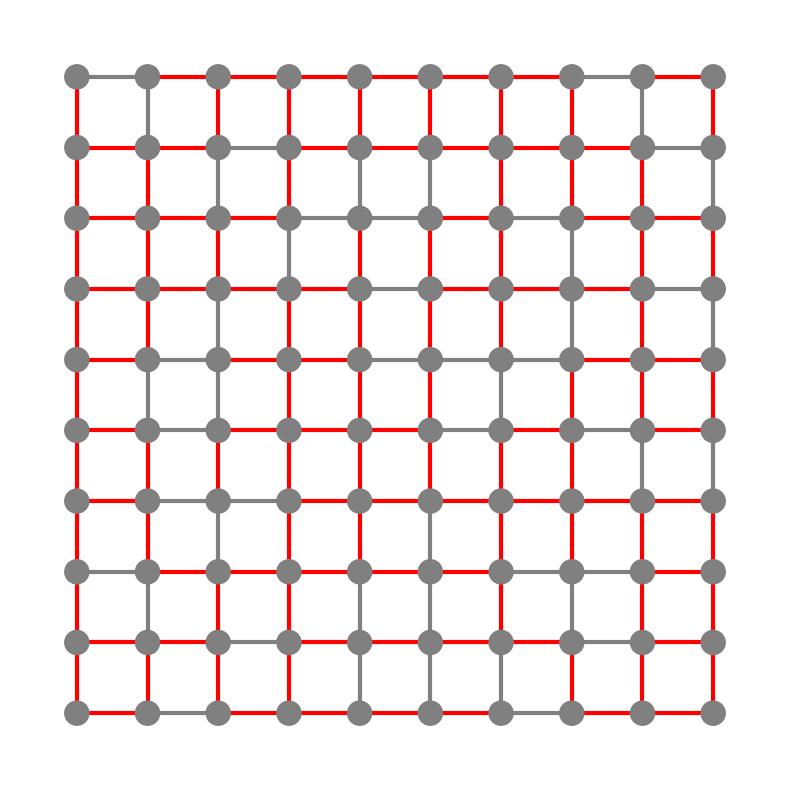

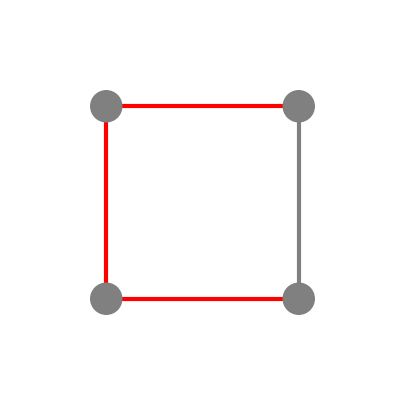

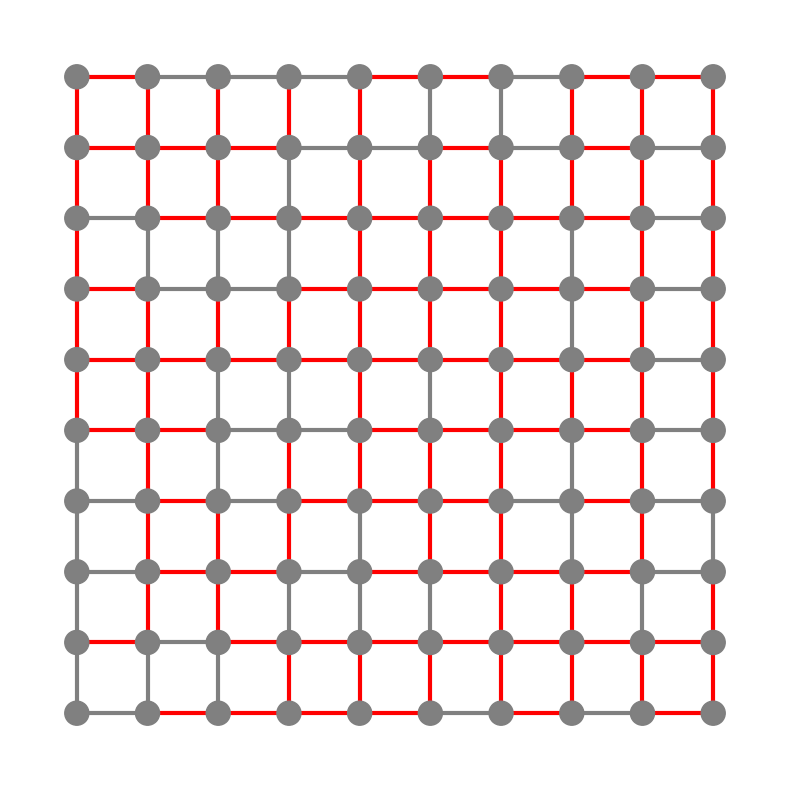

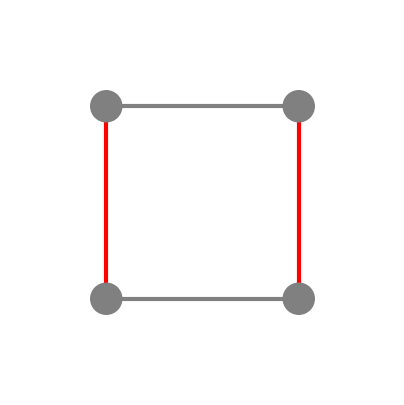

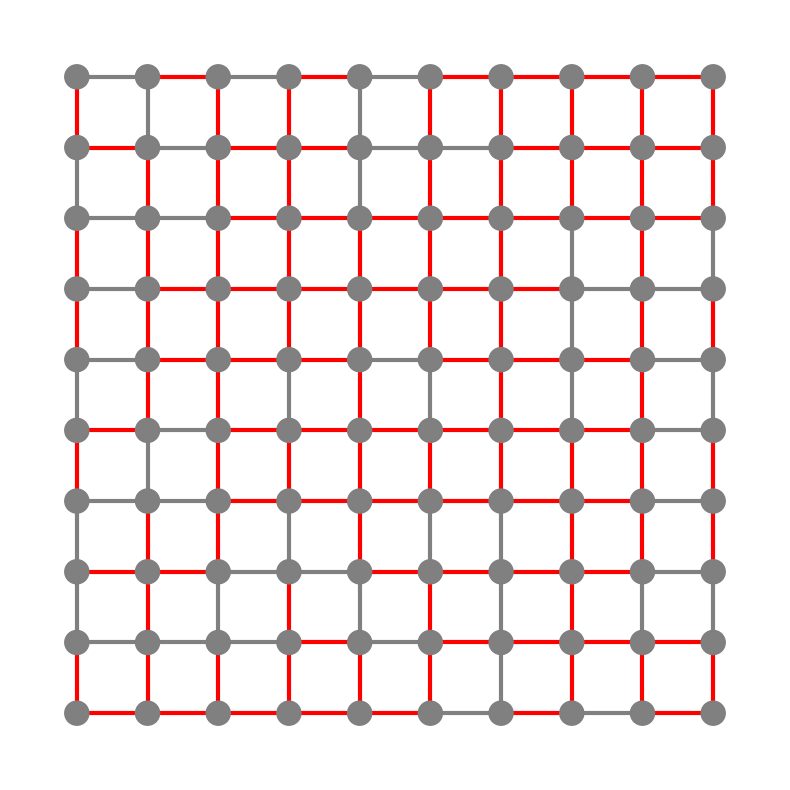

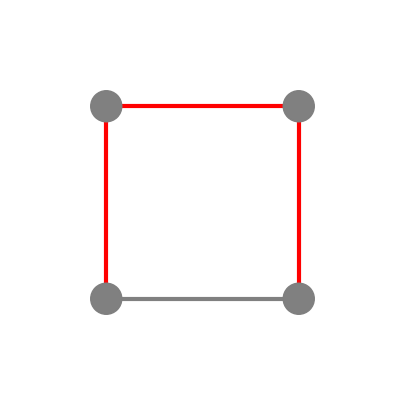

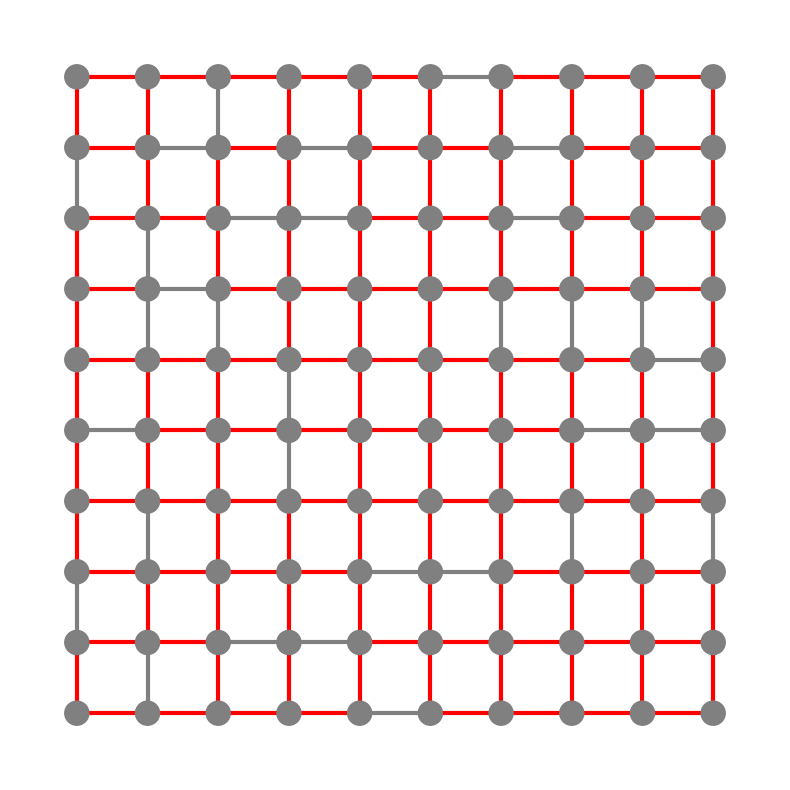

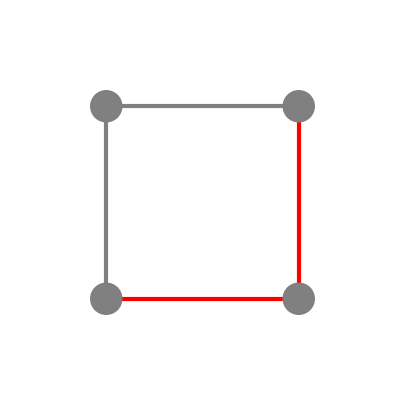

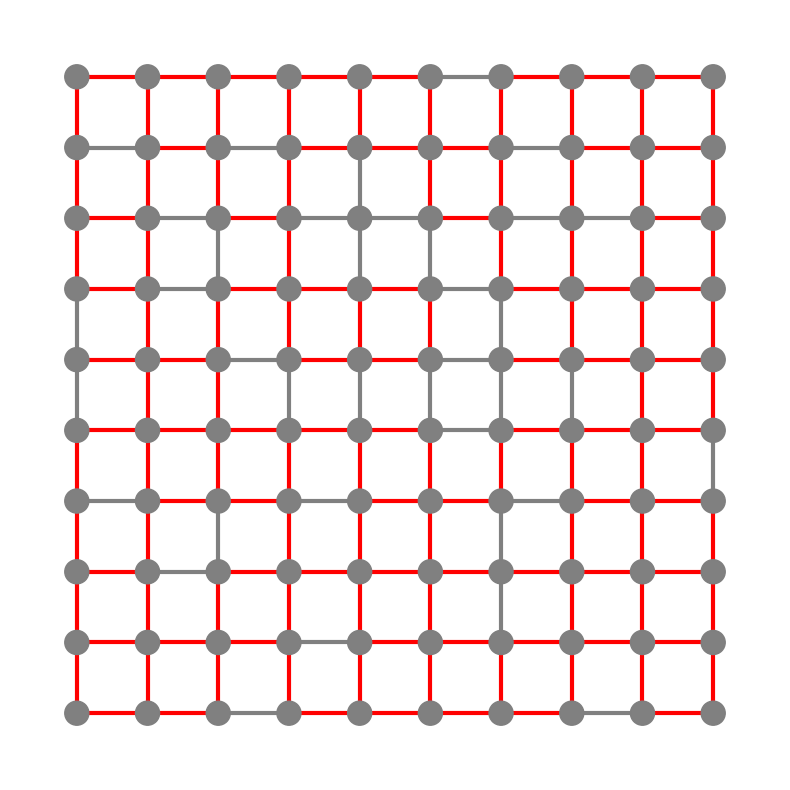

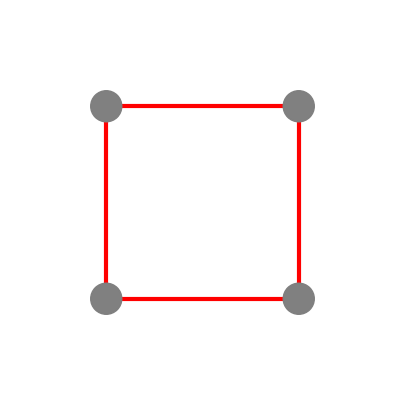

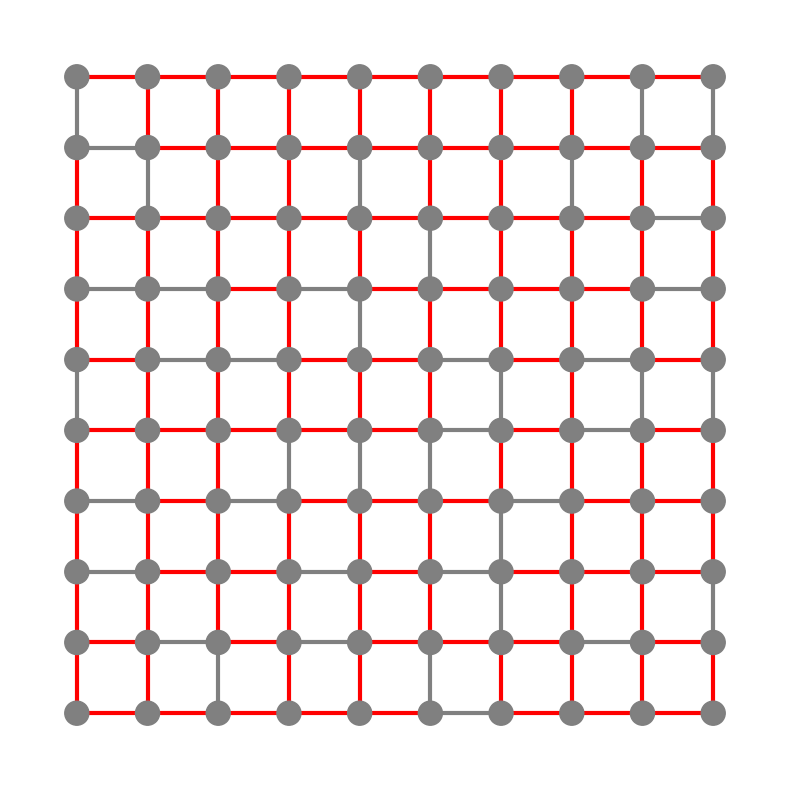

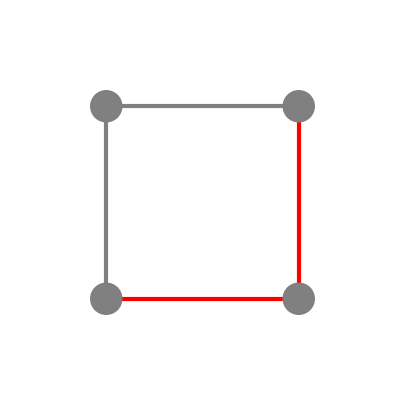

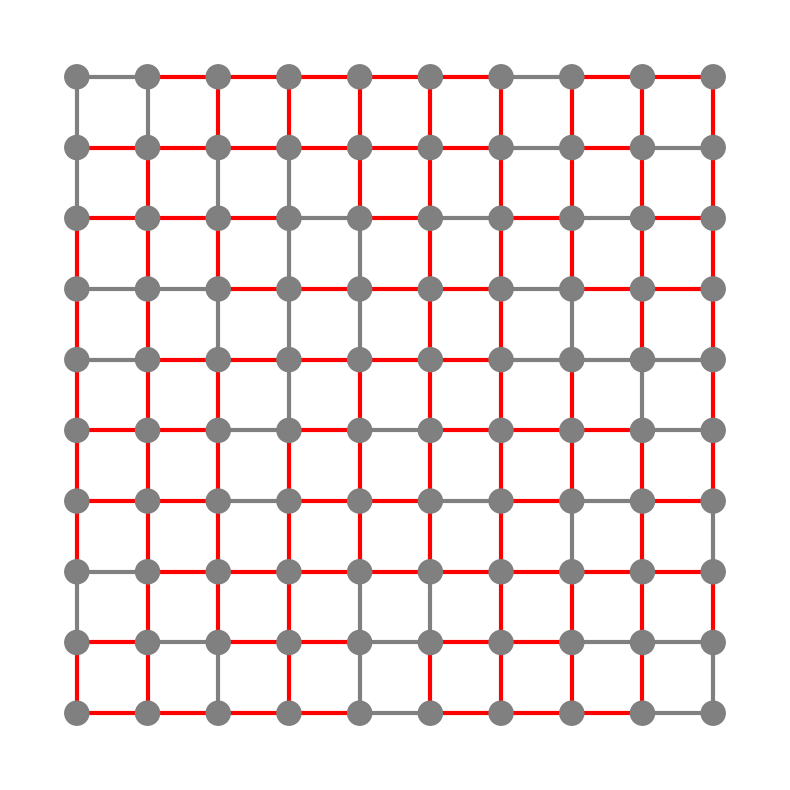

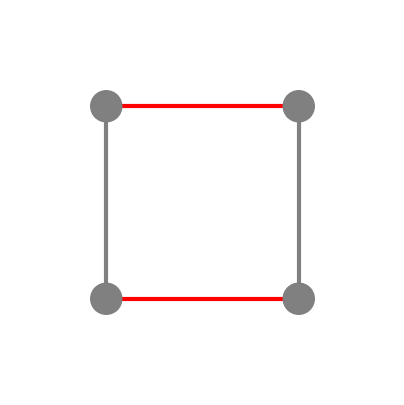

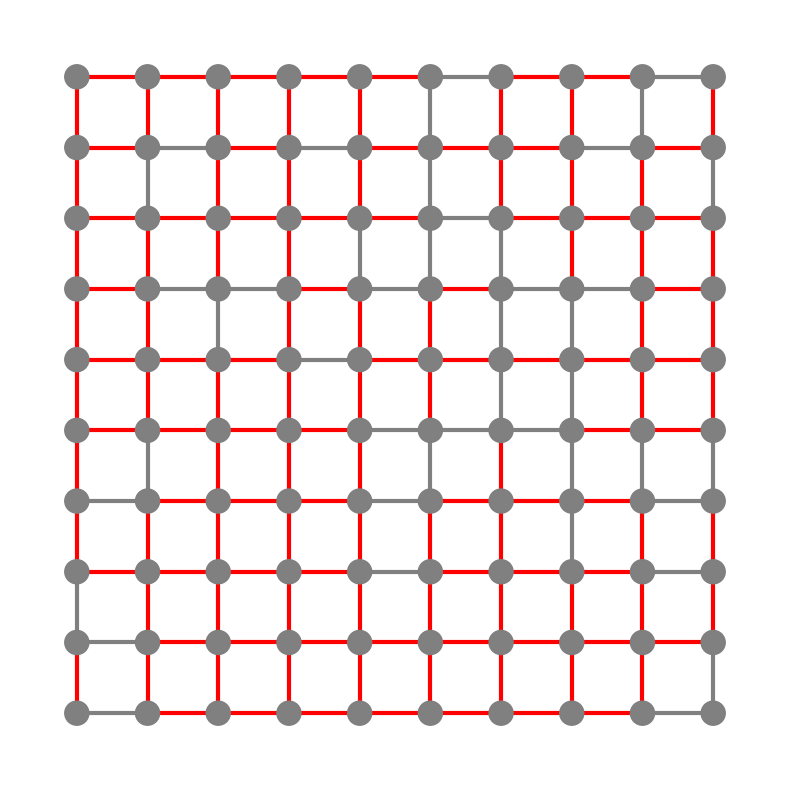

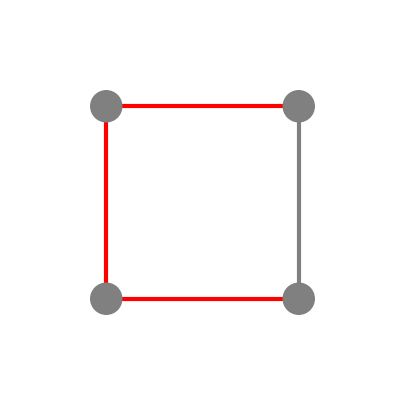

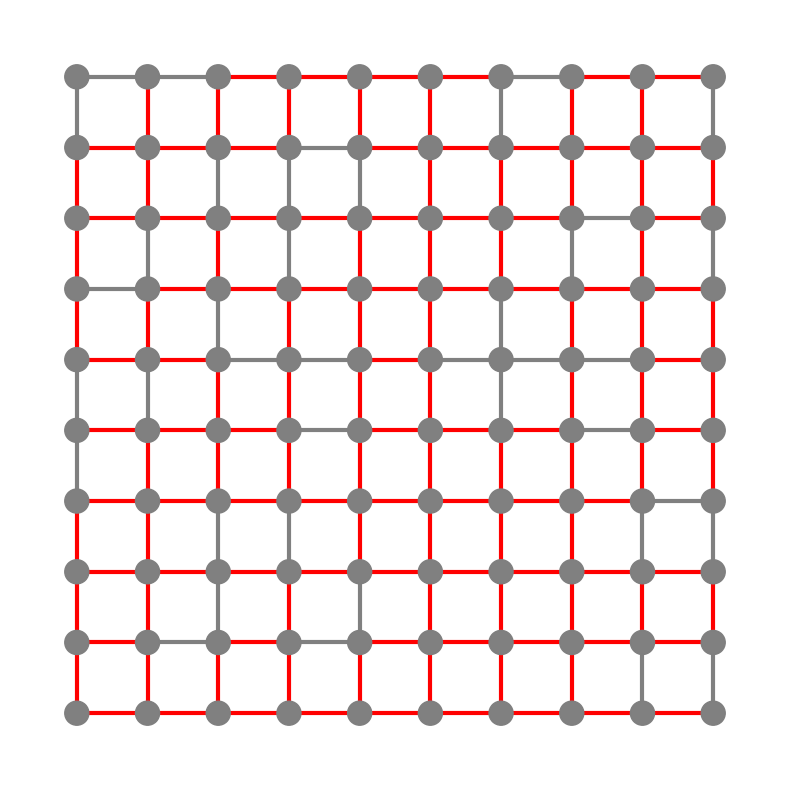

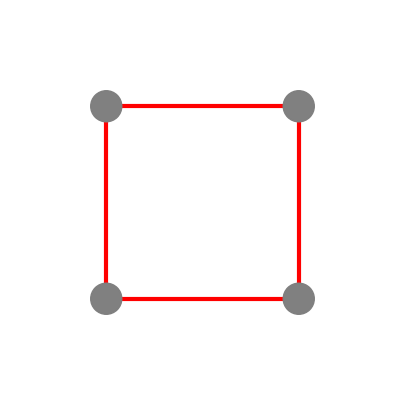

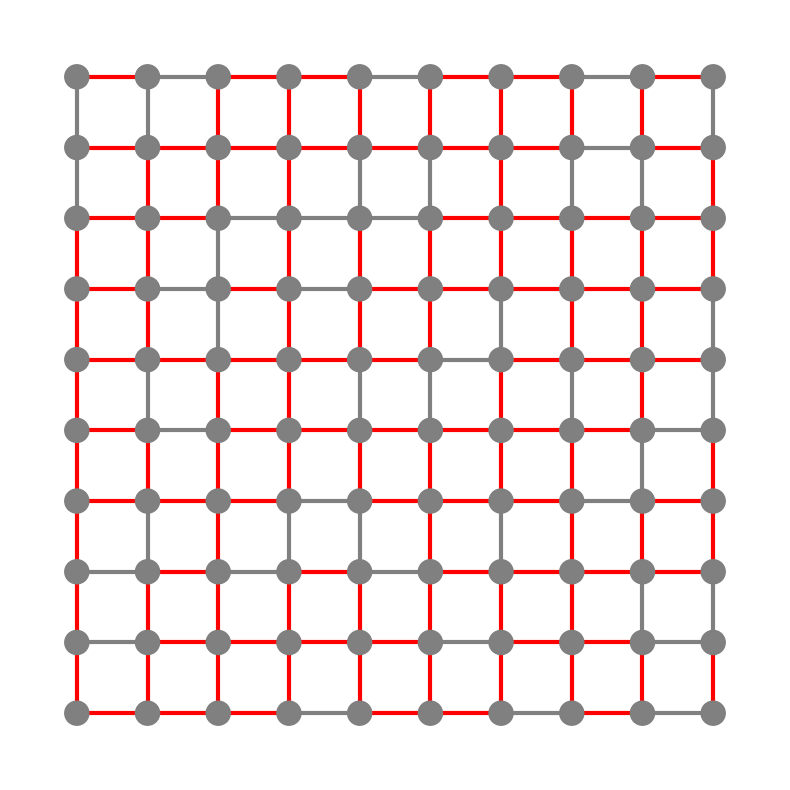

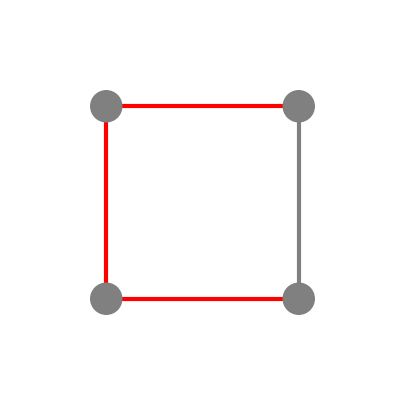

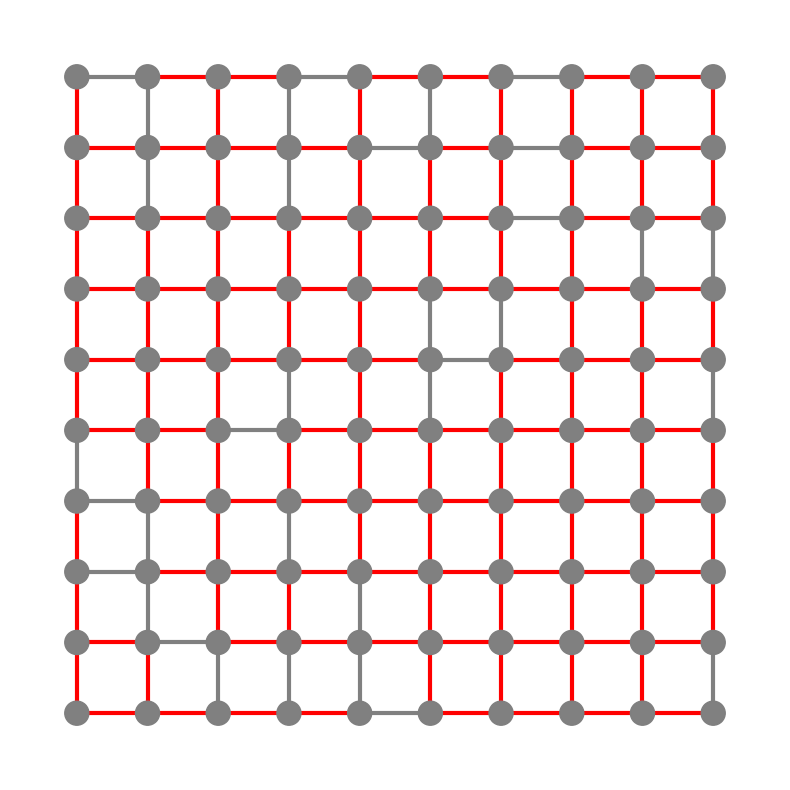

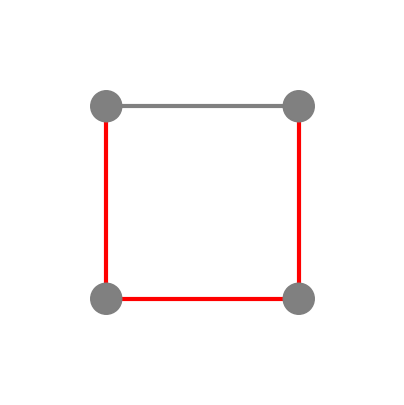

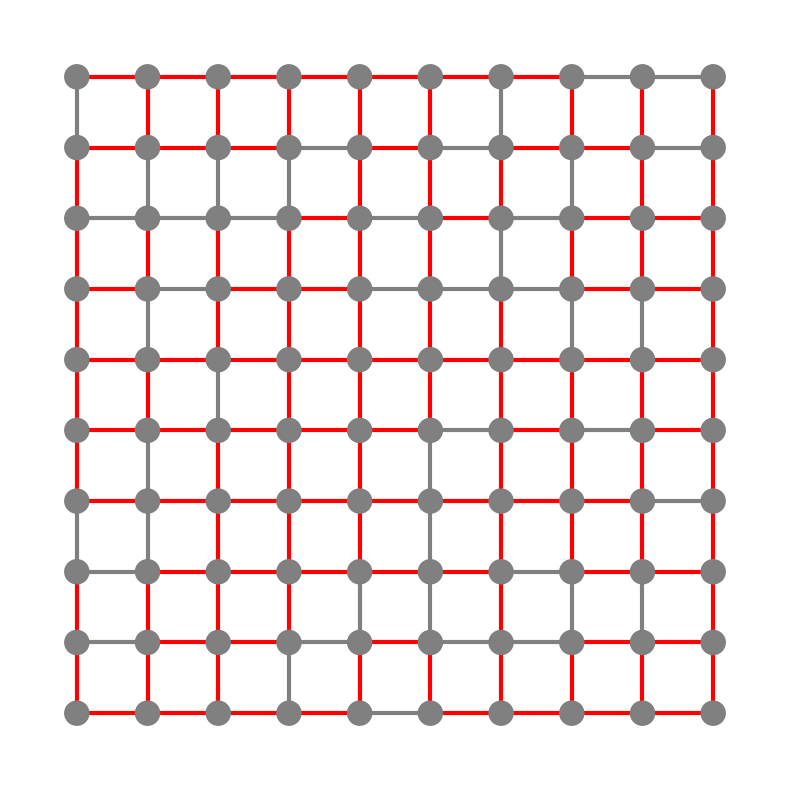

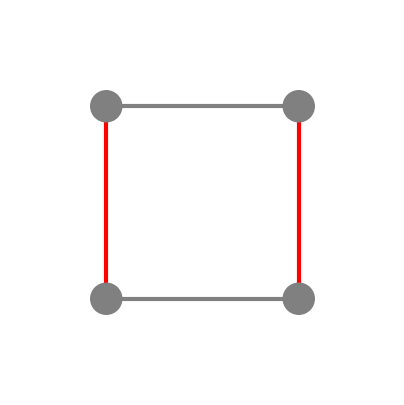

In [32]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import random


# to save 100 photos 
for file in range(0,100):
    
    n = 10  # Grid size
    # Initialize a grid graph with 100 nodes
    G = nx.grid_2d_graph(n, n)

    # Create a layout for the graph
    pos_adj_b = {(x, y): (x, y) for x, y in G.nodes()}  # Mapping of nodes to positions
    nx.set_node_attributes(G, pos_adj_b, 'pos')  # Set 'pos' attribute for nodes


    # This is done so that both the null grid and G_adj graph have the same node labels
    G = nx.convert_node_labels_to_integers(
        G, ordering='sorted', label_attribute='origin'
    )

    adj_matrix = np.zeros((n*n, n*n), dtype=int)  # Initialize adjacency matrix

    #Random generator for adj_matrix
    # Generate at least one edge
    while np.sum(adj_matrix) == 0:
        for i in range(n):
            for j in range(n):
                node = i * n + j  # Node index in the adjacency matrix

                # Check neighboring nodes and add edges randomly
                if i > 0 and np.random.rand() < 0.5:
                    adj_matrix[node, node - n] = 1  # Add edge to node above
                if i < n - 1 and np.random.rand() < 0.5:
                    adj_matrix[node, node + n] = 1  # Add edge to node below
                if j > 0 and np.random.rand() < 0.5:
                    adj_matrix[node, node - 1] = 1  # Add edge to node on the left
                if j < n - 1 and np.random.rand() < 0.5:
                    adj_matrix[node, node + 1] = 1  # Add edge to node on the right

    adj_matrix = np.array(adj_matrix)  

    ns = 2 # Str_elem Grid size

    structuring_element = np.zeros((ns*ns, ns*ns), dtype=int)

    while np.sum(structuring_element) == 0:
        for i in range(ns):
            for j in range(ns):
                node = i * ns + j  # Node index in the strturing element

                # Check neighboring nodes and add edges randomly
                if i > 0 and np.random.rand() < 0.5:
                    structuring_element[node, node - ns] = 1  # Add edge to node above
                if i < ns - 1 and np.random.rand() < 0.5:
                    structuring_element[node, node + ns] = 1  # Add edge to node below
                if j > 0 and np.random.rand() < 0.5:
                    structuring_element[node, node - 1] = 1  # Add edge to node on the left
                if j < ns - 1 and np.random.rand() < 0.5:
                    structuring_element[node, node + 1] = 1  # Add edge to node on the right

    structuring_element = np.array(structuring_element)

    # Graph from adjacency matrix
    G_adj = nx.from_numpy_matrix(adj_matrix)

    # Get edges from the adjacency matrix
    edges_adj = G_adj.edges()

    # Set node color and edge color for nodes and edges in the adjacency matrix
    node_color_adj = ['gray' if i in range(len(adj_matrix)) else 'lightgray' for i in range(G.number_of_nodes())]
    edge_color_adj = ['red' if edge in edges_adj else 'gray' for edge in G.edges()]
    pos_adj = nx.get_node_attributes(G, 'pos')

    # Draw the adjacency matrix graph
    plt.figure(figsize=(10, 10))
    # plt.title("Adjacency Matrix Graph")
    nx.draw_networkx(
        G, pos=pos_adj, with_labels=False, edgecolors="tab:gray", node_color=node_color_adj,
        node_size=300, font_size=10, edge_color=edge_color_adj, width=3
    )
    plt.box(False)
    plt.gca().set_aspect('equal')
    # # Save the graph as an image with a specific name and folder
    # filename = f"{adj_foldername}/adj_matrix_{file}.png"
    # plt.savefig(filename)
    plt.show()

    # Create a grid graph with 2 rows and 2 column
    G2 = nx.grid_2d_graph(2, 2)

    # Create a layout for the graph
    pos_s_b = {(x, y): (x, y) for x, y in G2.nodes()}  # Mapping of nodes to positions
    nx.set_node_attributes(G2, pos_s_b, 'pos')  # Set 'pos' attribute for nodes

    # This is done so that both the null grid and G_str graph have the same node labels
    G2 = nx.convert_node_labels_to_integers(
        G2, ordering='sorted', label_attribute='origin'
    )

    # Create graph G_str from the structuring element
    G_str = nx.from_numpy_matrix(structuring_element)
    edges_str = G_str.edges()

    #defined the origin
    edges_str_list = list(edges_str)

    origin = [edges_str_list[0]]

    # Set node and edge colors for G_str
    node_color_str = ['gray' for _ in G_str.nodes()]
    edge_color_str = ['red' if edge in edges_str else 'gray' for edge in G2.edges()]
    pos_s = nx.get_node_attributes(G2, 'pos')

    # Draw the structuring element graph
    plt.figure(figsize=(5, 5))
    # plt.title("Structuring Element Graph")
    nx.draw_networkx(
        G2, pos=pos_s, with_labels=False, edgecolors="tab:gray", node_color=node_color_str,
        node_size=500, font_size=10, edge_color=edge_color_str, width=3
    )
    plt.box(False)
    plt.xlim([-0.5, 1.5])
    plt.ylim([-0.5, 1.5])
    plt.gca().set_aspect('equal')
    # # Save the graph as an image with a specific name and folder
    # filename = f"{str_foldername}/str_elem_{file}.png"
    # plt.savefig(filename)
    plt.show()
    
    #opening normal method
    result_edges_new = Direct_Opening(pos_adj, G, G2, G_str, origin, G_adj)
    Result_matrix(G, adj_matrix, structuring_element, result_edges_new)
    
    #opening through erosion and dilation
    result_edges_erosion = Erosion(pos_adj, G, G2, G_str, origin, G_adj)
    eroded_adj_matrix = create_adjacency_matrix(result_edges_erosion, n)#n is taken from above 
    G_eroded = nx.from_numpy_matrix(eroded_adj_matrix)
    result_edges_opening = Dilation(pos_adj, G, G2, G_str, origin, G_eroded)
    Result_matrix_trad(G, adj_matrix, structuring_element, result_edges_opening)

In [29]:
def Direct_Opening(pos_adj, G, G2, G_str, origin, G_adj):
    result_edges = []
    #pos_adj_inverse
    pos_adj_inv = {v: k for k, v in pos_adj.items()}

    #get last node in the adj_matrix to define stopping point
    adj_nodes = [(pos_adj[u]) for u in list(G.nodes())]
    adj_last_node = adj_nodes[-1]

    #To get nodes in the structuring element
    str_nodes = [(pos_s[u]) for u in list(G2.nodes())]
    # print("str_nodes: ",str_nodes)

    #To get connected edges in the structuring element
    str_elem_edges = [(pos_s[u],pos_s[v]) for u,v in G_str.edges()]
    # print("str_elem_edges: ",str_elem_edges)
    start_str_elem_edges = str_elem_edges #stored for use in while loop

    #initial position values for the str element in adj_matrix
    #sub_graph of adj matrix
    sub_list = []
    sub_list_pos = []
    for j in str_nodes:
        for k,l in pos_adj.items():
            if(j == l):
                sub_list.append(k)
                sub_list_pos.append(l)

    #initial position values for the str element edges in adj matrix
    str_elem_adj_edges = [(pos_adj_inv[edge[0]], pos_adj_inv[edge[1]]) for edge in str_elem_edges]

    #defining for proper mvement
    start_l = sub_list_pos
    start_node = sub_list_pos[0]
    end_node = sub_list_pos[-1]

    while(end_node != adj_last_node):#vertical

        #sub_graph_edges compared with str_elem_edges
        G_sub = G_adj.subgraph(sub_list)
        sub_edges = list(G_sub.edges())
        sub_edges_set = set(tuple(sorted(edge)) for edge in sub_edges)
        str_elem_adj_edges_set = set(tuple(sorted(edge)) for edge in str_elem_adj_edges)
        #check if all values in str_elem_et are in the subset
        edge_flag = all(i in sub_edges_set for i in str_elem_adj_edges_set)
        if(edge_flag):
            result_edges.extend(list(str_elem_adj_edges_set))
        while(end_node[0] != adj_last_node[0]): # horizontal
            #moving horizontally
            sub_list_pos = [(i + 1, j) for (i, j) in sub_list_pos]
            start_node = sub_list_pos[0]
            end_node = sub_list_pos[-1]

            #updating sub_list moving horizontally based on new sub_list_pos and converting in form so that it can be compared
            sub_list = [pos_adj_inv[edge] for edge in sub_list_pos]
            #updated str_lem nodes moving horizontally
            str_elem_edges = [((i + 1, j), (k + 1, l)) for ((i, j), (k, l)) in str_elem_edges]
            #converted in proper form for comparision
            str_elem_adj_edges = [(pos_adj_inv[edge[0]], pos_adj_inv[edge[1]]) for edge in str_elem_edges]
            #sub_graph_edges compared with str_elem_edges
            G_sub = G_adj.subgraph(sub_list)
            sub_edges = list(G_sub.edges())
            sub_edges_set = set(tuple(sorted(edge)) for edge in sub_edges)
            str_elem_adj_edges_set = set(tuple(sorted(edge)) for edge in str_elem_adj_edges)
            #check if all values in str_elem_et are in the subset
            edge_flag = all(i in sub_edges_set for i in str_elem_adj_edges_set)
            if(edge_flag):
                result_edges.extend(list(str_elem_adj_edges_set))

        #if this is the last block stop here
        if(end_node == adj_last_node):
            break
        #reset to start position and then increment vertically
        sub_list_pos = start_l
        sub_list_pos = [(i,j + 1) for (i,j) in sub_list_pos]
        end_node = sub_list_pos[-1]
        start_l = sub_list_pos #this is the new start element now
        #updating sub_list moving vertically based on new sub_list_pos and converting in proper form using pos_adj_inv dict 
        sub_list = [pos_adj_inv[edge] for edge in sub_list_pos]
        #reset to start position and then increment
        str_elem_edges = start_str_elem_edges
        str_elem_edges = [((i, j + 1), (k, l + 1)) for ((i, j), (k, l)) in str_elem_edges]
        #updated str elem edges based on adj matrix
        str_elem_adj_edges = [(pos_adj_inv[edge[0]], pos_adj_inv[edge[1]]) for edge in str_elem_edges]
        start_str_elem_edges = str_elem_edges #this is the new start element now
        
    return result_edges

In [20]:
origin

[(0, 1)]

Eroded_matix: 


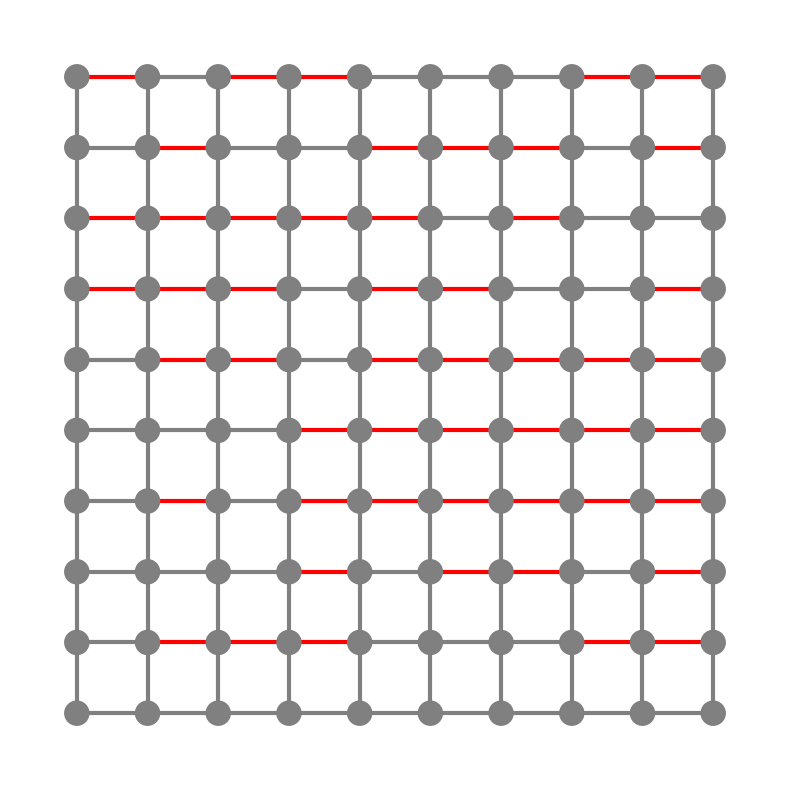

Dilated_matix: 


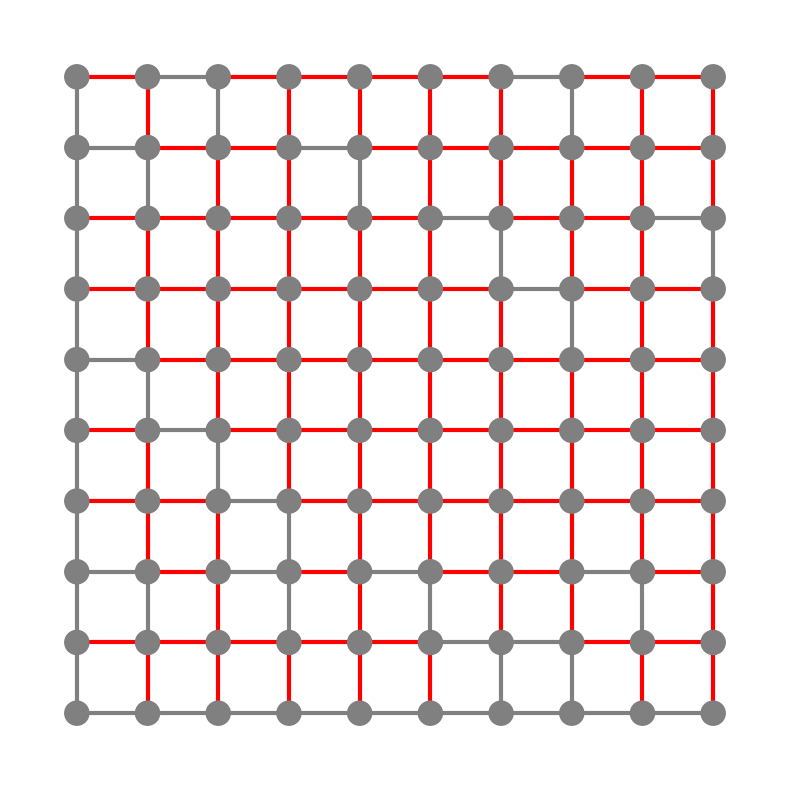

Opening_matrix: 


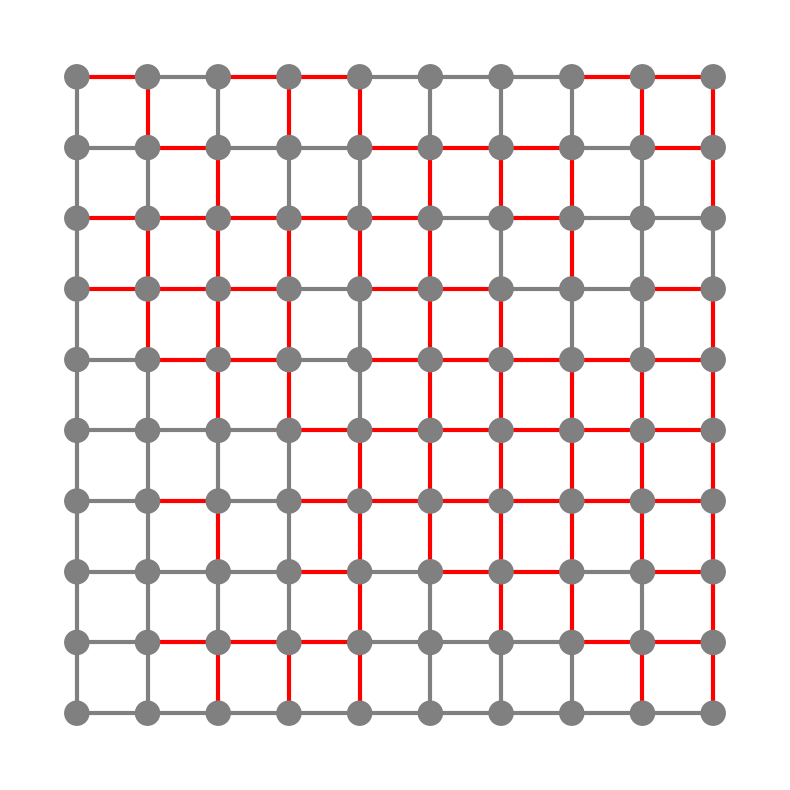

Closing_matrix: 


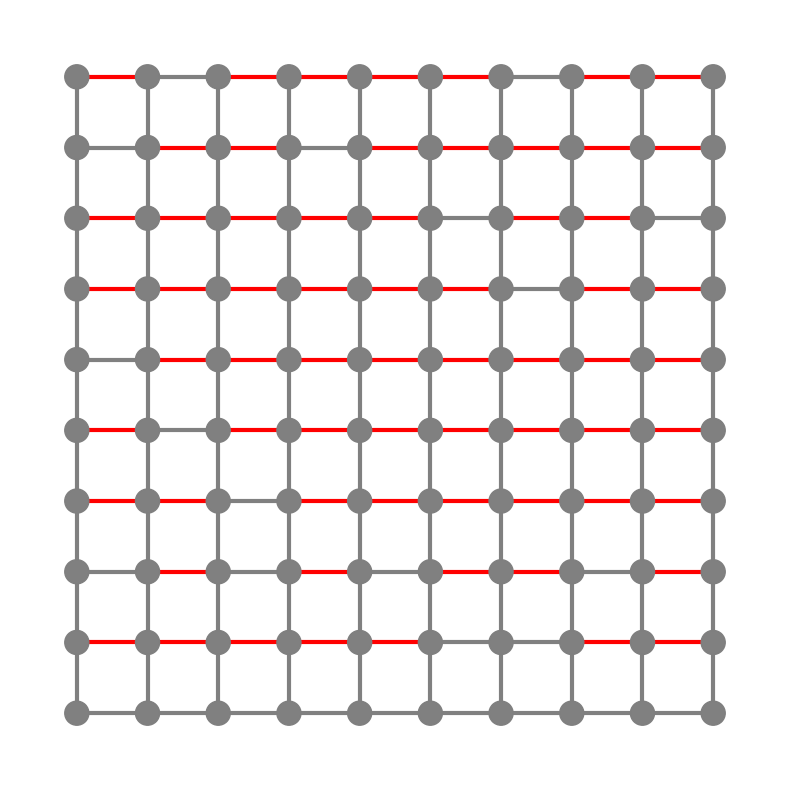

In [59]:
print("Eroded_matix: ")
result_edges_erosion = Erosion(pos_adj, G, G2, G_str, origin, G_adj)
#result of erosion on original graph
Result_matrix(G, adj_matrix, structuring_element, result_edges_erosion)

print("Dilated_matix: ")
result_edges_dilation = Dilation(pos_adj, G, G2, G_str, origin, G_adj)
#result of dilation on original graph
Result_matrix(G, adj_matrix, structuring_element, result_edges_dilation)

print("Opening_matrix: ")
#eroded graph is created and passed to dilation step to perform opening operation
eroded_adj_matrix = create_adjacency_matrix(result_edges_erosion, n)#n is taken from above 
G_eroded = nx.from_numpy_matrix(eroded_adj_matrix)
result_edges_opening = Dilation(pos_adj, G, G2, G_str, origin, G_eroded)
Result_matrix(G, adj_matrix, structuring_element, result_edges_opening)

print("Closing_matrix: ")
#dilated graph is created and passed to eroded step to perform closing operation
dilated_adj_matrix = create_adjacency_matrix(result_edges_dilation, n)#n is taken from above 
G_dilated = nx.from_numpy_matrix(dilated_adj_matrix)
result_edges_closing = Erosion(pos_adj, G, G2, G_str, origin, G_dilated)
Result_matrix(G, adj_matrix, structuring_element, result_edges_closing)

In [21]:
def create_adjacency_matrix(result_edges, num_vertices):
    # Initialize an empty n x n adjacency matrix
    adjacency_matrix = np.zeros((num_vertices*num_vertices, num_vertices*num_vertices), dtype=int)

    # Fill in the adjacency matrix
    for edge in result_edges:
        source, destination = edge
        adjacency_matrix[source][destination] = 1
        # If the graph is undirected, you can also set the symmetric edge
        # adjacency_matrix[destination][source] = 1

    return adjacency_matrix

In [22]:
def Erosion(pos_adj, G, G2, G_str, origin, G_adj):

    result_edges = []

    #pos_adj_inverse
    pos_adj_inv = {v: k for k, v in pos_adj.items()}

    #get last node in the adj_matrix to define stopping point
    adj_nodes = [(pos_adj[u]) for u in list(G.nodes())]
    adj_last_node = adj_nodes[-1]

    #To get nodes in the structuring element
    str_nodes = [(pos_s[u]) for u in list(G2.nodes())]

    #To get connected edges in the structuring element
    str_elem_edges = [(pos_s[u],pos_s[v]) for u,v in G_str.edges()]
    #initial position values for the str element in adj_matrix
    start_str_elem_edges = str_elem_edges #stored for use in while loop

    origin_edges = [(pos_s[u],pos_s[v]) for u,v in origin]
    start_origin_edges = origin_edges

    #sub_graph of adj matrix
    sub_list = []
    sub_list_pos = []
    for j in str_nodes:
        for k,l in pos_adj.items():
            if(j == l):
                sub_list.append(k)
                sub_list_pos.append(l)

    #initial position values for the str element edges in adj matrix
    str_elem_adj_edges = [(pos_adj_inv[edge[0]], pos_adj_inv[edge[1]]) for edge in str_elem_edges]
    origin_adj_edges = [(pos_adj_inv[edge[0]], pos_adj_inv[edge[1]]) for edge in origin_edges]

    #defining for proper mvement
    start_l = sub_list_pos
    start_node = sub_list_pos[0]
    end_node = sub_list_pos[-1]

    while(end_node != adj_last_node):#vertical

        #sub_graph_edges compared with str_elem_edges
        G_sub = G_adj.subgraph(sub_list)
        sub_edges = list(G_sub.edges())

        #created sets in order to remove duplicates and sort them in same order
        sub_edges_set = set(tuple(sorted(edge)) for edge in sub_edges)
        str_elem_adj_edges_set = set(tuple(sorted(edge)) for edge in str_elem_adj_edges)
        origin_adj_edges_set = set(tuple(sorted(edge)) for edge in origin_adj_edges)

        #check if all values in str_elem_et are in the subset
        edge_flag = all(i in sub_edges_set for i in str_elem_adj_edges_set)
        if(edge_flag):
            result_edges.extend(list(origin_adj_edges_set))

        while(end_node[0] != adj_last_node[0]): # horizontal
            #moving horizontally
            sub_list_pos = [(i + 1, j) for (i, j) in sub_list_pos]
            start_node = sub_list_pos[0]
            end_node = sub_list_pos[-1]

            #updating sub_list moving horizontally based on new sub_list_pos and converting in form so that it can be compared
            sub_list = [pos_adj_inv[edge] for edge in sub_list_pos]

            #updated str_lem nodes moving horizontally
            str_elem_edges = [((i + 1, j), (k + 1, l)) for ((i, j), (k, l)) in str_elem_edges]
            origin_edges = [((i + 1, j), (k + 1, l)) for ((i, j), (k, l)) in origin_edges]
            #converted in proper form for comparision
            str_elem_adj_edges = [(pos_adj_inv[edge[0]], pos_adj_inv[edge[1]]) for edge in str_elem_edges]
            origin_adj_edges = [(pos_adj_inv[edge[0]], pos_adj_inv[edge[1]]) for edge in origin_edges]

            #sub_graph_edges compared with str_elem_edges
            G_sub = G_adj.subgraph(sub_list)
            sub_edges = list(G_sub.edges())
            sub_edges_set = set(tuple(sorted(edge)) for edge in sub_edges)
            str_elem_adj_edges_set = set(tuple(sorted(edge)) for edge in str_elem_adj_edges)
            origin_adj_edges_set = set(tuple(sorted(edge)) for edge in origin_adj_edges)

            #check if all values in str_element are in the subset
            edge_flag = all(i in sub_edges_set for i in str_elem_adj_edges_set)
            if(edge_flag):
                result_edges.extend(list(origin_adj_edges_set)) 

        #if this is the last block stop here
        if(end_node == adj_last_node):
            break

        #reset to start position and then increment vertically
        sub_list_pos = start_l
        sub_list_pos = [(i,j + 1) for (i,j) in sub_list_pos]
        end_node = sub_list_pos[-1]
        start_l = sub_list_pos #this is the new start element now

        #updating sub_list moving vertically based on new sub_list_pos and converting in proper form using pos_adj_inv dict 
        sub_list = [pos_adj_inv[edge] for edge in sub_list_pos]

        #reset to start position and then increment for str_elem
        str_elem_edges = start_str_elem_edges
        str_elem_edges = [((i, j + 1), (k, l + 1)) for ((i, j), (k, l)) in str_elem_edges]

        #reset to start position and then increment for origin
        origin_edges = start_origin_edges
        origin_edges = [((i, j + 1), (k, l + 1)) for ((i, j), (k, l)) in origin_edges]

        #updated str elem edges based on adj matrix
        str_elem_adj_edges = [(pos_adj_inv[edge[0]], pos_adj_inv[edge[1]]) for edge in str_elem_edges]
        start_str_elem_edges = str_elem_edges #this is the new start element now

        #updated origin edges based on adj matrix
        origin_adj_edges = [(pos_adj_inv[edge[0]], pos_adj_inv[edge[1]]) for edge in origin_edges]
        start_origin_edges = origin_edges

    return result_edges

## Dilation

In [23]:
def Dilation(pos_adj, G, G2, G_str, origin, G_adj):
    result_edges = []

    #pos_adj_inverse
    pos_adj_inv = {v: k for k, v in pos_adj.items()}

    #get last node in the adj_matrix to define stopping point
    adj_nodes = [(pos_adj[u]) for u in list(G.nodes())]
    adj_last_node = adj_nodes[-1]

    #To get nodes in the structuring element
    str_nodes = [(pos_s[u]) for u in list(G2.nodes())]
    # print("str_nodes: ",str_nodes)

    #To get connected edges in the structuring element
    str_elem_edges = [(pos_s[u],pos_s[v]) for u,v in G_str.edges()]
    # print("str_elem_edges: ",str_elem_edges)
    start_str_elem_edges = str_elem_edges #stored for use in while loop

    origin_edges = [(pos_s[u],pos_s[v]) for u,v in origin]
    start_origin_edges = origin_edges

    #initial position values for the str element in adj_matrix
    #sub_graph of adj matrix
    sub_list = []
    sub_list_pos = []
    for j in str_nodes:
        for k,l in pos_adj.items():
            if(j == l):
                sub_list.append(k)
                sub_list_pos.append(l)

    # print("sub_list_pos: ",sub_list_pos) #sub_graph_pos of adj matrix
    # print("sub_list: ",sub_list) #sub_graph of adj matrix

    #initial position values for the str element edges in adj matrix
    str_elem_adj_edges = [(pos_adj_inv[edge[0]], pos_adj_inv[edge[1]]) for edge in str_elem_edges]
    origin_adj_edges = [(pos_adj_inv[edge[0]], pos_adj_inv[edge[1]]) for edge in origin_edges]
    # print("str_elem_adj_edges: ",str_elem_adj_edges)

    #defining for proper mvement
    start_l = sub_list_pos
    start_node = sub_list_pos[0]
    end_node = sub_list_pos[-1]
    # print("initial start_node: ",start_node)
    # print("initial end node: ",end_node)

    while(end_node != adj_last_node):#vertical

        #sub_graph_edges compared with str_elem_edges
        G_sub = G_adj.subgraph(sub_list)
        sub_edges = list(G_sub.edges())

        #created sets in order to remove duplicates and sort them in same order
        sub_edges_set = set(tuple(sorted(edge)) for edge in sub_edges)
        str_elem_adj_edges_set = set(tuple(sorted(edge)) for edge in str_elem_adj_edges)
        origin_adj_edges_set = set(tuple(sorted(edge)) for edge in origin_adj_edges)

        #check if all values in str_elem_et are in the subset
        edge_flag = all(i in sub_edges_set for i in origin_adj_edges_set)
        if(edge_flag):
            result_edges.extend(list(str_elem_adj_edges_set))
    #     print("matching result: ",result_edges)

        while(end_node[0] != adj_last_node[0]): # horizontal
            #moving horizontally
            sub_list_pos = [(i + 1, j) for (i, j) in sub_list_pos]
            start_node = sub_list_pos[0]
    #         print("in: ",sub_list_pos)
            end_node = sub_list_pos[-1]

            #updating sub_list moving horizontally based on new sub_list_pos and converting in form so that it can be compared
            sub_list = [pos_adj_inv[edge] for edge in sub_list_pos]
    #         print("sub_list: ",sub_list)

            #updated str_lem nodes moving horizontally
            str_elem_edges = [((i + 1, j), (k + 1, l)) for ((i, j), (k, l)) in str_elem_edges]
            origin_edges = [((i + 1, j), (k + 1, l)) for ((i, j), (k, l)) in origin_edges]
            #converted in proper form for comparision
            str_elem_adj_edges = [(pos_adj_inv[edge[0]], pos_adj_inv[edge[1]]) for edge in str_elem_edges]
            origin_adj_edges = [(pos_adj_inv[edge[0]], pos_adj_inv[edge[1]]) for edge in origin_edges]
    #         print("str_elem_adj_edges: ",str_elem_adj_edges)

            #sub_graph_edges compared with str_elem_edges
            G_sub = G_adj.subgraph(sub_list)
            sub_edges = list(G_sub.edges())
            sub_edges_set = set(tuple(sorted(edge)) for edge in sub_edges)
            str_elem_adj_edges_set = set(tuple(sorted(edge)) for edge in str_elem_adj_edges)
            origin_adj_edges_set = set(tuple(sorted(edge)) for edge in origin_adj_edges)

            #check if all values in str_elem_et are in the subset
            edge_flag = all(i in sub_edges_set for i in origin_adj_edges_set)
            if(edge_flag):
                result_edges.extend(list(str_elem_adj_edges_set))
    #         print("matching result: ",result_edges)  

        #if this is the last block stop here
        if(end_node == adj_last_node):
            break

        #reset to start position and then increment vertically
        sub_list_pos = start_l
        sub_list_pos = [(i,j + 1) for (i,j) in sub_list_pos]
        end_node = sub_list_pos[-1]
        start_l = sub_list_pos #this is the new start element now
    #     print("out: ",sub_list_pos)

        #updating sub_list moving vertically based on new sub_list_pos and converting in proper form using pos_adj_inv dict 
        sub_list = [pos_adj_inv[edge] for edge in sub_list_pos]
    #     print("sub_list: ",sub_list)

        #reset to start position and then increment for str_elem
        str_elem_edges = start_str_elem_edges
        str_elem_edges = [((i, j + 1), (k, l + 1)) for ((i, j), (k, l)) in str_elem_edges]

        #reset to start position and then increment for origin
        origin_edges = start_origin_edges
        origin_edges = [((i, j + 1), (k, l + 1)) for ((i, j), (k, l)) in origin_edges]

        #updated str elem edges based on adj matrix
        str_elem_adj_edges = [(pos_adj_inv[edge[0]], pos_adj_inv[edge[1]]) for edge in str_elem_edges]
    #     print("str_elem_adj_edges: ",str_elem_adj_edges)
        start_str_elem_edges = str_elem_edges #this is the new start element now

        #updated origin edges based on adj matrix
        origin_adj_edges = [(pos_adj_inv[edge[0]], pos_adj_inv[edge[1]]) for edge in origin_edges]
        start_origin_edges = origin_edges

    return result_edges

In [24]:
import numpy as np
def Result_matrix(G, adj_matix, structuring_element, result_edges):
    global opening_dataset
    
    graph = nx.Graph()

    # Add nodes to the graph
    graph.add_nodes_from(range(100))

    # Add edges from the result_edges list to the graph
    graph.add_edges_from(result_edges)

    # Append the graph to the dataset
    opening_dataset.append(graph)

#     # Set node color and edge color for nodes and edges in the adjacency matrix
#     node_color_adj = ['gray' if i in range(len(result_matrix)) else 'lightgray' for i in range(G.number_of_nodes())]
#     edge_color_adj = ['red' if edge in result_edges else 'gray' for edge in G.edges()]
#     pos_adj = nx.get_node_attributes(G, 'pos')

#     # Draw the adjacency matrix graph
#     plt.figure(figsize=(10, 10))
#     # plt.title("Opening: Result Matrix Graph")
#     nx.draw_networkx(
#         G, pos=pos_adj, with_labels=False, edgecolors="tab:gray", node_color=node_color_adj,
#         node_size=300, font_size=10, edge_color=edge_color_adj, width=3
#     )
#     plt.box(False)
#     plt.gca().set_aspect('equal')
    
#     # # Save the graph as an image with a specific name and folder
#     # filename = f"{open_foldername}/opening_matrix_{file}.png"
#     # plt.savefig(filename)
#     plt.show()

In [25]:
import numpy as np
def Result_matrix_trad(G, adj_matix, structuring_element, result_edges):
    global opening_dataset_trad
    graph = nx.Graph()

    # Add nodes to the graph
    graph.add_nodes_from(range(100))

    # Add edges from the result_edges list to the graph
    graph.add_edges_from(result_edges)

    # Append the graph to the dataset
    opening_dataset_trad.append(graph)
#     # Dimensions of the matrices
#     m, n = adj_matrix.shape
#     k, l = structuring_element.shape

#     # Initialize the result matrix with zeros
#     result_matrix = np.zeros((m, n))

#     # Graph from result matrix
#     G_result = nx.from_numpy_matrix(result_matrix)

#     # Set node color and edge color for nodes and edges in the adjacency matrix
#     node_color_adj = ['gray' if i in range(len(result_matrix)) else 'lightgray' for i in range(G.number_of_nodes())]
#     edge_color_adj = ['red' if edge in result_edges else 'gray' for edge in G.edges()]
#     pos_adj = nx.get_node_attributes(G, 'pos')

#     # Draw the adjacency matrix graph
#     plt.figure(figsize=(10, 10))
#     # plt.title("Opening: Result Matrix Graph")
#     nx.draw_networkx(
#         G, pos=pos_adj, with_labels=False, edgecolors="tab:gray", node_color=node_color_adj,
#         node_size=300, font_size=10, edge_color=edge_color_adj, width=3
#     )
#     plt.box(False)
#     plt.gca().set_aspect('equal')
#     # # Save the graph as an image with a specific name and folder
#     # filename = f"{open_foldername}/opening_matrix_{file}.png"
#     # plt.savefig(filename)
#     plt.show()

In [33]:
print(opening_dataset)
print(opening_dataset_trad)

[<networkx.classes.graph.Graph object at 0x10c17cf50>, <networkx.classes.graph.Graph object at 0x10c04e950>, <networkx.classes.graph.Graph object at 0x10c086950>, <networkx.classes.graph.Graph object at 0x10c2252d0>, <networkx.classes.graph.Graph object at 0x10c226d10>, <networkx.classes.graph.Graph object at 0x10c643010>, <networkx.classes.graph.Graph object at 0x10c339950>, <networkx.classes.graph.Graph object at 0x10c3248d0>, <networkx.classes.graph.Graph object at 0x10c65fe90>, <networkx.classes.graph.Graph object at 0x10c8fd810>, <networkx.classes.graph.Graph object at 0x10ca10510>, <networkx.classes.graph.Graph object at 0x10cad7e90>, <networkx.classes.graph.Graph object at 0x10cba6950>, <networkx.classes.graph.Graph object at 0x10cb7e0d0>, <networkx.classes.graph.Graph object at 0x10cc9e590>, <networkx.classes.graph.Graph object at 0x10cc56950>, <networkx.classes.graph.Graph object at 0x10cb3b2d0>, <networkx.classes.graph.Graph object at 0x10cbddd50>, <networkx.classes.graph.Gra

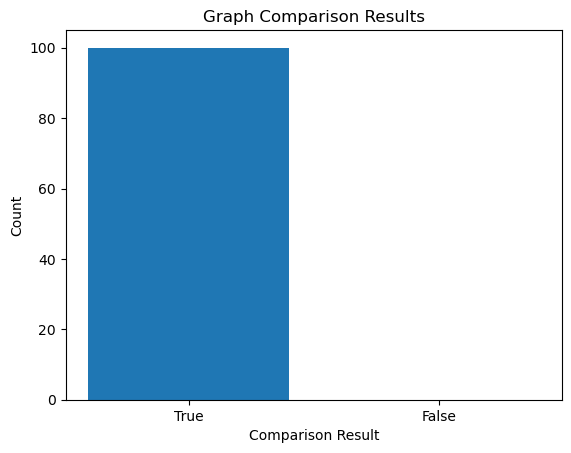

In [37]:
import networkx as nx
import matplotlib.pyplot as plt

true_count = 0
false_count = 0

for i in range(len(opening_dataset)):
    if nx.is_isomorphic(opening_dataset[i], opening_dataset_trad[i]):
        true_count += 1
    else:
        false_count += 1

labels = ['True', 'False']
counts = [true_count, false_count]

plt.bar(labels, counts)
plt.xlabel('Comparison Result')
plt.ylabel('Count')
plt.title('Graph Comparison Results')
plt.show()